In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.7


exoplanet version: 0.2.1.dev0


# Astrometric fitting

In this tutorial we'll walk through the simplest astrometric example with `exoplanet` and then explain how to build up a more complicated example with parallax measurements. For our dataset, we'll use astrometric and radial velocity observations of a binary star system.

Astrometric observations usually consist of measurements of the separation and position angle of the secondary star (or directly imaged exoplanet), relative to the primary star as a function of time. The simplest astrometric orbit (in terms of number of parameters), describes the orbit using a semi-major axis `a_ang` measured in *arcseconds*, since the distance to the system is assumed to be unknown. We'll work through this example first, then introduce the extra constraints provided by parallax information.

## Data 
First, let's load and examine the data. We'll use the astrometric measurements of HR 466 (HD 10009) as compiled by [Pourbaix 1998](https://ui.adsabs.harvard.edu/#abs/1998A&AS..131..377P/abstract). The speckle observations are originally from [Hartkopf et al. 1996](https://ui.adsabs.harvard.edu/#abs/1996AJ....111..370H/abstract). 

In [3]:
from astropy.io import ascii
from astropy.time import Time

# grab the formatted data and do some munging
dirname = "https://gist.github.com/iancze/262aba2429cb9aee3fd5b5e1a4582d4d/raw/c5fa5bc39fec90d2cc2e736eed479099e3e598e3/"

astro_data_full = ascii.read(dirname + "astro.txt", format="csv", fill_values=[(".", '0')])

# convert UT date to JD
astro_dates = Time(astro_data_full["date"].data, format="decimalyear")

# Following the Pourbaix et al. 1998 analysis, we'll limit ourselves to the highest quality data
# since the raw collection of data outside of these ranges has some ambiguities in swapping 
# the primary and secondary star
ind = (astro_dates.value > 1975.) & (astro_dates.value < 1999.73) \
    & (~astro_data_full["rho"].mask) & (~astro_data_full["PA"].mask)

astro_data = astro_data_full[ind]

astro_yrs = astro_data["date"]
astro_dates.format = 'jd'
astro_jds = astro_dates[ind].value

Many of these measurements in this heterogeneous dataset do not have reported error measurements. For these, we assume a modest uncertainty of $1^\circ$ in position angle and $0.01^{\prime\prime}$ in separation for the sake of specifying something, but we'll include a jitter term for both of these measurements as well. The scatter in points around the final solution will be a decent guide of what the measurement uncertainties actually were.

In [4]:
import numpy as np

astro_data["rho_err"][astro_data["rho_err"].mask == True] = 0.01
astro_data["PA_err"][astro_data["PA_err"].mask == True] = 1.0

# Convert all masked frames to be raw np arrays, since theano has issues with astropy masked columns
rho_data = np.ascontiguousarray(astro_data["rho"], dtype=float) # arcsec
rho_err = np.ascontiguousarray(astro_data["rho_err"], dtype=float)

# The position angle measurements come in degrees in the range [0, 360].
# We'll convert this to radians in the range [-pi, pi]
deg = np.pi/180.
theta_data = np.ascontiguousarray(astro_data["PA"] * deg, dtype=float) 
theta_data[theta_data > np.pi] -= 2 * np.pi

theta_err = np.ascontiguousarray(astro_data["PA_err"] * deg) # radians

## Astrometric conventions

The conventions describing the orientation of the orbits are described in detail in the *exoplanet* paper; we summarize them briefly here. Generally, we follow the conventions from Pourbaix et al. 1998, which are a consistent set conforming to the right-hand-rule and the conventions of the visual binary field, where the ascending node is that where the secondary is *receeding* from the observer (without radial velocity information, there is a $\pi$ degeneracy in which node is ascending, and so common practice in the literature is to report a value in the range $[0,\pi]$). The orbital inclination ranges from $[0, \pi$]. $i = 0$ describes a face-on orbit rotating counter-clockwise on the sky plane, while $i=\pi$ describes a face-on orbit rotating clockwise on the sky. $i = \pi/2$ is an edge-on orbit. 

The observer frame $X$, $Y$, $Z$ is oriented on the sky such that $+Z$ points towards the observer, $X$ is the north axis, and $Y$ is the east axis. *All* angles are measured in radians, and the position angle is returned in the range $[-\pi, \pi]$, which is the degrees east of north (be sure to check your data is in this format too!) The radial velocity is still defined such that a positive radial velocity corresponds to motion away from the observer.

In an astrometric-only orbit, it is common practice in the field to report $\omega = \omega_\mathrm{secondary}$, whereas with an RV orbit it is generally common practice to report $\omega = \omega_\mathrm{primary}$. The result is that unless the authors specify what they're using, in a joint astrometric-RV orbit there is an ambiguity to which $\omega$ the authors mean, since $\omega_\mathrm{primary} = \omega_\mathrm{secondary} + \pi$. To standardize this across the *exoplanet* package, in all orbits (including astrometric-only) $\omega = \omega_\mathrm{primary}$.

/mnt/home/dforeman/miniconda3/envs/autoexoplanet/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


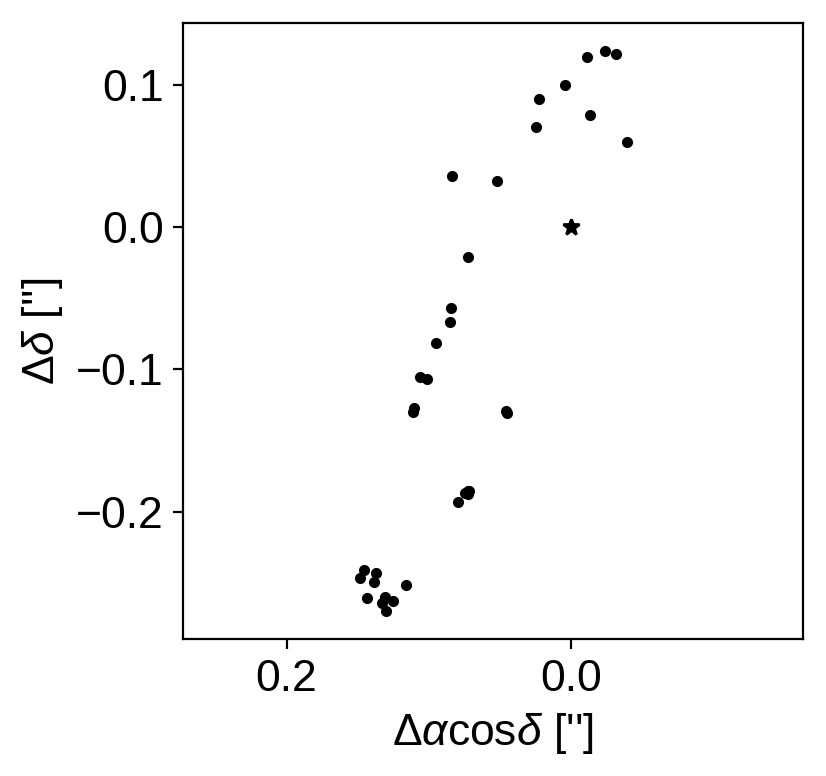

In [5]:
import matplotlib.pyplot as plt

# Make a plot of the astrometric data on the sky
# The convention is that North is up and East is left
fig, ax = plt.subplots(nrows=1, figsize=(4, 4))

xs = rho_data * np.cos(theta_data) # X is north
ys = rho_data * np.sin(theta_data) # Y is east
ax.plot(ys, xs, ".k")
ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax.invert_xaxis()
ax.plot(0,0, "k*")
ax.set_aspect("equal", "datalim")

The plot on the sky is helpful to look at, but the "raw" measurements are the values of $\rho$ (separation) and $\theta$ (also called P.A., position angle) that we listed in our data table, and that the measurement uncertainties live on these values as nice Gaussians. So, to visualize this space more clearly, we can plot $\rho$ vs. time and P.A. vs. time.

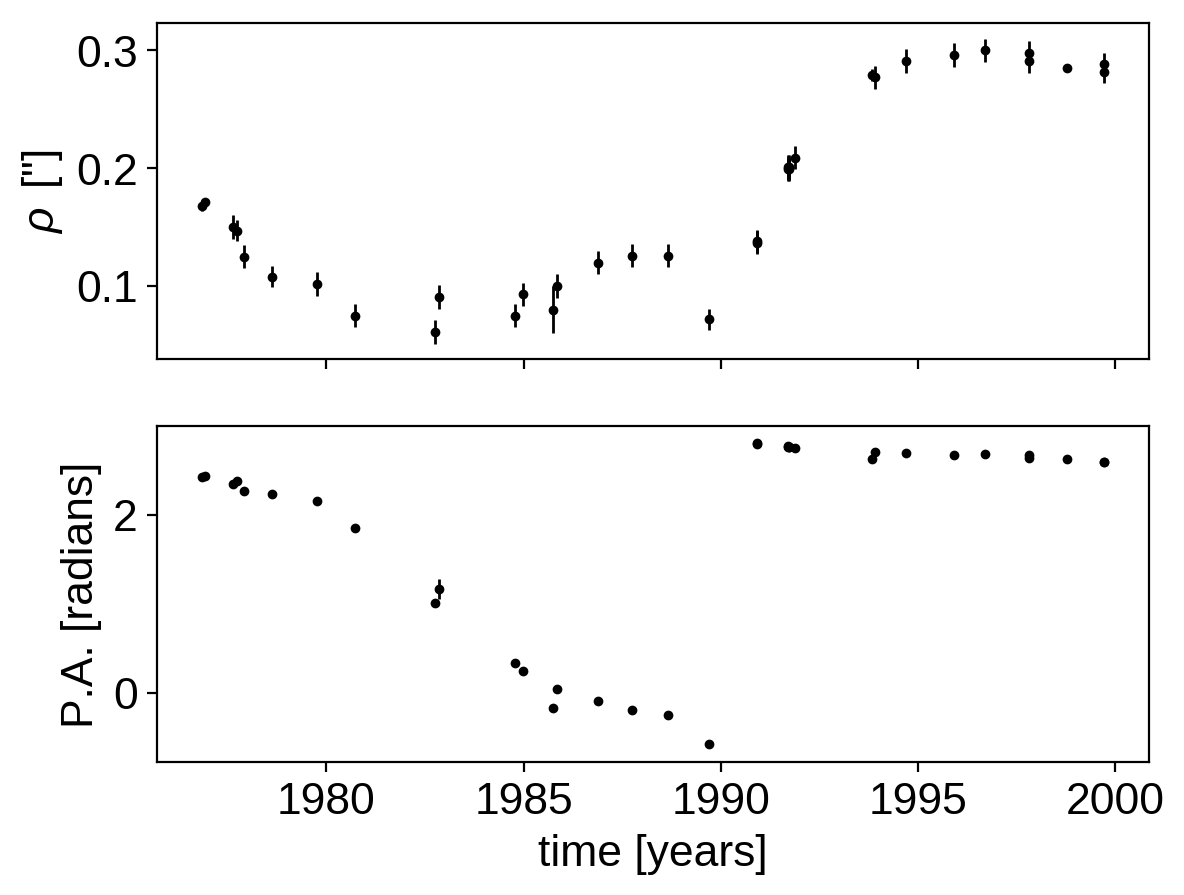

In [6]:
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].errorbar(astro_yrs, rho_data, yerr=rho_err, fmt=".k", lw=1, ms=5)
ax[0].set_ylabel(r'$\rho\,$ ["]')

ax[1].errorbar(astro_yrs, theta_data, yerr=theta_err, fmt=".k", lw=1, ms=5)
ax[1].set_ylabel(r'P.A. [radians]')
ax[1].set_xlabel("time [years]");

## Fitting the astrometric orbit with *exoplanet*

To get started, let's import the relative packages from *exoplanet*, plot up a preliminary orbit from the literature, and then sample to find the best parameters.

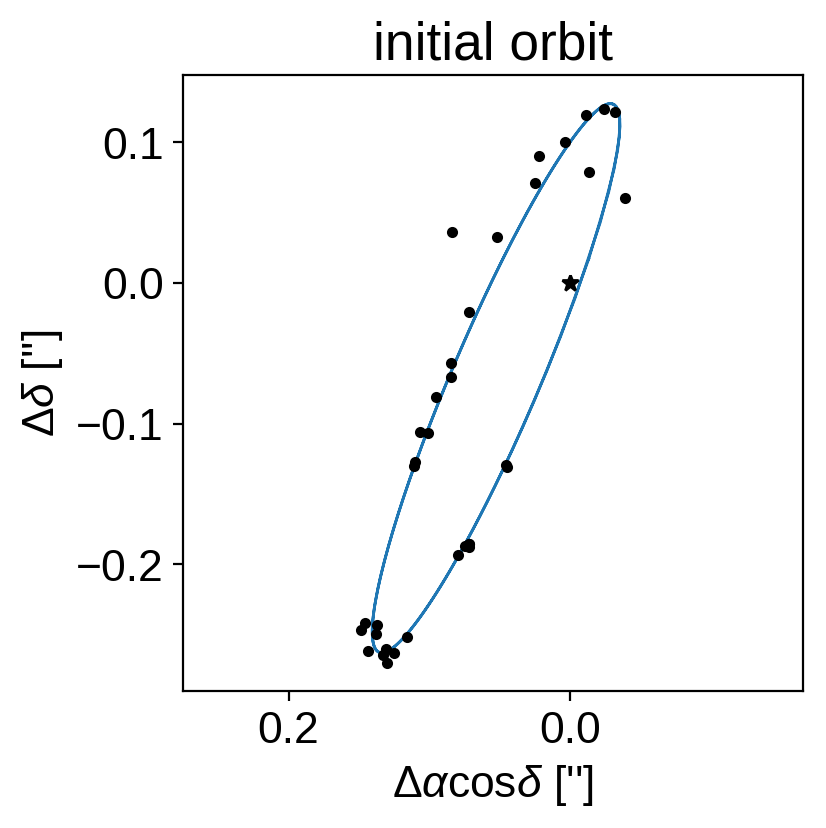

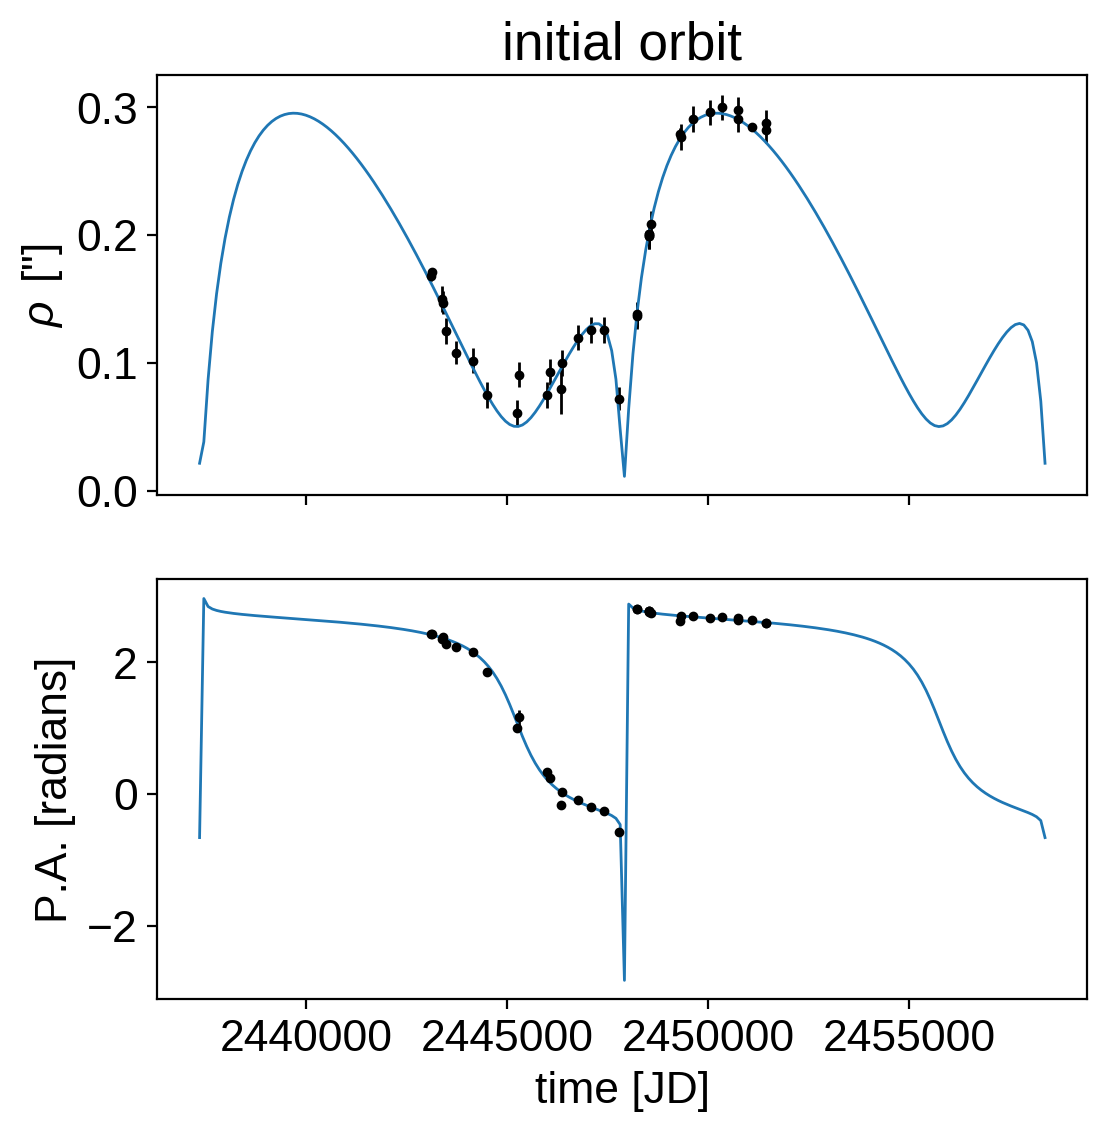

In [7]:
import pymc3 as pm 
import theano.tensor as tt

import exoplanet as xo
from exoplanet.distributions import Angle

from astropy import constants

# conversion constant from au to R_sun
au_to_R_sun = (constants.au / constants.R_sun).value

# Just to get started, let's take a look at the orbit using the best-fit parameters from Pourbaix et al. 1998

# Orbital elements from Pourbaix et al. 1998
# For the relative astrometric fit, we only need the following parameters
a_ang = 0.324  # arcsec
parallax = 1  # arcsec (meaningless choice for now)
a = a_ang * au_to_R_sun / parallax
e = 0.798
i = 96.0 * deg  # [rad]
omega = 251.6 * deg - np.pi  # Pourbaix reports omega_2, but we want omega_1
Omega = 159.6 * deg 
P = 28.8 * 365.25 # days

T0 = Time(1989.92, format="decimalyear")
T0.format = "jd"
T0 = T0.value  # [Julian Date]

# instantiate the orbit
orbit = xo.orbits.KeplerianOrbit(
    a=a, t_periastron=T0, period=P, incl=i, ecc=e,
    omega=omega, Omega=Omega)

# The position functions take an optional argument parallax to convert from
# physical units back to arcseconds
t = np.linspace(T0 - P, T0 + P, num=200) # days
rho, theta = theano.function([], orbit.get_relative_angles(t, parallax))()

# Plot the orbit 
fig, ax = plt.subplots(nrows=1, figsize=(4, 4))

xs = rho * np.cos(theta) # X is north
ys = rho * np.sin(theta) # Y is east
ax.plot(ys, xs, color="C0", lw=1)

# plot the data
xs = rho_data * np.cos(theta_data) # X is north
ys = rho_data * np.sin(theta_data) # Y is east
ax.plot(ys, xs, ".k")

ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax.invert_xaxis()
ax.plot(0, 0, "k*")
ax.set_aspect("equal", "datalim")
ax.set_title("initial orbit");

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax[0].errorbar(astro_jds, rho_data, yerr=rho_err, fmt=".k", lw=1, ms=5)
ax[0].plot(t, rho, color="C0", lw=1)
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[0].set_title("initial orbit");

ax[1].errorbar(astro_jds, theta_data, yerr=theta_err, fmt=".k", lw=1, ms=5)
ax[1].plot(t, theta, color="C0", lw=1)
ax[1].set_ylabel(r'P.A. [radians]')
ax[1].set_xlabel("time [JD]");

Now that we have an initial orbit, we can set the model up using PyMC3 to do inference.

In [8]:
yr = 365.25

# for predicted orbits
t_fine = np.linspace(astro_jds.min() - 500, astro_jds.max() + 500, num=1000)

def get_model(parallax=None):
    with pm.Model() as model:

        if parallax is None:
            # Without an actual parallax measurement, we can model the orbit in units of arcseconds
            # by providing a fake_parallax and conversion constant
            plx = 1  # arcsec 
        else:
            # Below we will run a version of this model where a measurement of parallax is provided
            # The measurement is in milliarcsec
            m_plx = pm.Bound(pm.Normal, lower=0, upper=100)("m_plx", mu=parallax[0], sd=parallax[1], testval=parallax[0])
            plx = pm.Deterministic("plx", 1e-3 * m_plx)
            
        a_ang = pm.Uniform("a_ang", 0.1, 1.0, testval=0.324)
        a = pm.Deterministic("a", a_ang / plx)

        # We expect the period to be somewhere in the range of 25 years, 
        # so we'll set a broad prior on logP
        logP = pm.Normal("logP", mu=np.log(25*yr), sd=10.0, testval=np.log(28.8*yr))
        P = pm.Deterministic("P", tt.exp(logP))

        # For astrometric-only fits, it's generally better to fit in
        # p = (Omega + omega)/2 and m = (Omega - omega)/2 instead of omega and Omega
        # directly
        omega0 = 251.6 * deg - np.pi
        Omega0 = 159.6 * deg
        p = Angle("p", testval=0.5*(Omega0 + omega0))
        m = Angle("m", testval=0.5*(Omega0 - omega0))
        omega = pm.Deterministic("omega", p - m)
        Omega = pm.Deterministic("Omega", p + m)

        # For these orbits, it can also be better to fit for a phase angle
        # (relative to a reference time) instead of the time of periasteron
        # passage directly
        phase = Angle("phase", testval=0.0)
        tperi = pm.Deterministic("tperi", T0 + P * phase / (2*np.pi))

        # Geometric uiform prior on cos(incl)
        cos_incl = pm.Uniform("cos_incl", lower=-1, upper=1, testval=np.cos(96.0 * deg))
        incl = pm.Deterministic("incl", tt.arccos(cos_incl))
        ecc = pm.Uniform("ecc", lower=0.0, upper=1.0, testval=0.798)

        # Set up the orbit
        orbit = xo.orbits.KeplerianOrbit(
            a=a * au_to_R_sun, t_periastron=tperi, period=P, 
            incl=incl, ecc=ecc, omega=omega, Omega=Omega)
        if parallax is not None:
            pm.Deterministic("M_tot", orbit.m_total)

        # Compute the model in rho and theta
        rho_model, theta_model = orbit.get_relative_angles(astro_jds, plx)
        pm.Deterministic("rho_model", rho_model)
        pm.Deterministic("theta_model", theta_model)

        # Add jitter terms to both separation and position angle
        log_rho_s = pm.Normal("log_rho_s", mu=np.log(np.median(rho_err)), sd=5.0)
        log_theta_s = pm.Normal("log_theta_s", mu=np.log(np.median(theta_err)), sd=5.0)
        rho_tot_err = tt.sqrt(rho_err**2 + tt.exp(2*log_rho_s))
        theta_tot_err = tt.sqrt(theta_err**2 + tt.exp(2*log_theta_s))

        # define the likelihood function, e.g., a Gaussian on both rho and theta
        pm.Normal("rho_obs", mu=rho_model, sd=rho_tot_err, observed=rho_data)

        # We want to be cognizant of the fact that theta wraps so the following is equivalent to 
        # pm.Normal("obs_theta", mu=theta_model, observed=theta_data, sd=theta_tot_err)
        # but takes into account the wrapping. Thanks to Rob de Rosa for the tip.
        theta_diff = tt.arctan2(tt.sin(theta_model - theta_data), tt.cos(theta_model - theta_data))
        pm.Normal("theta_obs", mu=theta_diff, sd=theta_tot_err, observed=0.0)

        # Set up predicted orbits for later plotting 
        rho_dense, theta_dense = orbit.get_relative_angles(t_fine, plx)
        rho_save = pm.Deterministic("rho_save", rho_dense)
        theta_save = pm.Deterministic("theta_save", theta_dense)

        # Optimize to find the initial parameters
        map_soln = model.test_point
        map_soln = xo.optimize(map_soln, vars=[log_rho_s, log_theta_s])
        map_soln = xo.optimize(map_soln, vars=[phase])
        map_soln = xo.optimize(map_soln, vars=[p, m, ecc])
        map_soln = xo.optimize(map_soln, vars=[logP, a_ang, phase])
        map_soln = xo.optimize(map_soln)
    
    return model, map_soln

model, map_soln = get_model()

optimizing logp for variables: ['log_theta_s', 'log_rho_s']


message: Optimization terminated successfully.
logp: 104.85554109314324 -> 147.14399186006233


optimizing logp for variables: ['phase_angle__']


message: Optimization terminated successfully.
logp: 147.14399186006233 -> 167.64220598198332


optimizing logp for variables: ['ecc_interval__', 'm_angle__', 'p_angle__']


message: Optimization terminated successfully.
logp: 167.64220598198335 -> 210.06340668298847


optimizing logp for variables: ['phase_angle__', 'a_ang_interval__', 'logP']


message: Optimization terminated successfully.
logp: 210.06340668298847 -> 210.5013698914882


optimizing logp for variables: ['log_theta_s', 'log_rho_s', 'ecc_interval__', 'cos_incl_interval__', 'phase_angle__', 'm_angle__', 'p_angle__', 'logP', 'a_ang_interval__']


message: Optimization terminated successfully.
logp: 210.5013698914882 -> 215.02117742210876


Now that we have a maximum a posteriori estimate of the parameters, let's take a look at the results to make sure that they seem reasonable.

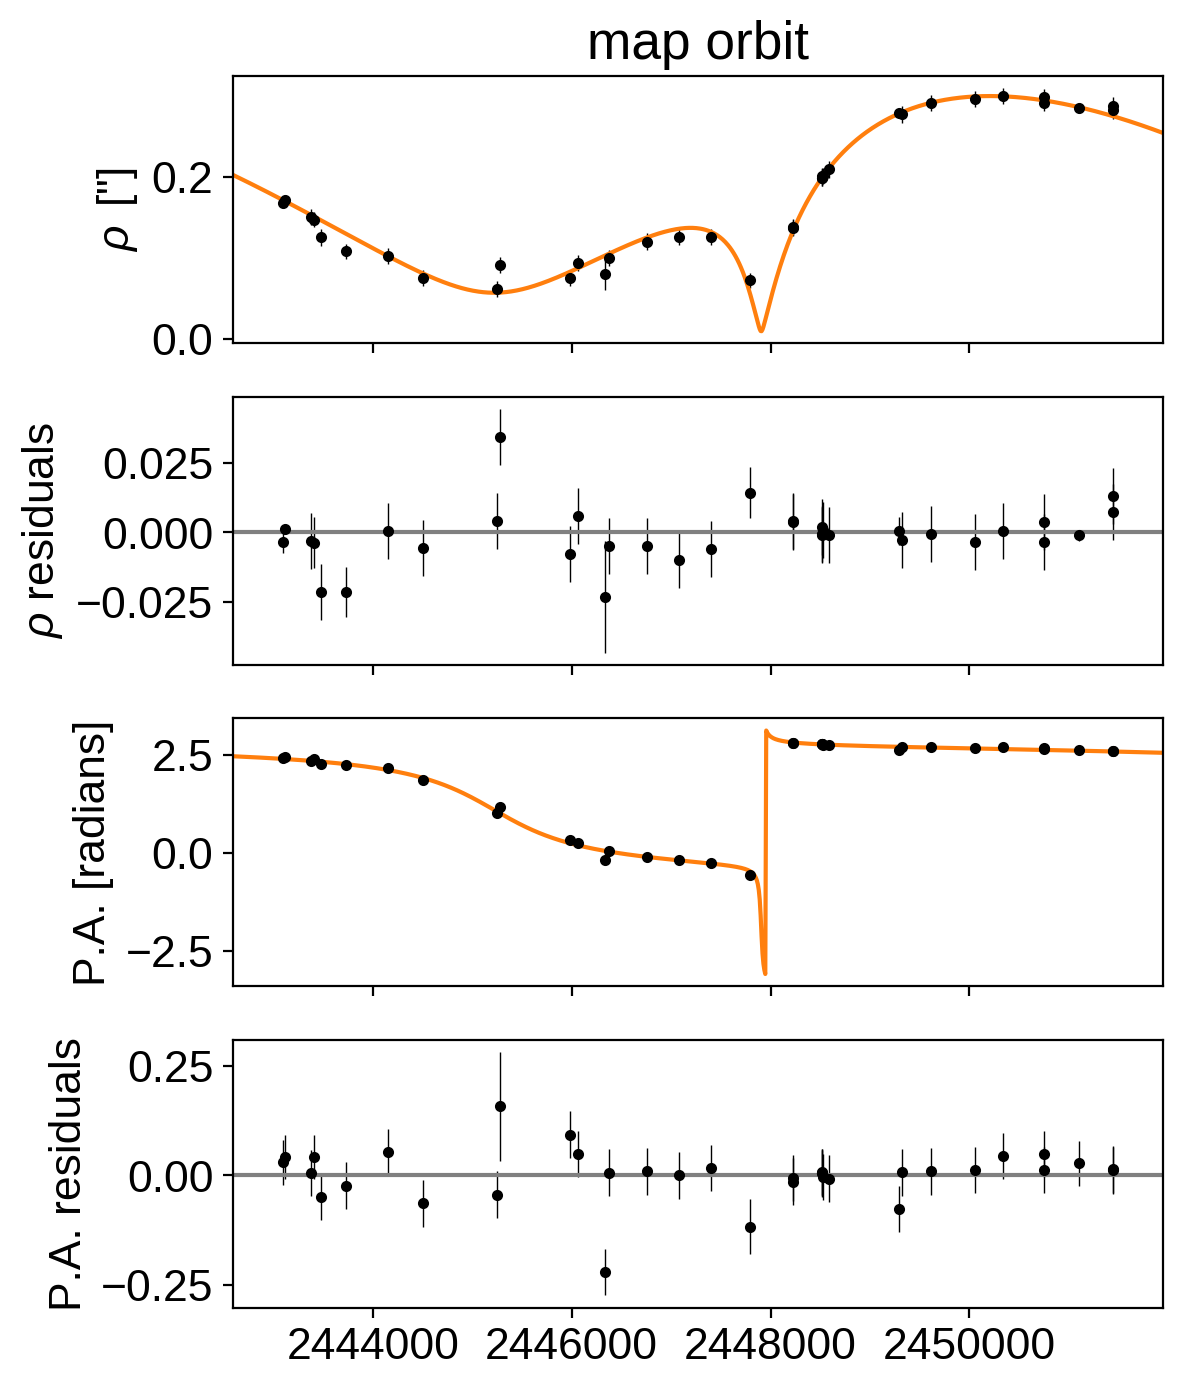

In [9]:
ekw = dict(fmt=".k", lw=0.5)

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(6,8))
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r'$\rho$ residuals')
ax[2].set_ylabel(r'P.A. [radians]')
ax[3].set_ylabel(r'P.A. residuals')

tot_rho_err = np.sqrt(rho_err**2 + np.exp(2 * map_soln["log_rho_s"]))
tot_theta_err = np.sqrt(theta_err**2 + np.exp(2 * map_soln["log_theta_s"]))

ax[0].errorbar(astro_jds, rho_data, yerr=tot_rho_err, **ekw)
ax[0].plot(t_fine, map_soln["rho_save"], "C1")

ax[1].axhline(0.0, color="0.5")
ax[1].errorbar(astro_jds, rho_data - map_soln["rho_model"], yerr=tot_rho_err, **ekw)


ax[2].plot(t_fine, map_soln["theta_save"], "C1")
ax[2].errorbar(astro_jds, theta_data, yerr=tot_theta_err, **ekw)

ax[3].axhline(0.0, color="0.5")
ax[3].errorbar(astro_jds, theta_data - map_soln["theta_model"], yerr=tot_theta_err, **ekw) 

ax[3].set_xlim(t_fine[0], t_fine[-1])
ax[0].set_title("map orbit");

Now let's sample the posterior.

In [10]:
np.random.seed(1234)
with model:
    trace = pm.sample(tune=5000, draws=4000, start=map_soln,
                      step=xo.get_dense_nuts_step(target_accept=0.9, adaptation_window=201))

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang]


Sampling 4 chains:   0%|          | 0/36000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 13/36000 [00:00<04:40, 128.08draws/s]

Sampling 4 chains:   0%|          | 20/36000 [00:00<06:09, 97.50draws/s] 

Sampling 4 chains:   0%|          | 25/36000 [00:00<08:26, 71.04draws/s]

Sampling 4 chains:   0%|          | 32/36000 [00:00<08:58, 66.82draws/s]

Sampling 4 chains:   0%|          | 37/36000 [00:00<10:05, 59.41draws/s]

Sampling 4 chains:   0%|          | 45/36000 [00:00<09:59, 60.02draws/s]

Sampling 4 chains:   0%|          | 52/36000 [00:00<09:37, 62.29draws/s]

Sampling 4 chains:   0%|          | 58/36000 [00:00<09:47, 61.21draws/s]

Sampling 4 chains:   0%|          | 65/36000 [00:00<09:28, 63.17draws/s]

Sampling 4 chains:   0%|          | 72/36000 [00:01<09:42, 61.72draws/s]

Sampling 4 chains:   0%|          | 79/36000 [00:01<09:44, 61.47draws/s]

Sampling 4 chains:   0%|          | 86/36000 [00:01<10:32, 56.80draws/s]

Sampling 4 chains:   0%|          | 93/36000 [00:01<09:59, 59.94draws/s]

Sampling 4 chains:   0%|          | 100/36000 [00:01<10:41, 55.99draws/s]

Sampling 4 chains:   0%|          | 109/36000 [00:01<10:30, 56.89draws/s]

Sampling 4 chains:   0%|          | 119/36000 [00:01<09:20, 64.05draws/s]

Sampling 4 chains:   0%|          | 126/36000 [00:02<10:09, 58.89draws/s]

Sampling 4 chains:   0%|          | 133/36000 [00:02<10:13, 58.48draws/s]

Sampling 4 chains:   0%|          | 140/36000 [00:02<10:05, 59.25draws/s]

Sampling 4 chains:   0%|          | 147/36000 [00:02<10:43, 55.71draws/s]

Sampling 4 chains:   0%|          | 153/36000 [00:02<11:11, 53.41draws/s]

Sampling 4 chains:   0%|          | 160/36000 [00:02<10:27, 57.14draws/s]

Sampling 4 chains:   0%|          | 166/36000 [00:02<11:00, 54.28draws/s]

Sampling 4 chains:   0%|          | 174/36000 [00:02<11:05, 53.85draws/s]

Sampling 4 chains:   1%|          | 181/36000 [00:03<10:26, 57.15draws/s]

Sampling 4 chains:   1%|          | 188/36000 [00:03<10:54, 54.72draws/s]

Sampling 4 chains:   1%|          | 196/36000 [00:03<10:01, 59.51draws/s]

Sampling 4 chains:   1%|          | 203/36000 [00:03<10:04, 59.18draws/s]

Sampling 4 chains:   1%|          | 212/36000 [00:03<09:21, 63.72draws/s]

Sampling 4 chains:   1%|          | 219/36000 [00:03<09:16, 64.32draws/s]

Sampling 4 chains:   1%|          | 226/36000 [00:03<10:13, 58.35draws/s]

Sampling 4 chains:   1%|          | 233/36000 [00:03<10:03, 59.23draws/s]

Sampling 4 chains:   1%|          | 240/36000 [00:03<10:44, 55.48draws/s]

Sampling 4 chains:   1%|          | 248/36000 [00:04<10:02, 59.32draws/s]

Sampling 4 chains:   1%|          | 255/36000 [00:04<09:58, 59.71draws/s]

Sampling 4 chains:   1%|          | 262/36000 [00:04<09:42, 61.34draws/s]

Sampling 4 chains:   1%|          | 269/36000 [00:04<10:20, 57.56draws/s]

Sampling 4 chains:   1%|          | 276/36000 [00:04<10:36, 56.15draws/s]

Sampling 4 chains:   1%|          | 282/36000 [00:04<10:30, 56.65draws/s]

Sampling 4 chains:   1%|          | 291/36000 [00:04<09:40, 61.48draws/s]

Sampling 4 chains:   1%|          | 299/36000 [00:04<09:05, 65.50draws/s]

Sampling 4 chains:   1%|          | 306/36000 [00:05<08:55, 66.65draws/s]

Sampling 4 chains:   1%|          | 313/36000 [00:05<09:03, 65.68draws/s]

Sampling 4 chains:   1%|          | 321/36000 [00:05<09:14, 64.36draws/s]

Sampling 4 chains:   1%|          | 330/36000 [00:05<08:40, 68.58draws/s]

Sampling 4 chains:   1%|          | 339/36000 [00:05<08:24, 70.70draws/s]

Sampling 4 chains:   1%|          | 349/36000 [00:05<07:52, 75.37draws/s]

Sampling 4 chains:   1%|          | 357/36000 [00:05<08:16, 71.76draws/s]

Sampling 4 chains:   1%|          | 366/36000 [00:05<07:47, 76.28draws/s]

Sampling 4 chains:   1%|          | 374/36000 [00:05<08:34, 69.19draws/s]

Sampling 4 chains:   1%|          | 382/36000 [00:06<08:42, 68.15draws/s]

Sampling 4 chains:   1%|          | 389/36000 [00:06<08:41, 68.27draws/s]

Sampling 4 chains:   1%|          | 399/36000 [00:06<08:12, 72.25draws/s]

Sampling 4 chains:   1%|          | 407/36000 [00:06<08:27, 70.11draws/s]

Sampling 4 chains:   1%|          | 418/36000 [00:06<07:33, 78.45draws/s]

Sampling 4 chains:   1%|          | 427/36000 [00:06<07:47, 76.14draws/s]

Sampling 4 chains:   1%|          | 437/36000 [00:06<07:47, 76.15draws/s]

Sampling 4 chains:   1%|          | 445/36000 [00:06<07:47, 76.04draws/s]

Sampling 4 chains:   1%|▏         | 454/36000 [00:07<07:41, 77.01draws/s]

Sampling 4 chains:   1%|▏         | 464/36000 [00:07<07:20, 80.64draws/s]

Sampling 4 chains:   1%|▏         | 474/36000 [00:07<07:04, 83.60draws/s]

Sampling 4 chains:   1%|▏         | 483/36000 [00:07<07:25, 79.69draws/s]

Sampling 4 chains:   1%|▏         | 492/36000 [00:07<08:30, 69.53draws/s]

Sampling 4 chains:   1%|▏         | 500/36000 [00:07<09:13, 64.15draws/s]

Sampling 4 chains:   1%|▏         | 508/36000 [00:07<09:35, 61.68draws/s]

Sampling 4 chains:   1%|▏         | 516/36000 [00:07<09:05, 65.02draws/s]

Sampling 4 chains:   1%|▏         | 525/36000 [00:08<08:28, 69.74draws/s]

Sampling 4 chains:   1%|▏         | 533/36000 [00:08<08:54, 66.38draws/s]

Sampling 4 chains:   2%|▏         | 543/36000 [00:08<08:11, 72.21draws/s]

Sampling 4 chains:   2%|▏         | 552/36000 [00:08<07:46, 76.05draws/s]

Sampling 4 chains:   2%|▏         | 560/36000 [00:08<07:56, 74.33draws/s]

Sampling 4 chains:   2%|▏         | 568/36000 [00:08<08:23, 70.39draws/s]

Sampling 4 chains:   2%|▏         | 577/36000 [00:08<08:49, 66.95draws/s]

Sampling 4 chains:   2%|▏         | 588/36000 [00:08<08:01, 73.54draws/s]

Sampling 4 chains:   2%|▏         | 599/36000 [00:08<07:15, 81.20draws/s]

Sampling 4 chains:   2%|▏         | 610/36000 [00:09<06:55, 85.19draws/s]

Sampling 4 chains:   2%|▏         | 623/36000 [00:09<06:33, 89.86draws/s]

Sampling 4 chains:   2%|▏         | 633/36000 [00:09<06:38, 88.73draws/s]

Sampling 4 chains:   2%|▏         | 643/36000 [00:09<07:22, 79.93draws/s]

Sampling 4 chains:   2%|▏         | 652/36000 [00:09<08:02, 73.21draws/s]

Sampling 4 chains:   2%|▏         | 660/36000 [00:09<07:55, 74.29draws/s]

Sampling 4 chains:   2%|▏         | 668/36000 [00:09<08:13, 71.60draws/s]

Sampling 4 chains:   2%|▏         | 676/36000 [00:10<08:52, 66.31draws/s]

Sampling 4 chains:   2%|▏         | 684/36000 [00:10<08:31, 69.11draws/s]

Sampling 4 chains:   2%|▏         | 694/36000 [00:10<07:49, 75.17draws/s]

Sampling 4 chains:   2%|▏         | 704/36000 [00:10<07:14, 81.21draws/s]

Sampling 4 chains:   2%|▏         | 713/36000 [00:10<07:33, 77.81draws/s]

Sampling 4 chains:   2%|▏         | 722/36000 [00:10<07:34, 77.61draws/s]

Sampling 4 chains:   2%|▏         | 735/36000 [00:10<06:39, 88.24draws/s]

Sampling 4 chains:   2%|▏         | 758/36000 [00:10<05:26, 107.78draws/s]

Sampling 4 chains:   2%|▏         | 780/36000 [00:10<04:38, 126.41draws/s]

Sampling 4 chains:   2%|▏         | 799/36000 [00:10<04:12, 139.47draws/s]

Sampling 4 chains:   2%|▏         | 826/36000 [00:11<03:36, 162.63draws/s]

Sampling 4 chains:   2%|▏         | 851/36000 [00:11<03:14, 180.68draws/s]

Sampling 4 chains:   2%|▏         | 877/36000 [00:11<02:56, 198.76draws/s]

Sampling 4 chains:   3%|▎         | 903/36000 [00:11<02:48, 208.86draws/s]

Sampling 4 chains:   3%|▎         | 926/36000 [00:11<02:43, 214.41draws/s]

Sampling 4 chains:   3%|▎         | 949/36000 [00:11<02:45, 211.32draws/s]

Sampling 4 chains:   3%|▎         | 972/36000 [00:11<02:53, 201.84draws/s]

Sampling 4 chains:   3%|▎         | 1001/36000 [00:11<02:40, 217.69draws/s]

Sampling 4 chains:   3%|▎         | 1024/36000 [00:11<02:51, 204.08draws/s]

Sampling 4 chains:   3%|▎         | 1053/36000 [00:12<02:36, 222.93draws/s]

Sampling 4 chains:   3%|▎         | 1083/36000 [00:12<02:24, 241.38draws/s]

Sampling 4 chains:   3%|▎         | 1110/36000 [00:12<02:20, 248.01draws/s]

Sampling 4 chains:   3%|▎         | 1136/36000 [00:12<02:24, 241.02draws/s]

Sampling 4 chains:   3%|▎         | 1166/36000 [00:12<02:16, 256.07draws/s]

Sampling 4 chains:   3%|▎         | 1203/36000 [00:12<02:05, 277.99draws/s]

Sampling 4 chains:   3%|▎         | 1237/36000 [00:12<01:58, 293.39draws/s]

Sampling 4 chains:   4%|▎         | 1271/36000 [00:12<01:54, 303.98draws/s]

Sampling 4 chains:   4%|▎         | 1306/36000 [00:12<01:49, 315.65draws/s]

Sampling 4 chains:   4%|▍         | 1361/36000 [00:13<01:35, 360.89draws/s]

Sampling 4 chains:   4%|▍         | 1411/36000 [00:13<01:28, 391.73draws/s]

Sampling 4 chains:   4%|▍         | 1471/36000 [00:13<01:19, 436.52draws/s]

Sampling 4 chains:   4%|▍         | 1524/36000 [00:13<01:15, 459.01draws/s]

Sampling 4 chains:   4%|▍         | 1589/36000 [00:13<01:08, 502.36draws/s]

Sampling 4 chains:   5%|▍         | 1652/36000 [00:13<01:04, 532.39draws/s]

Sampling 4 chains:   5%|▍         | 1710/36000 [00:13<01:03, 543.09draws/s]

Sampling 4 chains:   5%|▍         | 1776/36000 [00:13<00:59, 572.24draws/s]

Sampling 4 chains:   5%|▌         | 1835/36000 [00:13<01:00, 563.17draws/s]

Sampling 4 chains:   5%|▌         | 1893/36000 [00:13<01:01, 556.85draws/s]

Sampling 4 chains:   5%|▌         | 1950/36000 [00:14<01:01, 551.66draws/s]

Sampling 4 chains:   6%|▌         | 2006/36000 [00:14<01:05, 517.57draws/s]

Sampling 4 chains:   6%|▌         | 2066/36000 [00:14<01:03, 538.12draws/s]

Sampling 4 chains:   6%|▌         | 2121/36000 [00:14<01:03, 529.40draws/s]

Sampling 4 chains:   6%|▌         | 2175/36000 [00:14<01:05, 519.14draws/s]

Sampling 4 chains:   6%|▌         | 2233/36000 [00:14<01:03, 534.63draws/s]

Sampling 4 chains:   6%|▋         | 2295/36000 [00:14<01:00, 557.16draws/s]

Sampling 4 chains:   7%|▋         | 2352/36000 [00:14<01:00, 556.28draws/s]

Sampling 4 chains:   7%|▋         | 2409/36000 [00:14<01:00, 558.46draws/s]

Sampling 4 chains:   7%|▋         | 2473/36000 [00:14<00:58, 577.53draws/s]

Sampling 4 chains:   7%|▋         | 2532/36000 [00:15<01:00, 556.06draws/s]

Sampling 4 chains:   7%|▋         | 2589/36000 [00:15<01:03, 527.03draws/s]

Sampling 4 chains:   7%|▋         | 2649/36000 [00:15<01:01, 543.71draws/s]

Sampling 4 chains:   8%|▊         | 2704/36000 [00:15<01:03, 521.00draws/s]

Sampling 4 chains:   8%|▊         | 2757/36000 [00:15<01:03, 523.47draws/s]

Sampling 4 chains:   8%|▊         | 2810/36000 [00:15<01:04, 514.17draws/s]

Sampling 4 chains:   8%|▊         | 2872/36000 [00:15<01:01, 540.75draws/s]

Sampling 4 chains:   8%|▊         | 2927/36000 [00:15<01:02, 525.08draws/s]

Sampling 4 chains:   8%|▊         | 2992/36000 [00:15<00:59, 556.66draws/s]

Sampling 4 chains:   8%|▊         | 3054/36000 [00:16<00:57, 572.71draws/s]

Sampling 4 chains:   9%|▊         | 3113/36000 [00:16<00:58, 560.98draws/s]

Sampling 4 chains:   9%|▉         | 3170/36000 [00:16<00:59, 552.86draws/s]

Sampling 4 chains:   9%|▉         | 3226/36000 [00:16<01:00, 540.22draws/s]

Sampling 4 chains:   9%|▉         | 3281/36000 [00:16<01:02, 522.17draws/s]

Sampling 4 chains:   9%|▉         | 3339/36000 [00:16<01:00, 536.78draws/s]

Sampling 4 chains:   9%|▉         | 3405/36000 [00:16<00:57, 568.08draws/s]

Sampling 4 chains:  10%|▉         | 3463/36000 [00:16<00:59, 543.41draws/s]

Sampling 4 chains:  10%|▉         | 3519/36000 [00:16<01:01, 531.23draws/s]

Sampling 4 chains:  10%|▉         | 3573/36000 [00:17<01:03, 508.48draws/s]

Sampling 4 chains:  10%|█         | 3630/36000 [00:17<01:01, 525.25draws/s]

Sampling 4 chains:  10%|█         | 3684/36000 [00:17<01:01, 526.80draws/s]

Sampling 4 chains:  10%|█         | 3738/36000 [00:17<01:02, 518.39draws/s]

Sampling 4 chains:  11%|█         | 3799/36000 [00:17<00:59, 542.14draws/s]

Sampling 4 chains:  11%|█         | 3854/36000 [00:17<01:00, 535.19draws/s]

Sampling 4 chains:  11%|█         | 3908/36000 [00:17<01:02, 513.34draws/s]

Sampling 4 chains:  11%|█         | 3962/36000 [00:17<01:01, 517.63draws/s]

Sampling 4 chains:  11%|█         | 4020/36000 [00:17<00:59, 534.68draws/s]

Sampling 4 chains:  11%|█▏        | 4083/36000 [00:17<00:57, 556.94draws/s]

Sampling 4 chains:  12%|█▏        | 4140/36000 [00:18<00:58, 546.44draws/s]

Sampling 4 chains:  12%|█▏        | 4196/36000 [00:18<00:58, 546.71draws/s]

Sampling 4 chains:  12%|█▏        | 4255/36000 [00:18<00:56, 557.06draws/s]

Sampling 4 chains:  12%|█▏        | 4312/36000 [00:18<00:56, 557.87draws/s]

Sampling 4 chains:  12%|█▏        | 4368/36000 [00:18<00:59, 532.56draws/s]

Sampling 4 chains:  12%|█▏        | 4426/36000 [00:18<00:58, 542.41draws/s]

Sampling 4 chains:  12%|█▏        | 4488/36000 [00:18<00:55, 563.16draws/s]

Sampling 4 chains:  13%|█▎        | 4545/36000 [00:18<00:56, 553.37draws/s]

Sampling 4 chains:  13%|█▎        | 4603/36000 [00:18<00:56, 559.34draws/s]

Sampling 4 chains:  13%|█▎        | 4663/36000 [00:19<00:55, 568.71draws/s]

Sampling 4 chains:  13%|█▎        | 4721/36000 [00:19<00:54, 572.00draws/s]

Sampling 4 chains:  13%|█▎        | 4784/36000 [00:19<00:53, 586.60draws/s]

Sampling 4 chains:  13%|█▎        | 4843/36000 [00:19<00:55, 560.20draws/s]

Sampling 4 chains:  14%|█▎        | 4903/36000 [00:19<00:54, 570.58draws/s]

Sampling 4 chains:  14%|█▍        | 4961/36000 [00:19<00:54, 567.80draws/s]

Sampling 4 chains:  14%|█▍        | 5027/36000 [00:19<00:52, 591.12draws/s]

Sampling 4 chains:  14%|█▍        | 5088/36000 [00:19<00:52, 592.88draws/s]

Sampling 4 chains:  14%|█▍        | 5149/36000 [00:19<00:51, 597.54draws/s]

Sampling 4 chains:  15%|█▍        | 5221/36000 [00:19<00:48, 628.56draws/s]

Sampling 4 chains:  15%|█▍        | 5290/36000 [00:20<00:47, 644.71draws/s]

Sampling 4 chains:  15%|█▍        | 5355/36000 [00:20<00:48, 631.47draws/s]

Sampling 4 chains:  15%|█▌        | 5420/36000 [00:20<00:48, 636.78draws/s]

Sampling 4 chains:  15%|█▌        | 5486/36000 [00:20<00:47, 638.99draws/s]

Sampling 4 chains:  15%|█▌        | 5551/36000 [00:20<00:49, 619.66draws/s]

Sampling 4 chains:  16%|█▌        | 5614/36000 [00:20<00:52, 575.01draws/s]

Sampling 4 chains:  16%|█▌        | 5673/36000 [00:20<00:53, 561.62draws/s]

Sampling 4 chains:  16%|█▌        | 5730/36000 [00:20<00:54, 551.87draws/s]

Sampling 4 chains:  16%|█▌        | 5790/36000 [00:20<00:53, 563.19draws/s]

Sampling 4 chains:  16%|█▌        | 5847/36000 [00:21<00:54, 553.63draws/s]

Sampling 4 chains:  16%|█▋        | 5906/36000 [00:21<00:53, 562.90draws/s]

Sampling 4 chains:  17%|█▋        | 5963/36000 [00:21<00:54, 553.30draws/s]

Sampling 4 chains:  17%|█▋        | 6019/36000 [00:21<00:55, 536.86draws/s]

Sampling 4 chains:  17%|█▋        | 6078/36000 [00:21<00:54, 551.10draws/s]

Sampling 4 chains:  17%|█▋        | 6136/36000 [00:21<00:53, 556.54draws/s]

Sampling 4 chains:  17%|█▋        | 6192/36000 [00:21<00:54, 547.27draws/s]

Sampling 4 chains:  17%|█▋        | 6248/36000 [00:21<00:54, 550.62draws/s]

Sampling 4 chains:  18%|█▊        | 6309/36000 [00:21<00:52, 564.45draws/s]

Sampling 4 chains:  18%|█▊        | 6366/36000 [00:21<00:53, 557.59draws/s]

Sampling 4 chains:  18%|█▊        | 6422/36000 [00:22<00:54, 538.69draws/s]

Sampling 4 chains:  18%|█▊        | 6477/36000 [00:22<00:55, 530.79draws/s]

Sampling 4 chains:  18%|█▊        | 6539/36000 [00:22<00:53, 554.45draws/s]

Sampling 4 chains:  18%|█▊        | 6601/36000 [00:22<00:51, 570.25draws/s]

Sampling 4 chains:  19%|█▊        | 6663/36000 [00:22<00:50, 582.76draws/s]

Sampling 4 chains:  19%|█▊        | 6724/36000 [00:22<00:49, 589.49draws/s]

Sampling 4 chains:  19%|█▉        | 6784/36000 [00:22<00:52, 557.39draws/s]

Sampling 4 chains:  19%|█▉        | 6844/36000 [00:22<00:51, 567.98draws/s]

Sampling 4 chains:  19%|█▉        | 6902/36000 [00:22<00:51, 560.31draws/s]

Sampling 4 chains:  19%|█▉        | 6959/36000 [00:23<00:53, 545.59draws/s]

Sampling 4 chains:  19%|█▉        | 7014/36000 [00:23<00:53, 540.12draws/s]

Sampling 4 chains:  20%|█▉        | 7072/36000 [00:23<00:52, 549.86draws/s]

Sampling 4 chains:  20%|█▉        | 7132/36000 [00:23<00:51, 562.04draws/s]

Sampling 4 chains:  20%|██        | 7200/36000 [00:23<00:48, 590.22draws/s]

Sampling 4 chains:  20%|██        | 7260/36000 [00:23<00:48, 592.91draws/s]

Sampling 4 chains:  20%|██        | 7322/36000 [00:23<00:47, 599.42draws/s]

Sampling 4 chains:  21%|██        | 7386/36000 [00:23<00:46, 609.00draws/s]

Sampling 4 chains:  21%|██        | 7450/36000 [00:23<00:46, 615.70draws/s]

Sampling 4 chains:  21%|██        | 7512/36000 [00:23<00:47, 599.56draws/s]

Sampling 4 chains:  21%|██        | 7573/36000 [00:24<00:49, 570.90draws/s]

Sampling 4 chains:  21%|██        | 7633/36000 [00:24<00:49, 576.22draws/s]

Sampling 4 chains:  21%|██▏       | 7691/36000 [00:24<00:52, 541.36draws/s]

Sampling 4 chains:  22%|██▏       | 7747/36000 [00:24<00:51, 543.77draws/s]

Sampling 4 chains:  22%|██▏       | 7803/36000 [00:24<00:51, 546.63draws/s]

Sampling 4 chains:  22%|██▏       | 7861/36000 [00:24<00:50, 554.98draws/s]

Sampling 4 chains:  22%|██▏       | 7918/36000 [00:24<00:50, 557.29draws/s]

Sampling 4 chains:  22%|██▏       | 7974/36000 [00:24<00:52, 536.17draws/s]

Sampling 4 chains:  22%|██▏       | 8028/36000 [00:24<00:53, 518.97draws/s]

Sampling 4 chains:  22%|██▏       | 8088/36000 [00:25<00:51, 539.20draws/s]

Sampling 4 chains:  23%|██▎       | 8143/36000 [00:25<00:53, 516.66draws/s]

Sampling 4 chains:  23%|██▎       | 8196/36000 [00:25<00:53, 515.47draws/s]

Sampling 4 chains:  23%|██▎       | 8254/36000 [00:25<00:52, 532.52draws/s]

Sampling 4 chains:  23%|██▎       | 8311/36000 [00:25<00:51, 539.56draws/s]

Sampling 4 chains:  23%|██▎       | 8366/36000 [00:25<00:51, 538.62draws/s]

Sampling 4 chains:  23%|██▎       | 8427/36000 [00:25<00:49, 555.94draws/s]

Sampling 4 chains:  24%|██▎       | 8486/36000 [00:25<00:48, 564.03draws/s]

Sampling 4 chains:  24%|██▎       | 8543/36000 [00:25<00:49, 559.10draws/s]

Sampling 4 chains:  24%|██▍       | 8600/36000 [00:25<00:51, 535.20draws/s]

Sampling 4 chains:  24%|██▍       | 8654/36000 [00:26<00:51, 529.96draws/s]

Sampling 4 chains:  24%|██▍       | 8708/36000 [00:26<00:51, 524.92draws/s]

Sampling 4 chains:  24%|██▍       | 8764/36000 [00:26<00:51, 532.29draws/s]

Sampling 4 chains:  25%|██▍       | 8823/36000 [00:26<00:49, 548.32draws/s]

Sampling 4 chains:  25%|██▍       | 8879/36000 [00:26<00:49, 545.20draws/s]

Sampling 4 chains:  25%|██▍       | 8942/36000 [00:26<00:47, 567.10draws/s]

Sampling 4 chains:  25%|██▌       | 9007/36000 [00:26<00:45, 588.88draws/s]

Sampling 4 chains:  25%|██▌       | 9074/36000 [00:26<00:44, 608.38draws/s]

Sampling 4 chains:  25%|██▌       | 9136/36000 [00:26<00:44, 600.40draws/s]

Sampling 4 chains:  26%|██▌       | 9197/36000 [00:27<00:47, 562.30draws/s]

Sampling 4 chains:  26%|██▌       | 9254/36000 [00:27<00:50, 528.07draws/s]

Sampling 4 chains:  26%|██▌       | 9310/36000 [00:27<00:49, 535.46draws/s]

Sampling 4 chains:  26%|██▌       | 9367/36000 [00:27<00:49, 543.45draws/s]

Sampling 4 chains:  26%|██▌       | 9422/36000 [00:27<00:49, 536.22draws/s]

Sampling 4 chains:  26%|██▋       | 9478/36000 [00:27<00:49, 540.81draws/s]

Sampling 4 chains:  26%|██▋       | 9533/36000 [00:27<00:49, 535.57draws/s]

Sampling 4 chains:  27%|██▋       | 9587/36000 [00:27<00:49, 529.56draws/s]

Sampling 4 chains:  27%|██▋       | 9641/36000 [00:27<00:50, 522.27draws/s]

Sampling 4 chains:  27%|██▋       | 9701/36000 [00:27<00:48, 540.47draws/s]

Sampling 4 chains:  27%|██▋       | 9756/36000 [00:28<00:48, 536.84draws/s]

Sampling 4 chains:  27%|██▋       | 9811/36000 [00:28<00:48, 535.79draws/s]

Sampling 4 chains:  27%|██▋       | 9865/36000 [00:28<00:49, 531.32draws/s]

Sampling 4 chains:  28%|██▊       | 9919/36000 [00:28<00:51, 505.90draws/s]

Sampling 4 chains:  28%|██▊       | 9973/36000 [00:28<00:50, 514.11draws/s]

Sampling 4 chains:  28%|██▊       | 10029/36000 [00:28<00:49, 525.07draws/s]

Sampling 4 chains:  28%|██▊       | 10082/36000 [00:28<00:49, 520.78draws/s]

Sampling 4 chains:  28%|██▊       | 10135/36000 [00:28<00:49, 522.62draws/s]

Sampling 4 chains:  28%|██▊       | 10188/36000 [00:28<00:49, 516.38draws/s]

Sampling 4 chains:  28%|██▊       | 10240/36000 [00:29<00:50, 514.12draws/s]

Sampling 4 chains:  29%|██▊       | 10292/36000 [00:29<00:50, 513.31draws/s]

Sampling 4 chains:  29%|██▊       | 10344/36000 [00:29<00:50, 505.80draws/s]

Sampling 4 chains:  29%|██▉       | 10395/36000 [00:29<00:51, 499.67draws/s]

Sampling 4 chains:  29%|██▉       | 10455/36000 [00:29<00:48, 524.69draws/s]

Sampling 4 chains:  29%|██▉       | 10515/36000 [00:29<00:46, 543.60draws/s]

Sampling 4 chains:  29%|██▉       | 10584/36000 [00:29<00:43, 579.58draws/s]

Sampling 4 chains:  30%|██▉       | 10643/36000 [00:29<00:43, 582.04draws/s]

Sampling 4 chains:  30%|██▉       | 10703/36000 [00:29<00:43, 584.32draws/s]

Sampling 4 chains:  30%|██▉       | 10762/36000 [00:29<00:43, 578.98draws/s]

Sampling 4 chains:  30%|███       | 10821/36000 [00:30<00:43, 581.22draws/s]

Sampling 4 chains:  30%|███       | 10884/36000 [00:30<00:42, 594.49draws/s]

Sampling 4 chains:  30%|███       | 10945/36000 [00:30<00:41, 597.79draws/s]

Sampling 4 chains:  31%|███       | 11010/36000 [00:30<00:40, 612.29draws/s]

Sampling 4 chains:  31%|███       | 11072/36000 [00:30<00:42, 593.03draws/s]

Sampling 4 chains:  31%|███       | 11132/36000 [00:30<00:43, 576.63draws/s]

Sampling 4 chains:  31%|███       | 11190/36000 [00:30<00:44, 563.46draws/s]

Sampling 4 chains:  31%|███▏      | 11252/36000 [00:30<00:42, 578.43draws/s]

Sampling 4 chains:  31%|███▏      | 11311/36000 [00:30<00:44, 552.31draws/s]

Sampling 4 chains:  32%|███▏      | 11371/36000 [00:30<00:43, 564.41draws/s]

Sampling 4 chains:  32%|███▏      | 11431/36000 [00:31<00:43, 570.47draws/s]

Sampling 4 chains:  32%|███▏      | 11500/36000 [00:31<00:40, 600.06draws/s]

Sampling 4 chains:  32%|███▏      | 11561/36000 [00:31<00:40, 597.94draws/s]

Sampling 4 chains:  32%|███▏      | 11622/36000 [00:31<00:40, 598.40draws/s]

Sampling 4 chains:  32%|███▏      | 11683/36000 [00:31<00:41, 583.74draws/s]

Sampling 4 chains:  33%|███▎      | 11742/36000 [00:31<00:42, 567.15draws/s]

Sampling 4 chains:  33%|███▎      | 11803/36000 [00:31<00:41, 579.33draws/s]

Sampling 4 chains:  33%|███▎      | 11866/36000 [00:31<00:40, 591.80draws/s]

Sampling 4 chains:  33%|███▎      | 11926/36000 [00:31<00:41, 578.67draws/s]

Sampling 4 chains:  33%|███▎      | 11985/36000 [00:32<00:42, 564.81draws/s]

Sampling 4 chains:  33%|███▎      | 12042/36000 [00:32<00:43, 547.07draws/s]

Sampling 4 chains:  34%|███▎      | 12098/36000 [00:32<00:44, 542.65draws/s]

Sampling 4 chains:  34%|███▍      | 12154/36000 [00:32<00:43, 544.92draws/s]

Sampling 4 chains:  34%|███▍      | 12209/36000 [00:32<00:44, 539.53draws/s]

Sampling 4 chains:  34%|███▍      | 12264/36000 [00:32<00:44, 539.32draws/s]

Sampling 4 chains:  34%|███▍      | 12323/36000 [00:32<00:42, 551.90draws/s]

Sampling 4 chains:  34%|███▍      | 12379/36000 [00:32<00:44, 528.78draws/s]

Sampling 4 chains:  35%|███▍      | 12433/36000 [00:32<00:47, 496.24draws/s]

Sampling 4 chains:  35%|███▍      | 12485/36000 [00:33<00:46, 501.27draws/s]

Sampling 4 chains:  35%|███▍      | 12542/36000 [00:33<00:45, 517.54draws/s]

Sampling 4 chains:  35%|███▌      | 12601/36000 [00:33<00:43, 534.77draws/s]

Sampling 4 chains:  35%|███▌      | 12659/36000 [00:33<00:42, 544.47draws/s]

Sampling 4 chains:  35%|███▌      | 12714/36000 [00:33<00:43, 533.63draws/s]

Sampling 4 chains:  35%|███▌      | 12768/36000 [00:33<00:43, 530.87draws/s]

Sampling 4 chains:  36%|███▌      | 12822/36000 [00:33<00:43, 528.84draws/s]

Sampling 4 chains:  36%|███▌      | 12876/36000 [00:33<00:44, 523.72draws/s]

Sampling 4 chains:  36%|███▌      | 12929/36000 [00:33<00:45, 508.65draws/s]

Sampling 4 chains:  36%|███▌      | 12981/36000 [00:33<00:45, 501.56draws/s]

Sampling 4 chains:  36%|███▌      | 13032/36000 [00:34<00:45, 503.71draws/s]

Sampling 4 chains:  36%|███▋      | 13083/36000 [00:34<00:45, 503.83draws/s]

Sampling 4 chains:  36%|███▋      | 13134/36000 [00:34<00:46, 494.15draws/s]

Sampling 4 chains:  37%|███▋      | 13184/36000 [00:34<00:47, 482.83draws/s]

Sampling 4 chains:  37%|███▋      | 13236/36000 [00:34<00:46, 493.10draws/s]

Sampling 4 chains:  37%|███▋      | 13294/36000 [00:34<00:43, 516.11draws/s]

Sampling 4 chains:  37%|███▋      | 13349/36000 [00:34<00:43, 524.93draws/s]

Sampling 4 chains:  37%|███▋      | 13405/36000 [00:34<00:42, 533.04draws/s]

Sampling 4 chains:  37%|███▋      | 13459/36000 [00:34<00:42, 529.80draws/s]

Sampling 4 chains:  38%|███▊      | 13513/36000 [00:34<00:42, 531.23draws/s]

Sampling 4 chains:  38%|███▊      | 13571/36000 [00:35<00:41, 542.28draws/s]

Sampling 4 chains:  38%|███▊      | 13628/36000 [00:35<00:40, 547.01draws/s]

Sampling 4 chains:  38%|███▊      | 13683/36000 [00:35<00:41, 536.73draws/s]

Sampling 4 chains:  38%|███▊      | 13745/36000 [00:35<00:39, 558.07draws/s]

Sampling 4 chains:  38%|███▊      | 13811/36000 [00:35<00:37, 584.94draws/s]

Sampling 4 chains:  39%|███▊      | 13871/36000 [00:35<00:37, 588.68draws/s]

Sampling 4 chains:  39%|███▊      | 13931/36000 [00:35<00:37, 584.52draws/s]

Sampling 4 chains:  39%|███▉      | 13990/36000 [00:35<00:38, 576.03draws/s]

Sampling 4 chains:  39%|███▉      | 14048/36000 [00:35<00:39, 558.45draws/s]

Sampling 4 chains:  39%|███▉      | 14105/36000 [00:36<00:39, 547.71draws/s]

Sampling 4 chains:  39%|███▉      | 14161/36000 [00:36<00:39, 549.77draws/s]

Sampling 4 chains:  40%|███▉      | 14230/36000 [00:36<00:37, 585.15draws/s]

Sampling 4 chains:  40%|███▉      | 14290/36000 [00:36<00:37, 586.18draws/s]

Sampling 4 chains:  40%|███▉      | 14350/36000 [00:36<00:37, 575.93draws/s]

Sampling 4 chains:  40%|████      | 14408/36000 [00:36<00:39, 548.32draws/s]

Sampling 4 chains:  40%|████      | 14464/36000 [00:36<00:39, 543.99draws/s]

Sampling 4 chains:  40%|████      | 14521/36000 [00:36<00:39, 550.11draws/s]

Sampling 4 chains:  41%|████      | 14584/36000 [00:36<00:37, 571.70draws/s]

Sampling 4 chains:  41%|████      | 14642/36000 [00:36<00:39, 547.57draws/s]

Sampling 4 chains:  41%|████      | 14698/36000 [00:37<00:38, 549.20draws/s]

Sampling 4 chains:  41%|████      | 14757/36000 [00:37<00:37, 559.32draws/s]

Sampling 4 chains:  41%|████      | 14819/36000 [00:37<00:36, 576.20draws/s]

Sampling 4 chains:  41%|████▏     | 14877/36000 [00:37<00:36, 570.98draws/s]

Sampling 4 chains:  42%|████▏     | 14941/36000 [00:37<00:35, 587.07draws/s]

Sampling 4 chains:  42%|████▏     | 15000/36000 [00:37<00:37, 561.76draws/s]

Sampling 4 chains:  42%|████▏     | 15057/36000 [00:37<00:39, 536.02draws/s]

Sampling 4 chains:  42%|████▏     | 15115/36000 [00:37<00:38, 546.93draws/s]

Sampling 4 chains:  42%|████▏     | 15173/36000 [00:37<00:37, 555.80draws/s]

Sampling 4 chains:  42%|████▏     | 15229/36000 [00:38<00:37, 548.91draws/s]

Sampling 4 chains:  42%|████▏     | 15285/36000 [00:38<00:39, 528.77draws/s]

Sampling 4 chains:  43%|████▎     | 15339/36000 [00:38<00:40, 512.07draws/s]

Sampling 4 chains:  43%|████▎     | 15398/36000 [00:38<00:38, 532.07draws/s]

Sampling 4 chains:  43%|████▎     | 15453/36000 [00:38<00:38, 535.27draws/s]

Sampling 4 chains:  43%|████▎     | 15514/36000 [00:38<00:36, 554.53draws/s]

Sampling 4 chains:  43%|████▎     | 15570/36000 [00:38<00:37, 548.69draws/s]

Sampling 4 chains:  43%|████▎     | 15632/36000 [00:38<00:35, 566.89draws/s]

Sampling 4 chains:  44%|████▎     | 15695/36000 [00:38<00:34, 583.52draws/s]

Sampling 4 chains:  44%|████▍     | 15754/36000 [00:38<00:35, 578.25draws/s]

Sampling 4 chains:  44%|████▍     | 15818/36000 [00:39<00:33, 593.98draws/s]

Sampling 4 chains:  44%|████▍     | 15878/36000 [00:39<00:33, 595.15draws/s]

Sampling 4 chains:  44%|████▍     | 15938/36000 [00:39<00:34, 582.14draws/s]

Sampling 4 chains:  44%|████▍     | 15999/36000 [00:39<00:34, 587.33draws/s]

Sampling 4 chains:  45%|████▍     | 16058/36000 [00:39<00:34, 581.57draws/s]

Sampling 4 chains:  45%|████▍     | 16125/36000 [00:39<00:32, 604.92draws/s]

Sampling 4 chains:  45%|████▍     | 16188/36000 [00:39<00:32, 609.56draws/s]

Sampling 4 chains:  45%|████▌     | 16250/36000 [00:39<00:34, 576.97draws/s]

Sampling 4 chains:  45%|████▌     | 16309/36000 [00:39<00:36, 545.92draws/s]

Sampling 4 chains:  45%|████▌     | 16365/36000 [00:40<00:36, 532.89draws/s]

Sampling 4 chains:  46%|████▌     | 16419/36000 [00:40<00:38, 509.07draws/s]

Sampling 4 chains:  46%|████▌     | 16480/36000 [00:40<00:36, 534.19draws/s]

Sampling 4 chains:  46%|████▌     | 16541/36000 [00:40<00:35, 554.05draws/s]

Sampling 4 chains:  46%|████▌     | 16598/36000 [00:40<00:35, 543.19draws/s]

Sampling 4 chains:  46%|████▋     | 16653/36000 [00:40<00:36, 525.27draws/s]

Sampling 4 chains:  46%|████▋     | 16710/36000 [00:40<00:35, 536.35draws/s]

Sampling 4 chains:  47%|████▋     | 16765/36000 [00:40<00:35, 538.75draws/s]

Sampling 4 chains:  47%|████▋     | 16831/36000 [00:40<00:33, 568.43draws/s]

Sampling 4 chains:  47%|████▋     | 16893/36000 [00:40<00:32, 582.75draws/s]

Sampling 4 chains:  47%|████▋     | 16952/36000 [00:41<00:34, 555.00draws/s]

Sampling 4 chains:  47%|████▋     | 17009/36000 [00:41<00:34, 550.67draws/s]

Sampling 4 chains:  47%|████▋     | 17066/36000 [00:41<00:34, 555.76draws/s]

Sampling 4 chains:  48%|████▊     | 17122/36000 [00:41<00:35, 538.19draws/s]

Sampling 4 chains:  48%|████▊     | 17177/36000 [00:41<00:35, 535.45draws/s]

Sampling 4 chains:  48%|████▊     | 17231/36000 [00:41<00:36, 511.45draws/s]

Sampling 4 chains:  48%|████▊     | 17283/36000 [00:41<00:37, 503.05draws/s]

Sampling 4 chains:  48%|████▊     | 17340/36000 [00:41<00:35, 519.92draws/s]

Sampling 4 chains:  48%|████▊     | 17400/36000 [00:41<00:34, 540.19draws/s]

Sampling 4 chains:  48%|████▊     | 17455/36000 [00:42<00:34, 537.45draws/s]

Sampling 4 chains:  49%|████▊     | 17510/36000 [00:42<00:35, 525.19draws/s]

Sampling 4 chains:  49%|████▉     | 17563/36000 [00:42<00:35, 519.91draws/s]

Sampling 4 chains:  49%|████▉     | 17621/36000 [00:42<00:34, 535.71draws/s]

Sampling 4 chains:  49%|████▉     | 17682/36000 [00:42<00:32, 555.36draws/s]

Sampling 4 chains:  49%|████▉     | 17747/36000 [00:42<00:31, 579.75draws/s]

Sampling 4 chains:  49%|████▉     | 17807/36000 [00:42<00:31, 583.19draws/s]

Sampling 4 chains:  50%|████▉     | 17868/36000 [00:42<00:30, 590.67draws/s]

Sampling 4 chains:  50%|████▉     | 17928/36000 [00:42<00:31, 577.90draws/s]

Sampling 4 chains:  50%|████▉     | 17988/36000 [00:42<00:30, 582.66draws/s]

Sampling 4 chains:  50%|█████     | 18053/36000 [00:43<00:29, 601.12draws/s]

Sampling 4 chains:  50%|█████     | 18114/36000 [00:43<00:30, 592.26draws/s]

Sampling 4 chains:  50%|█████     | 18174/36000 [00:43<00:30, 590.24draws/s]

Sampling 4 chains:  51%|█████     | 18234/36000 [00:43<00:31, 559.08draws/s]

Sampling 4 chains:  51%|█████     | 18292/36000 [00:43<00:31, 561.76draws/s]

Sampling 4 chains:  51%|█████     | 18354/36000 [00:43<00:30, 573.91draws/s]

Sampling 4 chains:  51%|█████     | 18413/36000 [00:43<00:30, 577.26draws/s]

Sampling 4 chains:  51%|█████▏    | 18472/36000 [00:43<00:30, 578.85draws/s]

Sampling 4 chains:  51%|█████▏    | 18531/36000 [00:43<00:30, 574.18draws/s]

Sampling 4 chains:  52%|█████▏    | 18589/36000 [00:44<00:32, 543.10draws/s]

Sampling 4 chains:  52%|█████▏    | 18644/36000 [00:44<00:32, 536.47draws/s]

Sampling 4 chains:  52%|█████▏    | 18704/36000 [00:44<00:31, 552.44draws/s]

Sampling 4 chains:  52%|█████▏    | 18761/36000 [00:44<00:30, 557.28draws/s]

Sampling 4 chains:  52%|█████▏    | 18820/36000 [00:44<00:30, 565.30draws/s]

Sampling 4 chains:  52%|█████▏    | 18878/36000 [00:44<00:30, 568.14draws/s]

Sampling 4 chains:  53%|█████▎    | 18935/36000 [00:44<00:30, 564.75draws/s]

Sampling 4 chains:  53%|█████▎    | 18992/36000 [00:44<00:30, 555.40draws/s]

Sampling 4 chains:  53%|█████▎    | 19048/36000 [00:44<00:31, 546.53draws/s]

Sampling 4 chains:  53%|█████▎    | 19103/36000 [00:44<00:30, 545.58draws/s]

Sampling 4 chains:  53%|█████▎    | 19158/36000 [00:45<00:31, 535.74draws/s]

Sampling 4 chains:  53%|█████▎    | 19212/36000 [00:45<00:31, 534.16draws/s]

Sampling 4 chains:  54%|█████▎    | 19274/36000 [00:45<00:30, 555.50draws/s]

Sampling 4 chains:  54%|█████▎    | 19335/36000 [00:45<00:29, 566.43draws/s]

Sampling 4 chains:  54%|█████▍    | 19392/36000 [00:45<00:29, 555.16draws/s]

Sampling 4 chains:  54%|█████▍    | 19448/36000 [00:45<00:29, 556.42draws/s]

Sampling 4 chains:  54%|█████▍    | 19504/36000 [00:45<00:30, 547.34draws/s]

Sampling 4 chains:  54%|█████▍    | 19560/36000 [00:45<00:30, 547.57draws/s]

Sampling 4 chains:  55%|█████▍    | 19622/36000 [00:45<00:28, 566.81draws/s]

Sampling 4 chains:  55%|█████▍    | 19679/36000 [00:45<00:28, 566.24draws/s]

Sampling 4 chains:  55%|█████▍    | 19736/36000 [00:46<00:28, 566.75draws/s]

Sampling 4 chains:  55%|█████▍    | 19793/36000 [00:46<00:28, 559.89draws/s]

Sampling 4 chains:  55%|█████▌    | 19850/36000 [00:46<00:30, 521.87draws/s]

Sampling 4 chains:  55%|█████▌    | 19903/36000 [00:46<00:31, 519.17draws/s]

Sampling 4 chains:  55%|█████▌    | 19958/36000 [00:46<00:30, 527.04draws/s]

Sampling 4 chains:  56%|█████▌    | 20012/36000 [00:46<00:30, 520.44draws/s]

Sampling 4 chains:  56%|█████▌    | 20066/36000 [00:46<00:30, 524.83draws/s]

Sampling 4 chains:  56%|█████▌    | 20128/36000 [00:46<00:28, 548.88draws/s]

Sampling 4 chains:  56%|█████▌    | 20184/36000 [00:46<00:28, 550.85draws/s]

Sampling 4 chains:  56%|█████▌    | 20240/36000 [00:47<00:29, 543.31draws/s]

Sampling 4 chains:  56%|█████▋    | 20298/36000 [00:47<00:28, 552.40draws/s]

Sampling 4 chains:  57%|█████▋    | 20354/36000 [00:47<00:28, 550.74draws/s]

Sampling 4 chains:  57%|█████▋    | 20410/36000 [00:47<00:29, 532.57draws/s]

Sampling 4 chains:  57%|█████▋    | 20464/36000 [00:47<00:29, 529.31draws/s]

Sampling 4 chains:  57%|█████▋    | 20519/36000 [00:47<00:29, 533.65draws/s]

Sampling 4 chains:  57%|█████▋    | 20576/36000 [00:47<00:28, 541.58draws/s]

Sampling 4 chains:  57%|█████▋    | 20633/36000 [00:47<00:28, 545.60draws/s]

Sampling 4 chains:  57%|█████▋    | 20688/36000 [00:47<00:28, 545.17draws/s]

Sampling 4 chains:  58%|█████▊    | 20743/36000 [00:47<00:28, 538.57draws/s]

Sampling 4 chains:  58%|█████▊    | 20804/36000 [00:48<00:27, 557.66draws/s]

Sampling 4 chains:  58%|█████▊    | 20860/36000 [00:48<00:27, 543.89draws/s]

Sampling 4 chains:  58%|█████▊    | 20917/36000 [00:48<00:27, 551.09draws/s]

Sampling 4 chains:  58%|█████▊    | 20973/36000 [00:48<00:27, 547.68draws/s]

Sampling 4 chains:  58%|█████▊    | 21028/36000 [00:48<00:27, 548.12draws/s]

Sampling 4 chains:  59%|█████▊    | 21083/36000 [00:48<00:27, 542.69draws/s]

Sampling 4 chains:  59%|█████▊    | 21145/36000 [00:48<00:26, 562.75draws/s]

Sampling 4 chains:  59%|█████▉    | 21203/36000 [00:48<00:26, 563.76draws/s]

Sampling 4 chains:  59%|█████▉    | 21261/36000 [00:48<00:25, 567.88draws/s]

Sampling 4 chains:  59%|█████▉    | 21318/36000 [00:48<00:26, 563.75draws/s]

Sampling 4 chains:  59%|█████▉    | 21375/36000 [00:49<00:26, 547.09draws/s]

Sampling 4 chains:  60%|█████▉    | 21432/36000 [00:49<00:26, 553.49draws/s]

Sampling 4 chains:  60%|█████▉    | 21488/36000 [00:49<00:26, 548.26draws/s]

Sampling 4 chains:  60%|█████▉    | 21545/36000 [00:49<00:26, 552.59draws/s]

Sampling 4 chains:  60%|██████    | 21604/36000 [00:49<00:25, 561.52draws/s]

Sampling 4 chains:  60%|██████    | 21663/36000 [00:49<00:25, 569.27draws/s]

Sampling 4 chains:  60%|██████    | 21721/36000 [00:49<00:25, 562.81draws/s]

Sampling 4 chains:  60%|██████    | 21780/36000 [00:49<00:24, 570.01draws/s]

Sampling 4 chains:  61%|██████    | 21838/36000 [00:49<00:25, 563.68draws/s]

Sampling 4 chains:  61%|██████    | 21897/36000 [00:50<00:24, 570.83draws/s]

Sampling 4 chains:  61%|██████    | 21955/36000 [00:50<00:25, 551.45draws/s]

Sampling 4 chains:  61%|██████    | 22011/36000 [00:50<00:26, 536.72draws/s]

Sampling 4 chains:  61%|██████▏   | 22065/36000 [00:50<00:25, 536.52draws/s]

Sampling 4 chains:  61%|██████▏   | 22123/36000 [00:50<00:25, 546.57draws/s]

Sampling 4 chains:  62%|██████▏   | 22182/36000 [00:50<00:24, 557.15draws/s]

Sampling 4 chains:  62%|██████▏   | 22238/36000 [00:50<00:25, 548.16draws/s]

Sampling 4 chains:  62%|██████▏   | 22293/36000 [00:50<00:25, 540.78draws/s]

Sampling 4 chains:  62%|██████▏   | 22348/36000 [00:50<00:25, 542.03draws/s]

Sampling 4 chains:  62%|██████▏   | 22407/36000 [00:50<00:24, 553.46draws/s]

Sampling 4 chains:  62%|██████▏   | 22465/36000 [00:51<00:24, 559.56draws/s]

Sampling 4 chains:  63%|██████▎   | 22522/36000 [00:51<00:24, 550.13draws/s]

Sampling 4 chains:  63%|██████▎   | 22579/36000 [00:51<00:24, 553.82draws/s]

Sampling 4 chains:  63%|██████▎   | 22635/36000 [00:51<00:24, 549.10draws/s]

Sampling 4 chains:  63%|██████▎   | 22690/36000 [00:51<00:24, 547.06draws/s]

Sampling 4 chains:  63%|██████▎   | 22750/36000 [00:51<00:23, 560.59draws/s]

Sampling 4 chains:  63%|██████▎   | 22813/36000 [00:51<00:22, 577.32draws/s]

Sampling 4 chains:  64%|██████▎   | 22871/36000 [00:51<00:23, 569.01draws/s]

Sampling 4 chains:  64%|██████▎   | 22929/36000 [00:51<00:23, 548.12draws/s]

Sampling 4 chains:  64%|██████▍   | 22990/36000 [00:52<00:23, 565.28draws/s]

Sampling 4 chains:  64%|██████▍   | 23053/36000 [00:52<00:22, 583.08draws/s]

Sampling 4 chains:  64%|██████▍   | 23112/36000 [00:52<00:22, 567.81draws/s]

Sampling 4 chains:  64%|██████▍   | 23170/36000 [00:52<00:22, 567.21draws/s]

Sampling 4 chains:  65%|██████▍   | 23227/36000 [00:52<00:22, 557.83draws/s]

Sampling 4 chains:  65%|██████▍   | 23286/36000 [00:52<00:22, 566.85draws/s]

Sampling 4 chains:  65%|██████▍   | 23343/36000 [00:52<00:22, 561.27draws/s]

Sampling 4 chains:  65%|██████▌   | 23401/36000 [00:52<00:22, 565.23draws/s]

Sampling 4 chains:  65%|██████▌   | 23459/36000 [00:52<00:22, 566.93draws/s]

Sampling 4 chains:  65%|██████▌   | 23516/36000 [00:52<00:22, 566.75draws/s]

Sampling 4 chains:  65%|██████▌   | 23573/36000 [00:53<00:22, 561.57draws/s]

Sampling 4 chains:  66%|██████▌   | 23630/36000 [00:53<00:22, 558.76draws/s]

Sampling 4 chains:  66%|██████▌   | 23686/36000 [00:53<00:22, 551.38draws/s]

Sampling 4 chains:  66%|██████▌   | 23742/36000 [00:53<00:22, 546.10draws/s]

Sampling 4 chains:  66%|██████▌   | 23797/36000 [00:53<00:22, 545.34draws/s]

Sampling 4 chains:  66%|██████▋   | 23854/36000 [00:53<00:21, 552.24draws/s]

Sampling 4 chains:  66%|██████▋   | 23911/36000 [00:53<00:21, 555.14draws/s]

Sampling 4 chains:  67%|██████▋   | 23972/36000 [00:53<00:21, 568.58draws/s]

Sampling 4 chains:  67%|██████▋   | 24029/36000 [00:53<00:21, 562.05draws/s]

Sampling 4 chains:  67%|██████▋   | 24086/36000 [00:53<00:21, 556.67draws/s]

Sampling 4 chains:  67%|██████▋   | 24142/36000 [00:54<00:21, 539.59draws/s]

Sampling 4 chains:  67%|██████▋   | 24197/36000 [00:54<00:22, 535.03draws/s]

Sampling 4 chains:  67%|██████▋   | 24251/36000 [00:54<00:22, 531.33draws/s]

Sampling 4 chains:  68%|██████▊   | 24305/36000 [00:54<00:21, 532.21draws/s]

Sampling 4 chains:  68%|██████▊   | 24359/36000 [00:54<00:21, 533.80draws/s]

Sampling 4 chains:  68%|██████▊   | 24413/36000 [00:54<00:22, 525.82draws/s]

Sampling 4 chains:  68%|██████▊   | 24470/36000 [00:54<00:21, 537.50draws/s]

Sampling 4 chains:  68%|██████▊   | 24524/36000 [00:54<00:21, 534.06draws/s]

Sampling 4 chains:  68%|██████▊   | 24581/36000 [00:54<00:21, 542.71draws/s]

Sampling 4 chains:  68%|██████▊   | 24636/36000 [00:55<00:21, 528.06draws/s]

Sampling 4 chains:  69%|██████▊   | 24692/36000 [00:55<00:21, 536.61draws/s]

Sampling 4 chains:  69%|██████▉   | 24750/36000 [00:55<00:20, 547.62draws/s]

Sampling 4 chains:  69%|██████▉   | 24805/36000 [00:55<00:20, 545.99draws/s]

Sampling 4 chains:  69%|██████▉   | 24861/36000 [00:55<00:20, 547.02draws/s]

Sampling 4 chains:  69%|██████▉   | 24922/36000 [00:55<00:19, 562.67draws/s]

Sampling 4 chains:  69%|██████▉   | 24979/36000 [00:55<00:19, 555.94draws/s]

Sampling 4 chains:  70%|██████▉   | 25035/36000 [00:55<00:19, 548.97draws/s]

Sampling 4 chains:  70%|██████▉   | 25091/36000 [00:55<00:19, 545.59draws/s]

Sampling 4 chains:  70%|██████▉   | 25146/36000 [00:55<00:19, 543.64draws/s]

Sampling 4 chains:  70%|███████   | 25202/36000 [00:56<00:19, 547.53draws/s]

Sampling 4 chains:  70%|███████   | 25257/36000 [00:56<00:19, 546.29draws/s]

Sampling 4 chains:  70%|███████   | 25312/36000 [00:56<00:19, 536.53draws/s]

Sampling 4 chains:  70%|███████   | 25369/36000 [00:56<00:19, 543.63draws/s]

Sampling 4 chains:  71%|███████   | 25424/36000 [00:56<00:19, 530.50draws/s]

Sampling 4 chains:  71%|███████   | 25478/36000 [00:56<00:19, 527.79draws/s]

Sampling 4 chains:  71%|███████   | 25531/36000 [00:56<00:20, 517.11draws/s]

Sampling 4 chains:  71%|███████   | 25585/36000 [00:56<00:19, 521.61draws/s]

Sampling 4 chains:  71%|███████   | 25638/36000 [00:56<00:19, 519.63draws/s]

Sampling 4 chains:  71%|███████▏  | 25698/36000 [00:56<00:19, 540.82draws/s]

Sampling 4 chains:  72%|███████▏  | 25754/36000 [00:57<00:18, 545.51draws/s]

Sampling 4 chains:  72%|███████▏  | 25815/36000 [00:57<00:18, 555.70draws/s]

Sampling 4 chains:  72%|███████▏  | 25871/36000 [00:57<00:18, 544.58draws/s]

Sampling 4 chains:  72%|███████▏  | 25928/36000 [00:57<00:18, 549.93draws/s]

Sampling 4 chains:  72%|███████▏  | 25988/36000 [00:57<00:17, 561.88draws/s]

Sampling 4 chains:  72%|███████▏  | 26047/36000 [00:57<00:17, 567.99draws/s]

Sampling 4 chains:  73%|███████▎  | 26104/36000 [00:57<00:17, 565.55draws/s]

Sampling 4 chains:  73%|███████▎  | 26161/36000 [00:57<00:17, 564.27draws/s]

Sampling 4 chains:  73%|███████▎  | 26218/36000 [00:57<00:17, 564.20draws/s]

Sampling 4 chains:  73%|███████▎  | 26275/36000 [00:57<00:17, 553.71draws/s]

Sampling 4 chains:  73%|███████▎  | 26331/36000 [00:58<00:17, 543.28draws/s]

Sampling 4 chains:  73%|███████▎  | 26386/36000 [00:58<00:17, 538.50draws/s]

Sampling 4 chains:  73%|███████▎  | 26440/36000 [00:58<00:17, 538.41draws/s]

Sampling 4 chains:  74%|███████▎  | 26497/36000 [00:58<00:17, 545.14draws/s]

Sampling 4 chains:  74%|███████▍  | 26554/36000 [00:58<00:17, 550.98draws/s]

Sampling 4 chains:  74%|███████▍  | 26610/36000 [00:58<00:16, 553.23draws/s]

Sampling 4 chains:  74%|███████▍  | 26670/36000 [00:58<00:16, 564.27draws/s]

Sampling 4 chains:  74%|███████▍  | 26729/36000 [00:58<00:16, 571.30draws/s]

Sampling 4 chains:  74%|███████▍  | 26787/36000 [00:58<00:16, 555.58draws/s]

Sampling 4 chains:  75%|███████▍  | 26843/36000 [00:59<00:16, 556.83draws/s]

Sampling 4 chains:  75%|███████▍  | 26899/36000 [00:59<00:16, 549.91draws/s]

Sampling 4 chains:  75%|███████▍  | 26955/36000 [00:59<00:16, 547.85draws/s]

Sampling 4 chains:  75%|███████▌  | 27010/36000 [00:59<00:16, 546.67draws/s]

Sampling 4 chains:  75%|███████▌  | 27065/36000 [00:59<00:16, 546.25draws/s]

Sampling 4 chains:  75%|███████▌  | 27124/36000 [00:59<00:15, 554.83draws/s]

Sampling 4 chains:  76%|███████▌  | 27180/36000 [00:59<00:16, 550.33draws/s]

Sampling 4 chains:  76%|███████▌  | 27241/36000 [00:59<00:15, 565.21draws/s]

Sampling 4 chains:  76%|███████▌  | 27298/36000 [00:59<00:15, 558.70draws/s]

Sampling 4 chains:  76%|███████▌  | 27354/36000 [00:59<00:15, 548.57draws/s]

Sampling 4 chains:  76%|███████▌  | 27413/36000 [01:00<00:15, 558.63draws/s]

Sampling 4 chains:  76%|███████▋  | 27471/36000 [01:00<00:15, 563.34draws/s]

Sampling 4 chains:  76%|███████▋  | 27528/36000 [01:00<00:15, 558.34draws/s]

Sampling 4 chains:  77%|███████▋  | 27584/36000 [01:00<00:15, 549.99draws/s]

Sampling 4 chains:  77%|███████▋  | 27640/36000 [01:00<00:15, 548.98draws/s]

Sampling 4 chains:  77%|███████▋  | 27695/36000 [01:00<00:15, 544.19draws/s]

Sampling 4 chains:  77%|███████▋  | 27752/36000 [01:00<00:14, 550.52draws/s]

Sampling 4 chains:  77%|███████▋  | 27811/36000 [01:00<00:14, 560.84draws/s]

Sampling 4 chains:  77%|███████▋  | 27868/36000 [01:00<00:14, 562.66draws/s]

Sampling 4 chains:  78%|███████▊  | 27926/36000 [01:00<00:14, 567.33draws/s]

Sampling 4 chains:  78%|███████▊  | 27984/36000 [01:01<00:14, 570.35draws/s]

Sampling 4 chains:  78%|███████▊  | 28042/36000 [01:01<00:13, 569.35draws/s]

Sampling 4 chains:  78%|███████▊  | 28100/36000 [01:01<00:13, 572.00draws/s]

Sampling 4 chains:  78%|███████▊  | 28158/36000 [01:01<00:14, 546.21draws/s]

Sampling 4 chains:  78%|███████▊  | 28215/36000 [01:01<00:14, 548.76draws/s]

Sampling 4 chains:  79%|███████▊  | 28271/36000 [01:01<00:14, 546.40draws/s]

Sampling 4 chains:  79%|███████▊  | 28328/36000 [01:01<00:13, 552.08draws/s]

Sampling 4 chains:  79%|███████▉  | 28384/36000 [01:01<00:14, 542.12draws/s]

Sampling 4 chains:  79%|███████▉  | 28439/36000 [01:01<00:14, 530.58draws/s]

Sampling 4 chains:  79%|███████▉  | 28495/36000 [01:02<00:13, 536.83draws/s]

Sampling 4 chains:  79%|███████▉  | 28554/36000 [01:02<00:13, 549.77draws/s]

Sampling 4 chains:  79%|███████▉  | 28610/36000 [01:02<00:13, 542.00draws/s]

Sampling 4 chains:  80%|███████▉  | 28666/36000 [01:02<00:13, 546.47draws/s]

Sampling 4 chains:  80%|███████▉  | 28721/36000 [01:02<00:13, 541.21draws/s]

Sampling 4 chains:  80%|███████▉  | 28776/36000 [01:02<00:13, 541.50draws/s]

Sampling 4 chains:  80%|████████  | 28831/36000 [01:02<00:13, 540.16draws/s]

Sampling 4 chains:  80%|████████  | 28887/36000 [01:02<00:13, 544.43draws/s]

Sampling 4 chains:  80%|████████  | 28942/36000 [01:02<00:13, 537.67draws/s]

Sampling 4 chains:  81%|████████  | 28996/36000 [01:02<00:13, 536.85draws/s]

Sampling 4 chains:  81%|████████  | 29055/36000 [01:03<00:12, 550.72draws/s]

Sampling 4 chains:  81%|████████  | 29114/36000 [01:03<00:12, 560.39draws/s]

Sampling 4 chains:  81%|████████  | 29177/36000 [01:03<00:11, 578.19draws/s]

Sampling 4 chains:  81%|████████  | 29237/36000 [01:03<00:11, 581.94draws/s]

Sampling 4 chains:  81%|████████▏ | 29296/36000 [01:03<00:11, 572.86draws/s]

Sampling 4 chains:  82%|████████▏ | 29355/36000 [01:03<00:11, 577.22draws/s]

Sampling 4 chains:  82%|████████▏ | 29413/36000 [01:03<00:11, 577.80draws/s]

Sampling 4 chains:  82%|████████▏ | 29471/36000 [01:03<00:11, 576.34draws/s]

Sampling 4 chains:  82%|████████▏ | 29529/36000 [01:03<00:11, 563.48draws/s]

Sampling 4 chains:  82%|████████▏ | 29586/36000 [01:03<00:11, 551.54draws/s]

Sampling 4 chains:  82%|████████▏ | 29642/36000 [01:04<00:11, 545.98draws/s]

Sampling 4 chains:  82%|████████▏ | 29697/36000 [01:04<00:11, 536.49draws/s]

Sampling 4 chains:  83%|████████▎ | 29753/36000 [01:04<00:11, 542.65draws/s]

Sampling 4 chains:  83%|████████▎ | 29808/36000 [01:04<00:11, 539.46draws/s]

Sampling 4 chains:  83%|████████▎ | 29865/36000 [01:04<00:11, 546.81draws/s]

Sampling 4 chains:  83%|████████▎ | 29922/36000 [01:04<00:11, 550.29draws/s]

Sampling 4 chains:  83%|████████▎ | 29978/36000 [01:04<00:10, 549.54draws/s]

Sampling 4 chains:  83%|████████▎ | 30033/36000 [01:04<00:10, 547.66draws/s]

Sampling 4 chains:  84%|████████▎ | 30091/36000 [01:04<00:10, 554.78draws/s]

Sampling 4 chains:  84%|████████▍ | 30150/36000 [01:04<00:10, 563.89draws/s]

Sampling 4 chains:  84%|████████▍ | 30207/36000 [01:05<00:10, 555.39draws/s]

Sampling 4 chains:  84%|████████▍ | 30263/36000 [01:05<00:10, 546.57draws/s]

Sampling 4 chains:  84%|████████▍ | 30318/36000 [01:05<00:10, 543.11draws/s]

Sampling 4 chains:  84%|████████▍ | 30373/36000 [01:05<00:10, 534.47draws/s]

Sampling 4 chains:  85%|████████▍ | 30430/36000 [01:05<00:10, 543.09draws/s]

Sampling 4 chains:  85%|████████▍ | 30486/36000 [01:05<00:10, 547.79draws/s]

Sampling 4 chains:  85%|████████▍ | 30541/36000 [01:05<00:10, 540.45draws/s]

Sampling 4 chains:  85%|████████▍ | 30596/36000 [01:05<00:10, 535.89draws/s]

Sampling 4 chains:  85%|████████▌ | 30650/36000 [01:05<00:10, 532.60draws/s]

Sampling 4 chains:  85%|████████▌ | 30708/36000 [01:06<00:09, 545.62draws/s]

Sampling 4 chains:  85%|████████▌ | 30764/36000 [01:06<00:09, 549.45draws/s]

Sampling 4 chains:  86%|████████▌ | 30820/36000 [01:06<00:09, 552.40draws/s]

Sampling 4 chains:  86%|████████▌ | 30876/36000 [01:06<00:09, 549.27draws/s]

Sampling 4 chains:  86%|████████▌ | 30931/36000 [01:06<00:09, 541.26draws/s]

Sampling 4 chains:  86%|████████▌ | 30991/36000 [01:06<00:09, 555.55draws/s]

Sampling 4 chains:  86%|████████▋ | 31050/36000 [01:06<00:08, 560.89draws/s]

Sampling 4 chains:  86%|████████▋ | 31107/36000 [01:06<00:08, 549.59draws/s]

Sampling 4 chains:  87%|████████▋ | 31163/36000 [01:06<00:08, 539.91draws/s]

Sampling 4 chains:  87%|████████▋ | 31218/36000 [01:06<00:08, 539.18draws/s]

Sampling 4 chains:  87%|████████▋ | 31273/36000 [01:07<00:08, 537.29draws/s]

Sampling 4 chains:  87%|████████▋ | 31334/36000 [01:07<00:08, 556.37draws/s]

Sampling 4 chains:  87%|████████▋ | 31392/36000 [01:07<00:08, 561.58draws/s]

Sampling 4 chains:  87%|████████▋ | 31449/36000 [01:07<00:08, 557.10draws/s]

Sampling 4 chains:  88%|████████▊ | 31505/36000 [01:07<00:08, 554.72draws/s]

Sampling 4 chains:  88%|████████▊ | 31561/36000 [01:07<00:08, 546.73draws/s]

Sampling 4 chains:  88%|████████▊ | 31617/36000 [01:07<00:07, 548.98draws/s]

Sampling 4 chains:  88%|████████▊ | 31672/36000 [01:07<00:07, 544.94draws/s]

Sampling 4 chains:  88%|████████▊ | 31727/36000 [01:07<00:07, 542.20draws/s]

Sampling 4 chains:  88%|████████▊ | 31782/36000 [01:07<00:07, 544.24draws/s]

Sampling 4 chains:  88%|████████▊ | 31837/36000 [01:08<00:07, 545.46draws/s]

Sampling 4 chains:  89%|████████▊ | 31896/36000 [01:08<00:07, 555.97draws/s]

Sampling 4 chains:  89%|████████▉ | 31954/36000 [01:08<00:07, 561.94draws/s]

Sampling 4 chains:  89%|████████▉ | 32011/36000 [01:08<00:07, 560.93draws/s]

Sampling 4 chains:  89%|████████▉ | 32068/36000 [01:08<00:07, 547.98draws/s]

Sampling 4 chains:  89%|████████▉ | 32126/36000 [01:08<00:06, 555.39draws/s]

Sampling 4 chains:  89%|████████▉ | 32184/36000 [01:08<00:06, 560.21draws/s]

Sampling 4 chains:  90%|████████▉ | 32242/36000 [01:08<00:06, 564.12draws/s]

Sampling 4 chains:  90%|████████▉ | 32299/36000 [01:08<00:06, 546.60draws/s]

Sampling 4 chains:  90%|████████▉ | 32354/36000 [01:09<00:06, 546.29draws/s]

Sampling 4 chains:  90%|█████████ | 32409/36000 [01:09<00:06, 543.29draws/s]

Sampling 4 chains:  90%|█████████ | 32464/36000 [01:09<00:06, 535.62draws/s]

Sampling 4 chains:  90%|█████████ | 32518/36000 [01:09<00:06, 520.04draws/s]

Sampling 4 chains:  90%|█████████ | 32574/36000 [01:09<00:06, 530.46draws/s]

Sampling 4 chains:  91%|█████████ | 32628/36000 [01:09<00:06, 532.45draws/s]

Sampling 4 chains:  91%|█████████ | 32685/36000 [01:09<00:06, 541.18draws/s]

Sampling 4 chains:  91%|█████████ | 32741/36000 [01:09<00:05, 544.67draws/s]

Sampling 4 chains:  91%|█████████ | 32796/36000 [01:09<00:05, 542.07draws/s]

Sampling 4 chains:  91%|█████████▏| 32851/36000 [01:09<00:05, 540.35draws/s]

Sampling 4 chains:  91%|█████████▏| 32913/36000 [01:10<00:05, 560.92draws/s]

Sampling 4 chains:  92%|█████████▏| 32970/36000 [01:10<00:05, 553.53draws/s]

Sampling 4 chains:  92%|█████████▏| 33029/36000 [01:10<00:05, 563.78draws/s]

Sampling 4 chains:  92%|█████████▏| 33086/36000 [01:10<00:05, 561.60draws/s]

Sampling 4 chains:  92%|█████████▏| 33143/36000 [01:10<00:05, 563.81draws/s]

Sampling 4 chains:  92%|█████████▏| 33200/36000 [01:10<00:05, 556.04draws/s]

Sampling 4 chains:  92%|█████████▏| 33256/36000 [01:10<00:04, 554.13draws/s]

Sampling 4 chains:  93%|█████████▎| 33312/36000 [01:10<00:04, 540.47draws/s]

Sampling 4 chains:  93%|█████████▎| 33367/36000 [01:10<00:04, 533.04draws/s]

Sampling 4 chains:  93%|█████████▎| 33425/36000 [01:10<00:04, 543.91draws/s]

Sampling 4 chains:  93%|█████████▎| 33484/36000 [01:11<00:04, 553.54draws/s]

Sampling 4 chains:  93%|█████████▎| 33540/36000 [01:11<00:04, 547.22draws/s]

Sampling 4 chains:  93%|█████████▎| 33595/36000 [01:11<00:04, 547.93draws/s]

Sampling 4 chains:  93%|█████████▎| 33650/36000 [01:11<00:04, 543.59draws/s]

Sampling 4 chains:  94%|█████████▎| 33705/36000 [01:11<00:04, 542.65draws/s]

Sampling 4 chains:  94%|█████████▍| 33767/36000 [01:11<00:04, 556.50draws/s]

Sampling 4 chains:  94%|█████████▍| 33823/36000 [01:11<00:03, 557.19draws/s]

Sampling 4 chains:  94%|█████████▍| 33882/36000 [01:11<00:03, 566.44draws/s]

Sampling 4 chains:  94%|█████████▍| 33939/36000 [01:11<00:03, 558.79draws/s]

Sampling 4 chains:  94%|█████████▍| 33995/36000 [01:11<00:03, 548.55draws/s]

Sampling 4 chains:  95%|█████████▍| 34050/36000 [01:12<00:03, 548.55draws/s]

Sampling 4 chains:  95%|█████████▍| 34109/36000 [01:12<00:03, 555.72draws/s]

Sampling 4 chains:  95%|█████████▍| 34167/36000 [01:12<00:03, 561.40draws/s]

Sampling 4 chains:  95%|█████████▌| 34225/36000 [01:12<00:03, 564.83draws/s]

Sampling 4 chains:  95%|█████████▌| 34282/36000 [01:12<00:03, 559.71draws/s]

Sampling 4 chains:  95%|█████████▌| 34341/36000 [01:12<00:02, 559.39draws/s]

Sampling 4 chains:  96%|█████████▌| 34399/36000 [01:12<00:02, 563.77draws/s]

Sampling 4 chains:  96%|█████████▌| 34459/36000 [01:12<00:02, 573.09draws/s]

Sampling 4 chains:  96%|█████████▌| 34517/36000 [01:12<00:02, 569.95draws/s]

Sampling 4 chains:  96%|█████████▌| 34575/36000 [01:13<00:02, 561.51draws/s]

Sampling 4 chains:  96%|█████████▌| 34632/36000 [01:13<00:02, 563.93draws/s]

Sampling 4 chains:  96%|█████████▋| 34690/36000 [01:13<00:02, 566.54draws/s]

Sampling 4 chains:  97%|█████████▋| 34748/36000 [01:13<00:02, 568.33draws/s]

Sampling 4 chains:  97%|█████████▋| 34805/36000 [01:13<00:02, 510.09draws/s]

Sampling 4 chains:  97%|█████████▋| 34858/36000 [01:13<00:02, 468.57draws/s]

Sampling 4 chains:  97%|█████████▋| 34907/36000 [01:13<00:02, 440.98draws/s]

Sampling 4 chains:  97%|█████████▋| 34953/36000 [01:13<00:02, 429.14draws/s]

Sampling 4 chains:  97%|█████████▋| 34997/36000 [01:13<00:02, 422.40draws/s]

Sampling 4 chains:  97%|█████████▋| 35040/36000 [01:14<00:02, 402.13draws/s]

Sampling 4 chains:  97%|█████████▋| 35082/36000 [01:14<00:02, 403.07draws/s]

Sampling 4 chains:  98%|█████████▊| 35123/36000 [01:14<00:02, 398.04draws/s]

Sampling 4 chains:  98%|█████████▊| 35164/36000 [01:14<00:02, 341.88draws/s]

Sampling 4 chains:  98%|█████████▊| 35200/36000 [01:14<00:02, 301.10draws/s]

Sampling 4 chains:  98%|█████████▊| 35233/36000 [01:14<00:02, 285.92draws/s]

Sampling 4 chains:  98%|█████████▊| 35264/36000 [01:14<00:02, 273.63draws/s]

Sampling 4 chains:  98%|█████████▊| 35293/36000 [01:14<00:02, 277.68draws/s]

Sampling 4 chains:  98%|█████████▊| 35322/36000 [01:15<00:02, 269.28draws/s]

Sampling 4 chains:  98%|█████████▊| 35350/36000 [01:15<00:02, 260.94draws/s]

Sampling 4 chains:  98%|█████████▊| 35377/36000 [01:15<00:02, 257.14draws/s]

Sampling 4 chains:  98%|█████████▊| 35404/36000 [01:15<00:02, 253.66draws/s]

Sampling 4 chains:  98%|█████████▊| 35432/36000 [01:15<00:02, 258.47draws/s]

Sampling 4 chains:  98%|█████████▊| 35459/36000 [01:15<00:02, 254.90draws/s]

Sampling 4 chains:  99%|█████████▊| 35490/36000 [01:15<00:01, 268.36draws/s]

Sampling 4 chains:  99%|█████████▊| 35521/36000 [01:15<00:01, 279.55draws/s]

Sampling 4 chains:  99%|█████████▉| 35550/36000 [01:15<00:01, 279.14draws/s]

Sampling 4 chains:  99%|█████████▉| 35579/36000 [01:16<00:01, 266.04draws/s]

Sampling 4 chains:  99%|█████████▉| 35608/36000 [01:16<00:01, 271.99draws/s]

Sampling 4 chains:  99%|█████████▉| 35636/36000 [01:16<00:01, 271.31draws/s]

Sampling 4 chains:  99%|█████████▉| 35664/36000 [01:16<00:01, 270.04draws/s]

Sampling 4 chains:  99%|█████████▉| 35692/36000 [01:16<00:01, 268.49draws/s]

Sampling 4 chains:  99%|█████████▉| 35719/36000 [01:16<00:01, 267.57draws/s]

Sampling 4 chains:  99%|█████████▉| 35746/36000 [01:16<00:00, 267.25draws/s]

Sampling 4 chains:  99%|█████████▉| 35775/36000 [01:16<00:00, 273.15draws/s]

Sampling 4 chains:  99%|█████████▉| 35803/36000 [01:16<00:00, 266.57draws/s]

Sampling 4 chains: 100%|█████████▉| 35832/36000 [01:16<00:00, 270.81draws/s]

Sampling 4 chains: 100%|█████████▉| 35860/36000 [01:17<00:00, 269.20draws/s]

Sampling 4 chains: 100%|█████████▉| 35887/36000 [01:17<00:00, 233.91draws/s]

Sampling 4 chains: 100%|█████████▉| 35912/36000 [01:17<00:00, 195.94draws/s]

Sampling 4 chains: 100%|█████████▉| 35934/36000 [01:17<00:00, 171.53draws/s]

Sampling 4 chains: 100%|█████████▉| 35953/36000 [01:17<00:00, 160.41draws/s]

Sampling 4 chains: 100%|█████████▉| 35971/36000 [01:17<00:00, 156.42draws/s]

Sampling 4 chains: 100%|█████████▉| 35988/36000 [01:17<00:00, 147.35draws/s]

Sampling 4 chains: 100%|██████████| 36000/36000 [01:18<00:00, 461.16draws/s]

There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 25% for some parameters.


First we can check the convergence for some of the key parameters.

In [11]:
pm.summary(trace, varnames=["P", "tperi", "a_ang", "omega", "Omega", "incl", "ecc"])

mean          sd  mc_error       hpd_2.5      hpd_97.5  \
P      1.038436e+04  127.003236  2.060326  1.017136e+04  1.066033e+04   
tperi  2.447861e+06   19.956405  0.213959  2.447823e+06  2.447901e+06   
a_ang  3.178265e-01    0.007788  0.000101  3.032683e-01  3.337243e-01   
omega  1.235214e+00    0.013791  0.000164  1.209463e+00  1.263039e+00   
Omega  2.786955e+00    0.011468  0.000119  2.763923e+00  2.808984e+00   
incl   1.691330e+00    0.006260  0.000084  1.679392e+00  1.703689e+00   
ecc    7.758833e-01    0.012229  0.000174  7.518600e-01  8.001624e-01   

             n_eff      Rhat  
P      3445.689003  1.000915  
tperi  9548.377436  1.000095  
a_ang  6457.553911  0.999980  
omega  7390.527914  1.000090  
Omega  9237.809105  0.999915  
incl   6607.809110  1.000197  
ecc    5261.399013  1.000015

That looks pretty good.
Now here's a corner plot showing the covariances between parameters.

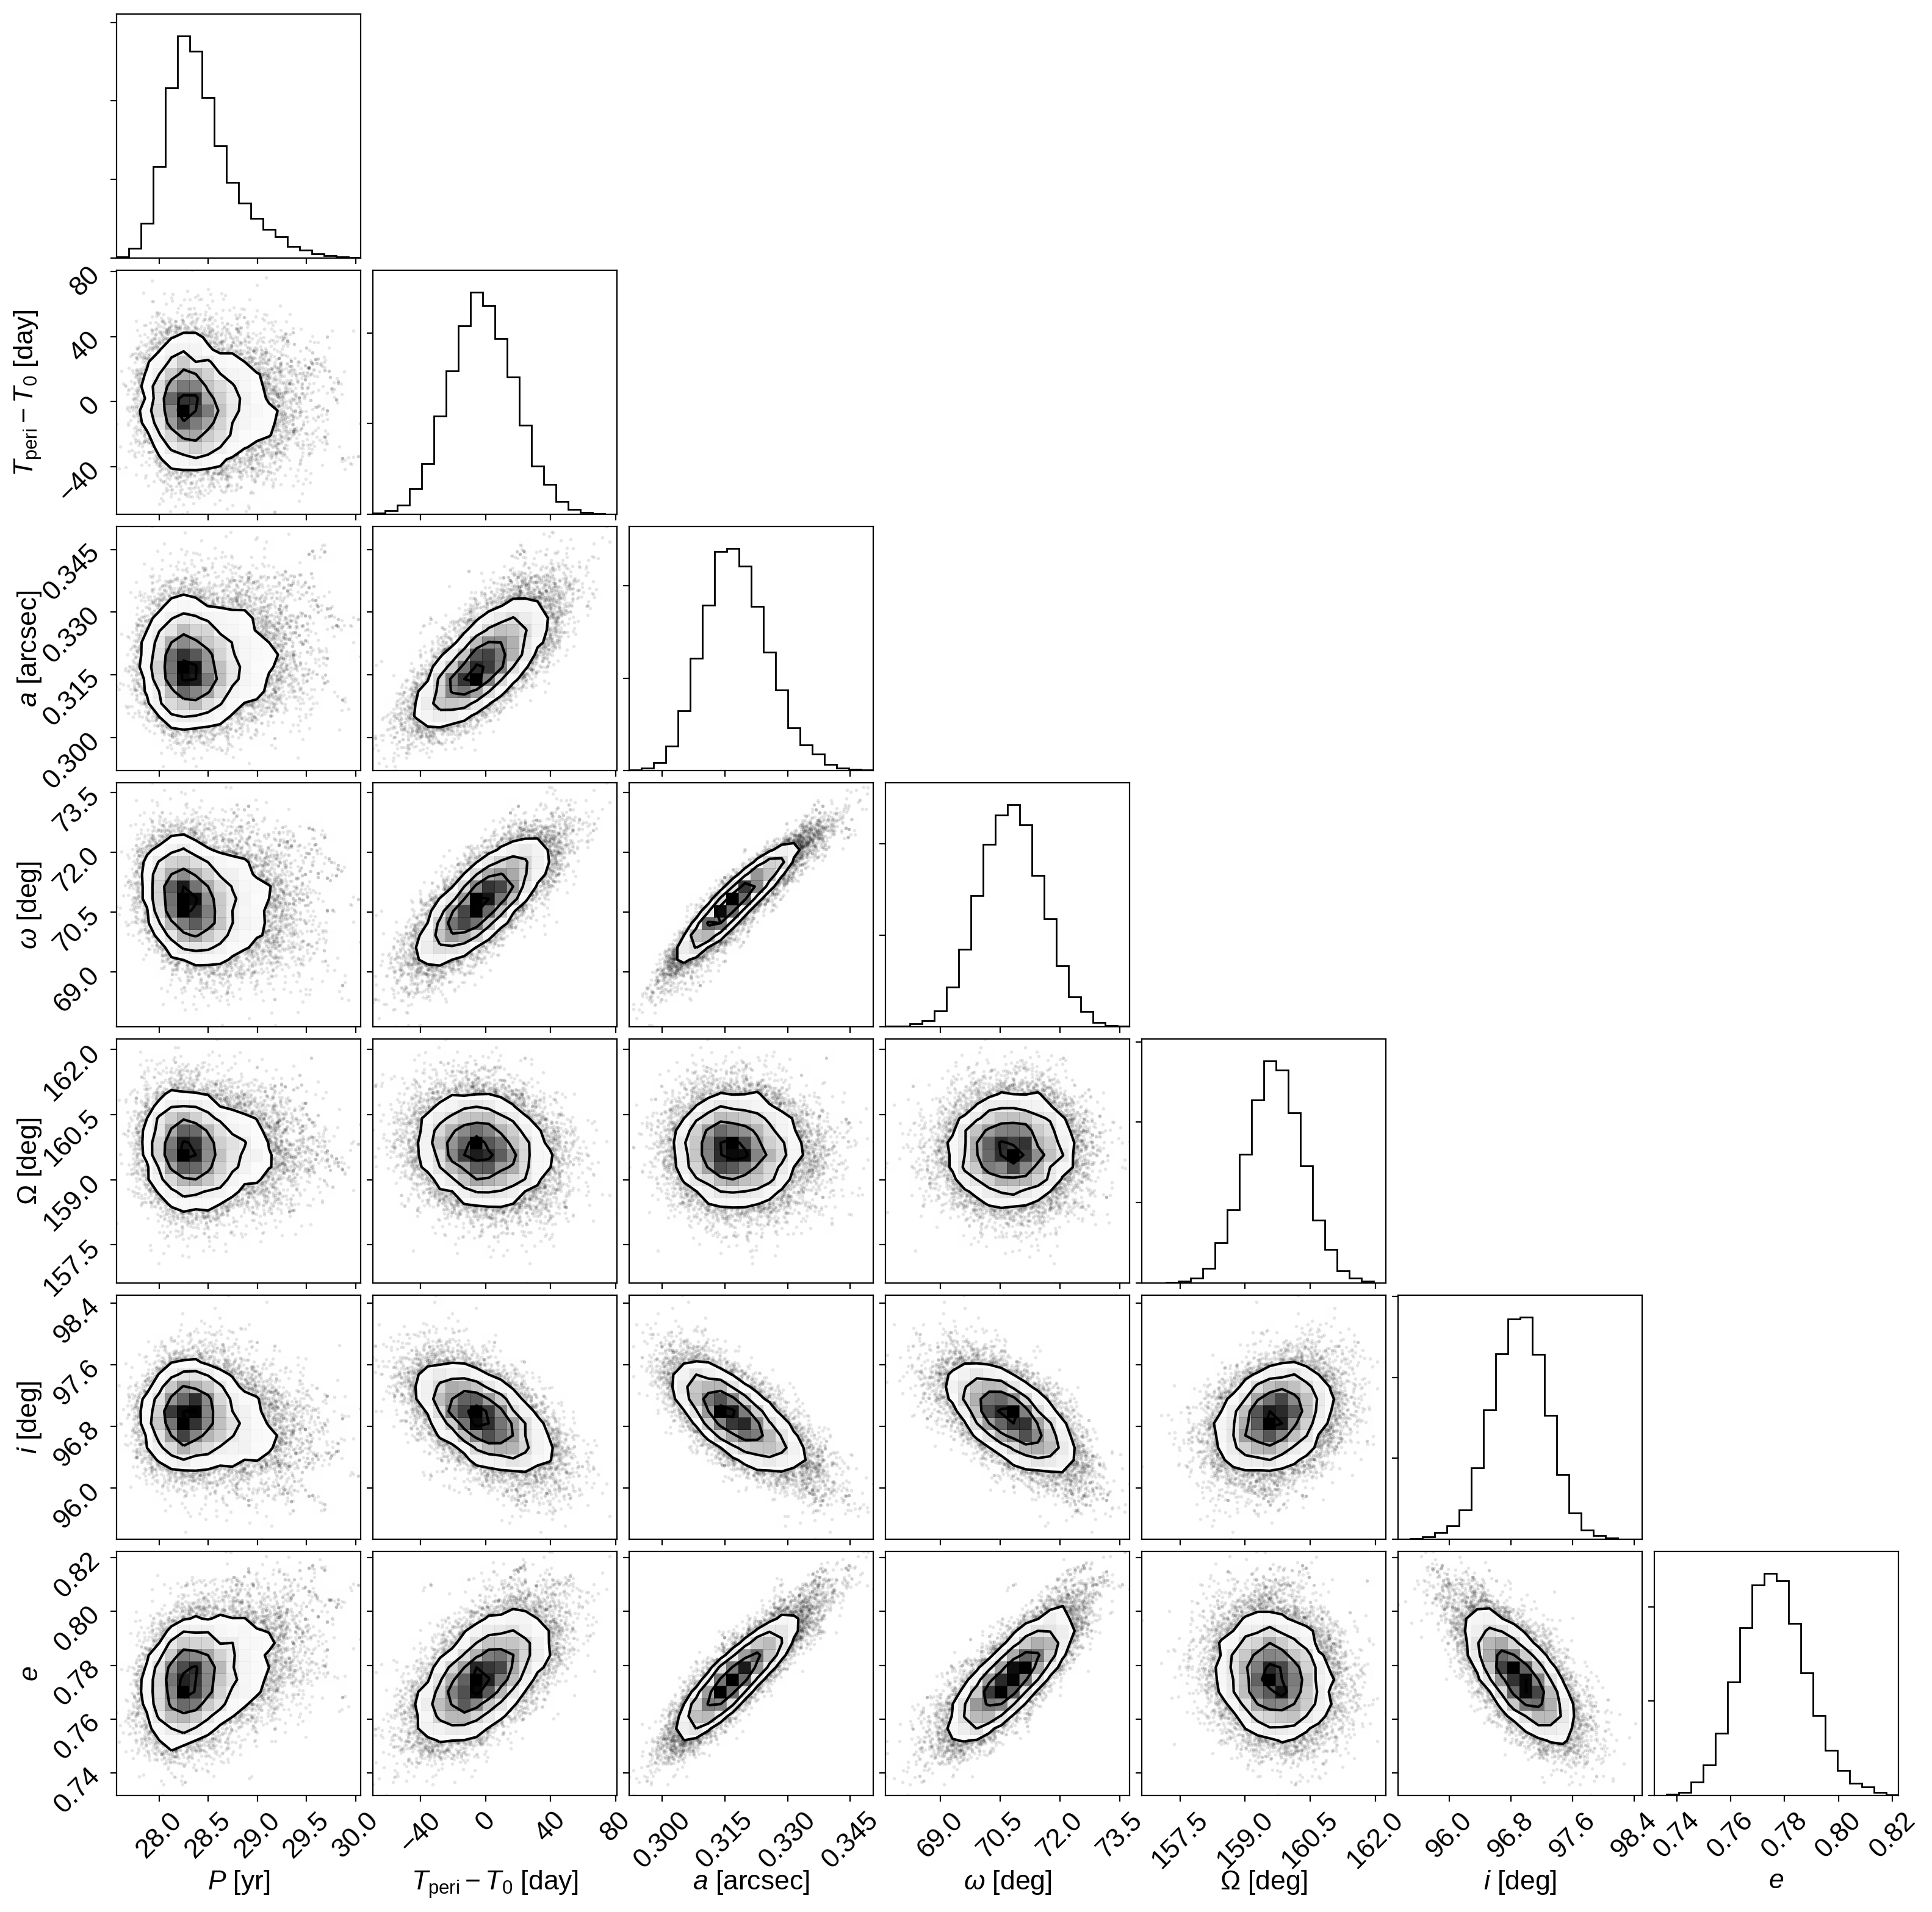

In [12]:
import corner
samples = pm.trace_to_dataframe(trace, varnames=["ecc"])
samples["$P$ [yr]"] = trace["P"] / yr
samples["$T_\mathrm{peri} - T_0$ [day]"] = trace["tperi"] - T0
samples["$a$ [arcsec]"] = trace["a_ang"]
samples["$\omega$ [deg]"] = (trace["omega"] / deg) % 360
samples["$\Omega$ [deg]"] = (trace["Omega"] / deg) % 360
samples["$i$ [deg]"] = (trace["incl"] / deg) % 360
samples["$e$"] = samples["ecc"]
del samples["ecc"]
corner.corner(samples);

Finally, we can plot the posterior constraints on $\rho$ and $\theta$.
This figure is much like the one for the MAP solution above, but this time the orange is a contour (not a line) showing the 68% credible region for the model.

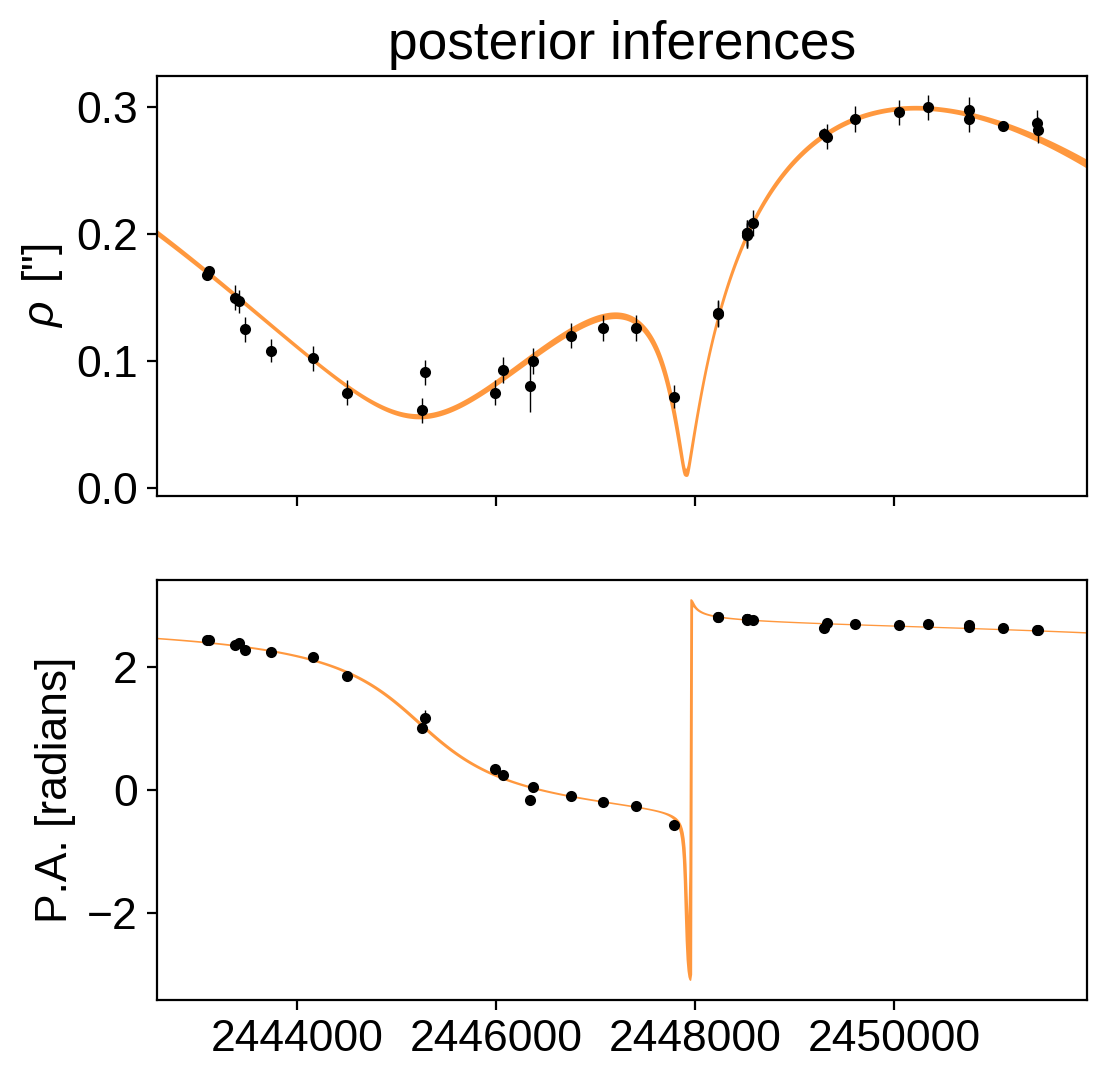

In [13]:
ekw = dict(fmt=".k", lw=0.5)

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r'P.A. [radians]')

tot_rho_err = np.sqrt(rho_err**2 + np.exp(2 * np.median(trace["log_rho_s"], axis=0)))
tot_theta_err = np.sqrt(theta_err**2 + np.exp(2 * np.median(trace["log_theta_s"], axis=0)))

ax[0].errorbar(astro_jds, rho_data, yerr=tot_rho_err, **ekw)
q = np.percentile(trace["rho_save"], [16, 84], axis=0)
ax[0].fill_between(t_fine, q[0], q[1], color="C1", alpha=0.8, lw=0)

ax[1].errorbar(astro_jds, theta_data, yerr=tot_theta_err, **ekw)
q = np.percentile(trace["theta_save"], [16, 84], axis=0)
ax[1].fill_between(t_fine, q[0], q[1], color="C1", alpha=0.8, lw=0)

ax[-1].set_xlim(t_fine[0], t_fine[-1])
ax[0].set_title("posterior inferences");

As we can see from the narrow range of orbits (the orange swath appears like a thin line), the orbit is actually highly constrained by the astrometry.
We also see two outlier epochs in the vicinity of 2445000 - 2447000, since adjacent epochs seem to be right on the orbit.
It's likely the uncertainties were not estimated correctly for these, and the simlplistic jitter model we implemented isn't sophisticated to apply more weight to only these discrepant points.

## Including parallax

While this is encouraging that we fit an astrometric orbit, a simple astrometric fit to just $\rho$ and $\theta$ isn't actually that physically satisfying, since many of the orbital parameters simply have to do with the orientation relative to us ($i$, $\omega$, and $\Omega$). The only truely intrinsic parameters are $P$ and $e$. To learn more about some of the physical parameters, such as the total mass of the system, we'd like to incorporate distance information to put a physical scale to the problem. 

The *Gaia* DR2 parallax is $\varpi = 24.05 \pm 0.45$ mas.

We can use exactly the same model as above with only an added parallax constraint:

In [14]:
plx_model, plx_map_soln = get_model(parallax=[24.05, 0.45])

optimizing logp for variables: ['log_theta_s', 'log_rho_s']


message: Optimization terminated successfully.
logp: 107.6401502957619 -> 149.92860106268094


optimizing logp for variables: ['phase_angle__']


message: Optimization terminated successfully.
logp: 149.92860106268094 -> 170.426815184602


optimizing logp for variables: ['ecc_interval__', 'm_angle__', 'p_angle__']


message: Optimization terminated successfully.
logp: 170.426815184602 -> 212.84801588560703


optimizing logp for variables: ['phase_angle__', 'a_ang_interval__', 'logP']


message: Optimization terminated successfully.
logp: 212.84801588560703 -> 213.28597909410678


optimizing logp for variables: ['log_theta_s', 'log_rho_s', 'ecc_interval__', 'cos_incl_interval__', 'phase_angle__', 'm_angle__', 'p_angle__', 'logP', 'a_ang_interval__', 'm_plx_interval__']


message: Optimization terminated successfully.
logp: 213.28597909410678 -> 217.80586833502502


In [15]:
np.random.seed(5432)
with plx_model:
    plx_trace = pm.sample(tune=5000, draws=4000, start=plx_map_soln,
                          step=xo.get_dense_nuts_step(target_accept=0.9, start=plx_map_soln))

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang, m_plx]


Sampling 4 chains:   0%|          | 0/36000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 14/36000 [00:00<05:06, 117.46draws/s]

Sampling 4 chains:   0%|          | 21/36000 [00:00<06:55, 86.66draws/s] 

Sampling 4 chains:   0%|          | 26/36000 [00:00<09:09, 65.44draws/s]

Sampling 4 chains:   0%|          | 33/36000 [00:00<09:29, 63.17draws/s]

Sampling 4 chains:   0%|          | 39/36000 [00:00<10:37, 56.39draws/s]

Sampling 4 chains:   0%|          | 44/36000 [00:00<11:13, 53.39draws/s]

Sampling 4 chains:   0%|          | 50/36000 [00:00<10:55, 54.85draws/s]

Sampling 4 chains:   0%|          | 56/36000 [00:00<11:40, 51.30draws/s]

Sampling 4 chains:   0%|          | 62/36000 [00:01<11:25, 52.41draws/s]

Sampling 4 chains:   0%|          | 68/36000 [00:01<11:40, 51.26draws/s]

Sampling 4 chains:   0%|          | 76/36000 [00:01<11:58, 50.03draws/s]

Sampling 4 chains:   0%|          | 85/36000 [00:01<10:37, 56.37draws/s]

Sampling 4 chains:   0%|          | 91/36000 [00:01<11:08, 53.70draws/s]

Sampling 4 chains:   0%|          | 97/36000 [00:01<11:06, 53.89draws/s]

Sampling 4 chains:   0%|          | 105/36000 [00:01<10:17, 58.08draws/s]

Sampling 4 chains:   0%|          | 111/36000 [00:01<10:12, 58.59draws/s]

Sampling 4 chains:   0%|          | 119/36000 [00:02<09:23, 63.67draws/s]

Sampling 4 chains:   0%|          | 126/36000 [00:02<09:31, 62.75draws/s]

Sampling 4 chains:   0%|          | 133/36000 [00:02<09:55, 60.19draws/s]

Sampling 4 chains:   0%|          | 140/36000 [00:02<10:45, 55.52draws/s]

Sampling 4 chains:   0%|          | 148/36000 [00:02<10:00, 59.71draws/s]

Sampling 4 chains:   0%|          | 155/36000 [00:02<10:46, 55.43draws/s]

Sampling 4 chains:   0%|          | 162/36000 [00:02<11:36, 51.44draws/s]

Sampling 4 chains:   0%|          | 170/36000 [00:02<11:17, 52.90draws/s]

Sampling 4 chains:   0%|          | 176/36000 [00:03<10:59, 54.33draws/s]

Sampling 4 chains:   1%|          | 183/36000 [00:03<11:48, 50.53draws/s]

Sampling 4 chains:   1%|          | 191/36000 [00:03<12:07, 49.24draws/s]

Sampling 4 chains:   1%|          | 199/36000 [00:03<10:53, 54.77draws/s]

Sampling 4 chains:   1%|          | 205/36000 [00:03<11:55, 50.00draws/s]

Sampling 4 chains:   1%|          | 212/36000 [00:03<11:25, 52.22draws/s]

Sampling 4 chains:   1%|          | 218/36000 [00:03<11:17, 52.85draws/s]

Sampling 4 chains:   1%|          | 224/36000 [00:04<11:23, 52.34draws/s]

Sampling 4 chains:   1%|          | 230/36000 [00:04<11:22, 52.39draws/s]

Sampling 4 chains:   1%|          | 236/36000 [00:04<11:52, 50.17draws/s]

Sampling 4 chains:   1%|          | 242/36000 [00:04<11:30, 51.78draws/s]

Sampling 4 chains:   1%|          | 248/36000 [00:04<11:15, 52.91draws/s]

Sampling 4 chains:   1%|          | 254/36000 [00:04<10:51, 54.83draws/s]

Sampling 4 chains:   1%|          | 261/36000 [00:04<11:11, 53.23draws/s]

Sampling 4 chains:   1%|          | 267/36000 [00:04<10:59, 54.22draws/s]

Sampling 4 chains:   1%|          | 274/36000 [00:04<10:47, 55.20draws/s]

Sampling 4 chains:   1%|          | 280/36000 [00:05<10:35, 56.17draws/s]

Sampling 4 chains:   1%|          | 289/36000 [00:05<09:33, 62.25draws/s]

Sampling 4 chains:   1%|          | 296/36000 [00:05<10:08, 58.66draws/s]

Sampling 4 chains:   1%|          | 303/36000 [00:05<09:41, 61.41draws/s]

Sampling 4 chains:   1%|          | 310/36000 [00:05<10:29, 56.70draws/s]

Sampling 4 chains:   1%|          | 317/36000 [00:05<10:06, 58.85draws/s]

Sampling 4 chains:   1%|          | 324/36000 [00:05<10:38, 55.92draws/s]

Sampling 4 chains:   1%|          | 331/36000 [00:05<10:22, 57.27draws/s]

Sampling 4 chains:   1%|          | 338/36000 [00:05<09:49, 60.54draws/s]

Sampling 4 chains:   1%|          | 345/36000 [00:06<10:42, 55.45draws/s]

Sampling 4 chains:   1%|          | 354/36000 [00:06<10:29, 56.63draws/s]

Sampling 4 chains:   1%|          | 361/36000 [00:06<10:03, 59.02draws/s]

Sampling 4 chains:   1%|          | 368/36000 [00:06<10:10, 58.38draws/s]

Sampling 4 chains:   1%|          | 375/36000 [00:06<09:43, 61.08draws/s]

Sampling 4 chains:   1%|          | 382/36000 [00:06<09:52, 60.07draws/s]

Sampling 4 chains:   1%|          | 391/36000 [00:06<08:55, 66.49draws/s]

Sampling 4 chains:   1%|          | 398/36000 [00:07<10:07, 58.56draws/s]

Sampling 4 chains:   1%|          | 405/36000 [00:07<09:45, 60.82draws/s]

Sampling 4 chains:   1%|          | 412/36000 [00:07<10:48, 54.91draws/s]

Sampling 4 chains:   1%|          | 419/36000 [00:07<10:30, 56.43draws/s]

Sampling 4 chains:   1%|          | 429/36000 [00:07<09:13, 64.26draws/s]

Sampling 4 chains:   1%|          | 442/36000 [00:07<07:52, 75.27draws/s]

Sampling 4 chains:   1%|▏         | 473/36000 [00:07<06:06, 97.02draws/s]

Sampling 4 chains:   1%|▏         | 508/36000 [00:07<04:47, 123.42draws/s]

Sampling 4 chains:   2%|▏         | 541/36000 [00:07<03:54, 151.23draws/s]

Sampling 4 chains:   2%|▏         | 570/36000 [00:08<03:21, 176.23draws/s]

Sampling 4 chains:   2%|▏         | 606/36000 [00:08<02:50, 207.57draws/s]

Sampling 4 chains:   2%|▏         | 643/36000 [00:08<02:29, 237.18draws/s]

Sampling 4 chains:   2%|▏         | 682/36000 [00:08<02:11, 268.56draws/s]

Sampling 4 chains:   2%|▏         | 729/36000 [00:08<01:54, 308.17draws/s]

Sampling 4 chains:   2%|▏         | 785/36000 [00:08<01:39, 355.57draws/s]

Sampling 4 chains:   2%|▏         | 843/36000 [00:08<01:27, 401.51draws/s]

Sampling 4 chains:   2%|▏         | 896/36000 [00:08<01:21, 431.37draws/s]

Sampling 4 chains:   3%|▎         | 948/36000 [00:08<01:17, 452.62draws/s]

Sampling 4 chains:   3%|▎         | 998/36000 [00:08<01:16, 458.58draws/s]

Sampling 4 chains:   3%|▎         | 1047/36000 [00:09<01:16, 454.91draws/s]

Sampling 4 chains:   3%|▎         | 1095/36000 [00:09<01:15, 459.46draws/s]

Sampling 4 chains:   3%|▎         | 1143/36000 [00:09<01:18, 445.60draws/s]

Sampling 4 chains:   3%|▎         | 1191/36000 [00:09<01:16, 454.99draws/s]

Sampling 4 chains:   3%|▎         | 1241/36000 [00:09<01:14, 465.88draws/s]

Sampling 4 chains:   4%|▎         | 1289/36000 [00:09<01:21, 428.11draws/s]

Sampling 4 chains:   4%|▎         | 1335/36000 [00:09<01:19, 435.27draws/s]

Sampling 4 chains:   4%|▍         | 1383/36000 [00:09<01:18, 443.67draws/s]

Sampling 4 chains:   4%|▍         | 1428/36000 [00:09<01:19, 434.36draws/s]

Sampling 4 chains:   4%|▍         | 1476/36000 [00:09<01:17, 446.69draws/s]

Sampling 4 chains:   4%|▍         | 1527/36000 [00:10<01:14, 461.81draws/s]

Sampling 4 chains:   4%|▍         | 1574/36000 [00:10<01:16, 451.47draws/s]

Sampling 4 chains:   5%|▍         | 1625/36000 [00:10<01:14, 463.72draws/s]

Sampling 4 chains:   5%|▍         | 1672/36000 [00:10<01:13, 464.74draws/s]

Sampling 4 chains:   5%|▍         | 1723/36000 [00:10<01:12, 475.92draws/s]

Sampling 4 chains:   5%|▍         | 1777/36000 [00:10<01:09, 493.45draws/s]

Sampling 4 chains:   5%|▌         | 1827/36000 [00:10<01:10, 482.16draws/s]

Sampling 4 chains:   5%|▌         | 1877/36000 [00:10<01:10, 484.70draws/s]

Sampling 4 chains:   5%|▌         | 1926/36000 [00:10<01:11, 477.87draws/s]

Sampling 4 chains:   5%|▌         | 1974/36000 [00:11<01:13, 463.53draws/s]

Sampling 4 chains:   6%|▌         | 2021/36000 [00:11<01:13, 460.24draws/s]

Sampling 4 chains:   6%|▌         | 2068/36000 [00:11<01:13, 460.73draws/s]

Sampling 4 chains:   6%|▌         | 2116/36000 [00:11<01:12, 465.15draws/s]

Sampling 4 chains:   6%|▌         | 2163/36000 [00:11<01:16, 444.04draws/s]

Sampling 4 chains:   6%|▌         | 2216/36000 [00:11<01:12, 463.14draws/s]

Sampling 4 chains:   6%|▋         | 2263/36000 [00:11<01:14, 453.80draws/s]

Sampling 4 chains:   6%|▋         | 2312/36000 [00:11<01:12, 463.71draws/s]

Sampling 4 chains:   7%|▋         | 2363/36000 [00:11<01:10, 475.16draws/s]

Sampling 4 chains:   7%|▋         | 2412/36000 [00:11<01:10, 478.40draws/s]

Sampling 4 chains:   7%|▋         | 2461/36000 [00:12<01:14, 451.46draws/s]

Sampling 4 chains:   7%|▋         | 2507/36000 [00:12<01:13, 453.92draws/s]

Sampling 4 chains:   7%|▋         | 2560/36000 [00:12<01:10, 474.32draws/s]

Sampling 4 chains:   7%|▋         | 2608/36000 [00:12<01:10, 473.79draws/s]

Sampling 4 chains:   7%|▋         | 2666/36000 [00:12<01:06, 500.00draws/s]

Sampling 4 chains:   8%|▊         | 2717/36000 [00:12<01:07, 494.85draws/s]

Sampling 4 chains:   8%|▊         | 2767/36000 [00:12<01:09, 478.32draws/s]

Sampling 4 chains:   8%|▊         | 2816/36000 [00:12<01:10, 469.20draws/s]

Sampling 4 chains:   8%|▊         | 2865/36000 [00:12<01:09, 474.84draws/s]

Sampling 4 chains:   8%|▊         | 2918/36000 [00:13<01:07, 488.82draws/s]

Sampling 4 chains:   8%|▊         | 2969/36000 [00:13<01:06, 493.50draws/s]

Sampling 4 chains:   8%|▊         | 3020/36000 [00:13<01:06, 497.91draws/s]

Sampling 4 chains:   9%|▊         | 3070/36000 [00:13<01:06, 493.98draws/s]

Sampling 4 chains:   9%|▊         | 3120/36000 [00:13<01:08, 477.59draws/s]

Sampling 4 chains:   9%|▉         | 3169/36000 [00:13<01:08, 481.02draws/s]

Sampling 4 chains:   9%|▉         | 3220/36000 [00:13<01:07, 486.60draws/s]

Sampling 4 chains:   9%|▉         | 3280/36000 [00:13<01:03, 514.34draws/s]

Sampling 4 chains:   9%|▉         | 3332/36000 [00:13<01:06, 489.68draws/s]

Sampling 4 chains:   9%|▉         | 3382/36000 [00:13<01:06, 488.59draws/s]

Sampling 4 chains:  10%|▉         | 3432/36000 [00:14<01:07, 485.65draws/s]

Sampling 4 chains:  10%|▉         | 3483/36000 [00:14<01:06, 490.83draws/s]

Sampling 4 chains:  10%|▉         | 3534/36000 [00:14<01:05, 495.27draws/s]

Sampling 4 chains:  10%|▉         | 3584/36000 [00:14<01:06, 488.62draws/s]

Sampling 4 chains:  10%|█         | 3641/36000 [00:14<01:03, 509.77draws/s]

Sampling 4 chains:  10%|█         | 3693/36000 [00:14<01:03, 507.24draws/s]

Sampling 4 chains:  10%|█         | 3744/36000 [00:14<01:07, 478.83draws/s]

Sampling 4 chains:  11%|█         | 3793/36000 [00:14<01:08, 467.15draws/s]

Sampling 4 chains:  11%|█         | 3844/36000 [00:14<01:07, 477.43draws/s]

Sampling 4 chains:  11%|█         | 3893/36000 [00:15<01:09, 464.57draws/s]

Sampling 4 chains:  11%|█         | 3941/36000 [00:15<01:08, 469.08draws/s]

Sampling 4 chains:  11%|█         | 3989/36000 [00:15<01:08, 464.09draws/s]

Sampling 4 chains:  11%|█         | 4036/36000 [00:15<01:08, 465.05draws/s]

Sampling 4 chains:  11%|█▏        | 4084/36000 [00:15<01:08, 468.80draws/s]

Sampling 4 chains:  11%|█▏        | 4139/36000 [00:15<01:05, 488.98draws/s]

Sampling 4 chains:  12%|█▏        | 4189/36000 [00:15<01:07, 472.83draws/s]

Sampling 4 chains:  12%|█▏        | 4237/36000 [00:15<01:11, 447.36draws/s]

Sampling 4 chains:  12%|█▏        | 4286/36000 [00:15<01:09, 455.88draws/s]

Sampling 4 chains:  12%|█▏        | 4340/36000 [00:15<01:06, 477.04draws/s]

Sampling 4 chains:  12%|█▏        | 4395/36000 [00:16<01:04, 493.48draws/s]

Sampling 4 chains:  12%|█▏        | 4454/36000 [00:16<01:00, 517.33draws/s]

Sampling 4 chains:  13%|█▎        | 4516/36000 [00:16<00:57, 543.44draws/s]

Sampling 4 chains:  13%|█▎        | 4577/36000 [00:16<00:56, 560.55draws/s]

Sampling 4 chains:  13%|█▎        | 4634/36000 [00:16<00:58, 537.54draws/s]

Sampling 4 chains:  13%|█▎        | 4692/36000 [00:16<00:57, 545.18draws/s]

Sampling 4 chains:  13%|█▎        | 4748/36000 [00:16<00:59, 527.20draws/s]

Sampling 4 chains:  13%|█▎        | 4802/36000 [00:16<01:00, 514.80draws/s]

Sampling 4 chains:  13%|█▎        | 4858/36000 [00:16<00:59, 525.91draws/s]

Sampling 4 chains:  14%|█▎        | 4916/36000 [00:17<00:57, 539.87draws/s]

Sampling 4 chains:  14%|█▍        | 4971/36000 [00:17<01:00, 510.26draws/s]

Sampling 4 chains:  14%|█▍        | 5023/36000 [00:17<01:06, 466.44draws/s]

Sampling 4 chains:  14%|█▍        | 5071/36000 [00:17<01:05, 469.78draws/s]

Sampling 4 chains:  14%|█▍        | 5119/36000 [00:17<01:05, 471.24draws/s]

Sampling 4 chains:  14%|█▍        | 5175/36000 [00:17<01:02, 492.77draws/s]

Sampling 4 chains:  15%|█▍        | 5229/36000 [00:17<01:00, 505.07draws/s]

Sampling 4 chains:  15%|█▍        | 5281/36000 [00:17<01:03, 480.91draws/s]

Sampling 4 chains:  15%|█▍        | 5330/36000 [00:17<01:04, 475.87draws/s]

Sampling 4 chains:  15%|█▍        | 5379/36000 [00:18<01:04, 476.78draws/s]

Sampling 4 chains:  15%|█▌        | 5438/36000 [00:18<01:00, 501.24draws/s]

Sampling 4 chains:  15%|█▌        | 5493/36000 [00:18<00:59, 513.23draws/s]

Sampling 4 chains:  15%|█▌        | 5551/36000 [00:18<00:57, 529.71draws/s]

Sampling 4 chains:  16%|█▌        | 5605/36000 [00:18<01:00, 499.28draws/s]

Sampling 4 chains:  16%|█▌        | 5659/36000 [00:18<00:59, 508.50draws/s]

Sampling 4 chains:  16%|█▌        | 5711/36000 [00:18<01:02, 481.77draws/s]

Sampling 4 chains:  16%|█▌        | 5766/36000 [00:18<01:00, 500.08draws/s]

Sampling 4 chains:  16%|█▌        | 5825/36000 [00:18<00:58, 519.72draws/s]

Sampling 4 chains:  16%|█▋        | 5884/36000 [00:18<00:56, 537.70draws/s]

Sampling 4 chains:  16%|█▋        | 5939/36000 [00:19<00:57, 524.19draws/s]

Sampling 4 chains:  17%|█▋        | 5992/36000 [00:19<00:59, 505.69draws/s]

Sampling 4 chains:  17%|█▋        | 6044/36000 [00:19<01:00, 494.21draws/s]

Sampling 4 chains:  17%|█▋        | 6094/36000 [00:19<01:00, 493.39draws/s]

Sampling 4 chains:  17%|█▋        | 6146/36000 [00:19<00:59, 500.01draws/s]

Sampling 4 chains:  17%|█▋        | 6197/36000 [00:19<01:04, 463.12draws/s]

Sampling 4 chains:  17%|█▋        | 6245/36000 [00:19<01:06, 446.02draws/s]

Sampling 4 chains:  17%|█▋        | 6294/36000 [00:19<01:04, 458.00draws/s]

Sampling 4 chains:  18%|█▊        | 6350/36000 [00:19<01:01, 484.01draws/s]

Sampling 4 chains:  18%|█▊        | 6401/36000 [00:20<01:00, 490.92draws/s]

Sampling 4 chains:  18%|█▊        | 6451/36000 [00:20<01:00, 486.91draws/s]

Sampling 4 chains:  18%|█▊        | 6502/36000 [00:20<00:59, 493.39draws/s]

Sampling 4 chains:  18%|█▊        | 6552/36000 [00:20<01:01, 478.09draws/s]

Sampling 4 chains:  18%|█▊        | 6609/36000 [00:20<00:58, 500.73draws/s]

Sampling 4 chains:  18%|█▊        | 6660/36000 [00:20<01:00, 487.26draws/s]

Sampling 4 chains:  19%|█▊        | 6710/36000 [00:20<01:02, 469.90draws/s]

Sampling 4 chains:  19%|█▉        | 6762/36000 [00:20<01:00, 483.07draws/s]

Sampling 4 chains:  19%|█▉        | 6817/36000 [00:20<00:58, 500.42draws/s]

Sampling 4 chains:  19%|█▉        | 6877/36000 [00:21<00:55, 525.49draws/s]

Sampling 4 chains:  19%|█▉        | 6931/36000 [00:21<00:54, 528.65draws/s]

Sampling 4 chains:  19%|█▉        | 6985/36000 [00:21<00:54, 529.26draws/s]

Sampling 4 chains:  20%|█▉        | 7039/36000 [00:21<00:57, 500.95draws/s]

Sampling 4 chains:  20%|█▉        | 7090/36000 [00:21<00:59, 483.17draws/s]

Sampling 4 chains:  20%|█▉        | 7139/36000 [00:21<01:01, 469.58draws/s]

Sampling 4 chains:  20%|█▉        | 7187/36000 [00:21<01:01, 468.55draws/s]

Sampling 4 chains:  20%|██        | 7236/36000 [00:21<01:00, 473.05draws/s]

Sampling 4 chains:  20%|██        | 7290/36000 [00:21<00:58, 490.49draws/s]

Sampling 4 chains:  20%|██        | 7346/36000 [00:21<00:56, 508.66draws/s]

Sampling 4 chains:  21%|██        | 7400/36000 [00:22<00:55, 516.69draws/s]

Sampling 4 chains:  21%|██        | 7460/36000 [00:22<00:53, 535.99draws/s]

Sampling 4 chains:  21%|██        | 7514/36000 [00:22<00:56, 506.96draws/s]

Sampling 4 chains:  21%|██        | 7566/36000 [00:22<00:58, 485.45draws/s]

Sampling 4 chains:  21%|██        | 7616/36000 [00:22<01:00, 469.77draws/s]

Sampling 4 chains:  21%|██▏       | 7664/36000 [00:22<01:01, 460.89draws/s]

Sampling 4 chains:  21%|██▏       | 7715/36000 [00:22<00:59, 473.96draws/s]

Sampling 4 chains:  22%|██▏       | 7763/36000 [00:22<00:59, 470.99draws/s]

Sampling 4 chains:  22%|██▏       | 7815/36000 [00:22<00:58, 484.36draws/s]

Sampling 4 chains:  22%|██▏       | 7870/36000 [00:23<00:56, 500.36draws/s]

Sampling 4 chains:  22%|██▏       | 7922/36000 [00:23<00:55, 505.48draws/s]

Sampling 4 chains:  22%|██▏       | 7976/36000 [00:23<00:54, 514.30draws/s]

Sampling 4 chains:  22%|██▏       | 8031/36000 [00:23<00:53, 523.82draws/s]

Sampling 4 chains:  22%|██▏       | 8084/36000 [00:23<00:54, 512.58draws/s]

Sampling 4 chains:  23%|██▎       | 8141/36000 [00:23<00:53, 525.34draws/s]

Sampling 4 chains:  23%|██▎       | 8194/36000 [00:23<00:55, 504.85draws/s]

Sampling 4 chains:  23%|██▎       | 8245/36000 [00:23<00:54, 505.62draws/s]

Sampling 4 chains:  23%|██▎       | 8310/36000 [00:23<00:51, 540.73draws/s]

Sampling 4 chains:  23%|██▎       | 8366/36000 [00:23<00:50, 545.87draws/s]

Sampling 4 chains:  23%|██▎       | 8422/36000 [00:24<00:50, 548.71draws/s]

Sampling 4 chains:  24%|██▎       | 8478/36000 [00:24<00:52, 522.14draws/s]

Sampling 4 chains:  24%|██▎       | 8531/36000 [00:24<00:55, 492.61draws/s]

Sampling 4 chains:  24%|██▍       | 8590/36000 [00:24<00:53, 515.48draws/s]

Sampling 4 chains:  24%|██▍       | 8643/36000 [00:24<00:53, 509.50draws/s]

Sampling 4 chains:  24%|██▍       | 8695/36000 [00:24<00:55, 488.99draws/s]

Sampling 4 chains:  24%|██▍       | 8750/36000 [00:24<00:53, 505.56draws/s]

Sampling 4 chains:  24%|██▍       | 8802/36000 [00:24<00:56, 479.47draws/s]

Sampling 4 chains:  25%|██▍       | 8851/36000 [00:24<00:57, 475.37draws/s]

Sampling 4 chains:  25%|██▍       | 8905/36000 [00:25<00:55, 492.33draws/s]

Sampling 4 chains:  25%|██▍       | 8966/36000 [00:25<00:51, 520.54draws/s]

Sampling 4 chains:  25%|██▌       | 9021/36000 [00:25<00:51, 528.76draws/s]

Sampling 4 chains:  25%|██▌       | 9075/36000 [00:25<00:53, 504.67draws/s]

Sampling 4 chains:  25%|██▌       | 9127/36000 [00:25<00:52, 507.35draws/s]

Sampling 4 chains:  26%|██▌       | 9182/36000 [00:25<00:51, 517.06draws/s]

Sampling 4 chains:  26%|██▌       | 9235/36000 [00:25<00:51, 515.43draws/s]

Sampling 4 chains:  26%|██▌       | 9292/36000 [00:25<00:50, 530.27draws/s]

Sampling 4 chains:  26%|██▌       | 9346/36000 [00:25<00:50, 532.51draws/s]

Sampling 4 chains:  26%|██▌       | 9400/36000 [00:25<00:51, 520.21draws/s]

Sampling 4 chains:  26%|██▋       | 9453/36000 [00:26<00:52, 506.67draws/s]

Sampling 4 chains:  26%|██▋       | 9504/36000 [00:26<00:53, 499.75draws/s]

Sampling 4 chains:  27%|██▋       | 9555/36000 [00:26<00:54, 487.39draws/s]

Sampling 4 chains:  27%|██▋       | 9604/36000 [00:26<00:55, 476.56draws/s]

Sampling 4 chains:  27%|██▋       | 9655/36000 [00:26<00:54, 484.28draws/s]

Sampling 4 chains:  27%|██▋       | 9704/36000 [00:26<00:57, 457.55draws/s]

Sampling 4 chains:  27%|██▋       | 9752/36000 [00:26<00:56, 461.40draws/s]

Sampling 4 chains:  27%|██▋       | 9801/36000 [00:26<00:55, 469.58draws/s]

Sampling 4 chains:  27%|██▋       | 9849/36000 [00:26<00:55, 467.02draws/s]

Sampling 4 chains:  27%|██▋       | 9896/36000 [00:27<00:56, 460.59draws/s]

Sampling 4 chains:  28%|██▊       | 9943/36000 [00:27<00:59, 437.74draws/s]

Sampling 4 chains:  28%|██▊       | 9988/36000 [00:27<01:00, 432.54draws/s]

Sampling 4 chains:  28%|██▊       | 10044/36000 [00:27<00:56, 458.64draws/s]

Sampling 4 chains:  28%|██▊       | 10097/36000 [00:27<00:54, 477.68draws/s]

Sampling 4 chains:  28%|██▊       | 10153/36000 [00:27<00:52, 496.69draws/s]

Sampling 4 chains:  28%|██▊       | 10204/36000 [00:27<00:53, 483.83draws/s]

Sampling 4 chains:  28%|██▊       | 10253/36000 [00:27<00:54, 473.86draws/s]

Sampling 4 chains:  29%|██▊       | 10301/36000 [00:27<00:55, 461.09draws/s]

Sampling 4 chains:  29%|██▉       | 10352/36000 [00:28<00:54, 473.37draws/s]

Sampling 4 chains:  29%|██▉       | 10400/36000 [00:28<00:54, 471.15draws/s]

Sampling 4 chains:  29%|██▉       | 10459/36000 [00:28<00:51, 499.66draws/s]

Sampling 4 chains:  29%|██▉       | 10511/36000 [00:28<00:50, 505.17draws/s]

Sampling 4 chains:  29%|██▉       | 10562/36000 [00:28<00:50, 502.04draws/s]

Sampling 4 chains:  29%|██▉       | 10613/36000 [00:28<00:50, 502.49draws/s]

Sampling 4 chains:  30%|██▉       | 10669/36000 [00:28<00:48, 517.28draws/s]

Sampling 4 chains:  30%|██▉       | 10721/36000 [00:28<00:49, 511.17draws/s]

Sampling 4 chains:  30%|██▉       | 10773/36000 [00:28<00:49, 511.76draws/s]

Sampling 4 chains:  30%|███       | 10825/36000 [00:28<00:50, 494.10draws/s]

Sampling 4 chains:  30%|███       | 10875/36000 [00:29<00:51, 483.61draws/s]

Sampling 4 chains:  30%|███       | 10924/36000 [00:29<00:52, 475.31draws/s]

Sampling 4 chains:  30%|███       | 10973/36000 [00:29<00:52, 479.60draws/s]

Sampling 4 chains:  31%|███       | 11034/36000 [00:29<00:48, 511.18draws/s]

Sampling 4 chains:  31%|███       | 11086/36000 [00:29<00:50, 491.98draws/s]

Sampling 4 chains:  31%|███       | 11136/36000 [00:29<00:53, 465.11draws/s]

Sampling 4 chains:  31%|███       | 11192/36000 [00:29<00:50, 489.33draws/s]

Sampling 4 chains:  31%|███       | 11245/36000 [00:29<00:49, 499.90draws/s]

Sampling 4 chains:  31%|███▏      | 11298/36000 [00:29<00:48, 506.16draws/s]

Sampling 4 chains:  32%|███▏      | 11350/36000 [00:30<00:49, 498.97draws/s]

Sampling 4 chains:  32%|███▏      | 11401/36000 [00:30<00:49, 494.37draws/s]

Sampling 4 chains:  32%|███▏      | 11451/36000 [00:30<00:49, 494.80draws/s]

Sampling 4 chains:  32%|███▏      | 11509/36000 [00:30<00:47, 515.77draws/s]

Sampling 4 chains:  32%|███▏      | 11562/36000 [00:30<00:47, 519.17draws/s]

Sampling 4 chains:  32%|███▏      | 11615/36000 [00:30<00:50, 484.83draws/s]

Sampling 4 chains:  32%|███▏      | 11665/36000 [00:30<00:50, 479.95draws/s]

Sampling 4 chains:  33%|███▎      | 11718/36000 [00:30<00:49, 491.21draws/s]

Sampling 4 chains:  33%|███▎      | 11778/36000 [00:30<00:46, 517.83draws/s]

Sampling 4 chains:  33%|███▎      | 11832/36000 [00:30<00:46, 522.32draws/s]

Sampling 4 chains:  33%|███▎      | 11885/36000 [00:31<00:46, 519.16draws/s]

Sampling 4 chains:  33%|███▎      | 11954/36000 [00:31<00:43, 556.58draws/s]

Sampling 4 chains:  33%|███▎      | 12011/36000 [00:31<00:43, 547.98draws/s]

Sampling 4 chains:  34%|███▎      | 12067/36000 [00:31<00:45, 530.67draws/s]

Sampling 4 chains:  34%|███▎      | 12122/36000 [00:31<00:44, 534.82draws/s]

Sampling 4 chains:  34%|███▍      | 12176/36000 [00:31<00:44, 531.56draws/s]

Sampling 4 chains:  34%|███▍      | 12230/36000 [00:31<00:46, 508.76draws/s]

Sampling 4 chains:  34%|███▍      | 12282/36000 [00:31<00:48, 487.08draws/s]

Sampling 4 chains:  34%|███▍      | 12332/36000 [00:31<00:49, 479.06draws/s]

Sampling 4 chains:  34%|███▍      | 12381/36000 [00:32<00:49, 476.23draws/s]

Sampling 4 chains:  35%|███▍      | 12429/36000 [00:32<00:50, 462.23draws/s]

Sampling 4 chains:  35%|███▍      | 12476/36000 [00:32<00:51, 459.79draws/s]

Sampling 4 chains:  35%|███▍      | 12523/36000 [00:32<00:51, 457.75draws/s]

Sampling 4 chains:  35%|███▍      | 12569/36000 [00:32<00:51, 453.44draws/s]

Sampling 4 chains:  35%|███▌      | 12615/36000 [00:32<00:51, 453.18draws/s]

Sampling 4 chains:  35%|███▌      | 12673/36000 [00:32<00:48, 481.65draws/s]

Sampling 4 chains:  35%|███▌      | 12727/36000 [00:32<00:46, 497.02draws/s]

Sampling 4 chains:  35%|███▌      | 12778/36000 [00:32<00:46, 499.10draws/s]

Sampling 4 chains:  36%|███▌      | 12829/36000 [00:32<00:46, 495.14draws/s]

Sampling 4 chains:  36%|███▌      | 12883/36000 [00:33<00:45, 505.84draws/s]

Sampling 4 chains:  36%|███▌      | 12934/36000 [00:33<00:45, 505.91draws/s]

Sampling 4 chains:  36%|███▌      | 12985/36000 [00:33<00:45, 506.15draws/s]

Sampling 4 chains:  36%|███▌      | 13036/36000 [00:33<00:48, 478.19draws/s]

Sampling 4 chains:  36%|███▋      | 13085/36000 [00:33<00:48, 472.88draws/s]

Sampling 4 chains:  36%|███▋      | 13136/36000 [00:33<00:47, 478.45draws/s]

Sampling 4 chains:  37%|███▋      | 13189/36000 [00:33<00:46, 491.36draws/s]

Sampling 4 chains:  37%|███▋      | 13239/36000 [00:33<00:48, 467.01draws/s]

Sampling 4 chains:  37%|███▋      | 13291/36000 [00:33<00:47, 480.97draws/s]

Sampling 4 chains:  37%|███▋      | 13349/36000 [00:34<00:44, 505.46draws/s]

Sampling 4 chains:  37%|███▋      | 13402/36000 [00:34<00:44, 510.96draws/s]

Sampling 4 chains:  37%|███▋      | 13454/36000 [00:34<00:47, 477.27draws/s]

Sampling 4 chains:  38%|███▊      | 13503/36000 [00:34<00:47, 469.64draws/s]

Sampling 4 chains:  38%|███▊      | 13553/36000 [00:34<00:47, 476.33draws/s]

Sampling 4 chains:  38%|███▊      | 13602/36000 [00:34<00:46, 478.28draws/s]

Sampling 4 chains:  38%|███▊      | 13652/36000 [00:34<00:46, 483.20draws/s]

Sampling 4 chains:  38%|███▊      | 13707/36000 [00:34<00:45, 493.69draws/s]

Sampling 4 chains:  38%|███▊      | 13757/36000 [00:34<00:45, 489.61draws/s]

Sampling 4 chains:  38%|███▊      | 13809/36000 [00:34<00:44, 498.25draws/s]

Sampling 4 chains:  39%|███▊      | 13861/36000 [00:35<00:43, 503.37draws/s]

Sampling 4 chains:  39%|███▊      | 13916/36000 [00:35<00:42, 515.60draws/s]

Sampling 4 chains:  39%|███▉      | 13968/36000 [00:35<00:43, 503.57draws/s]

Sampling 4 chains:  39%|███▉      | 14026/36000 [00:35<00:42, 522.75draws/s]

Sampling 4 chains:  39%|███▉      | 14079/36000 [00:35<00:41, 522.79draws/s]

Sampling 4 chains:  39%|███▉      | 14135/36000 [00:35<00:41, 531.23draws/s]

Sampling 4 chains:  39%|███▉      | 14189/36000 [00:35<00:41, 520.24draws/s]

Sampling 4 chains:  40%|███▉      | 14243/36000 [00:35<00:41, 524.97draws/s]

Sampling 4 chains:  40%|███▉      | 14296/36000 [00:35<00:42, 514.37draws/s]

Sampling 4 chains:  40%|███▉      | 14349/36000 [00:36<00:41, 517.05draws/s]

Sampling 4 chains:  40%|████      | 14406/36000 [00:36<00:40, 531.86draws/s]

Sampling 4 chains:  40%|████      | 14460/36000 [00:36<00:40, 527.47draws/s]

Sampling 4 chains:  40%|████      | 14513/36000 [00:36<00:41, 512.91draws/s]

Sampling 4 chains:  40%|████      | 14566/36000 [00:36<00:41, 515.89draws/s]

Sampling 4 chains:  41%|████      | 14622/36000 [00:36<00:40, 527.20draws/s]

Sampling 4 chains:  41%|████      | 14679/36000 [00:36<00:39, 538.33draws/s]

Sampling 4 chains:  41%|████      | 14733/36000 [00:36<00:39, 532.12draws/s]

Sampling 4 chains:  41%|████      | 14787/36000 [00:36<00:40, 526.75draws/s]

Sampling 4 chains:  41%|████      | 14841/36000 [00:36<00:39, 529.98draws/s]

Sampling 4 chains:  41%|████▏     | 14895/36000 [00:37<00:40, 524.66draws/s]

Sampling 4 chains:  42%|████▏     | 14948/36000 [00:37<00:41, 508.68draws/s]

Sampling 4 chains:  42%|████▏     | 15004/36000 [00:37<00:40, 522.70draws/s]

Sampling 4 chains:  42%|████▏     | 15058/36000 [00:37<00:39, 527.11draws/s]

Sampling 4 chains:  42%|████▏     | 15111/36000 [00:37<00:40, 515.16draws/s]

Sampling 4 chains:  42%|████▏     | 15164/36000 [00:37<00:40, 517.02draws/s]

Sampling 4 chains:  42%|████▏     | 15216/36000 [00:37<00:40, 516.47draws/s]

Sampling 4 chains:  42%|████▏     | 15268/36000 [00:37<00:40, 509.71draws/s]

Sampling 4 chains:  43%|████▎     | 15325/36000 [00:37<00:39, 521.74draws/s]

Sampling 4 chains:  43%|████▎     | 15379/36000 [00:37<00:39, 522.32draws/s]

Sampling 4 chains:  43%|████▎     | 15432/36000 [00:38<00:40, 513.85draws/s]

Sampling 4 chains:  43%|████▎     | 15484/36000 [00:38<00:40, 510.71draws/s]

Sampling 4 chains:  43%|████▎     | 15536/36000 [00:38<00:41, 496.11draws/s]

Sampling 4 chains:  43%|████▎     | 15586/36000 [00:38<00:41, 493.89draws/s]

Sampling 4 chains:  43%|████▎     | 15646/36000 [00:38<00:39, 520.80draws/s]

Sampling 4 chains:  44%|████▎     | 15701/36000 [00:38<00:38, 528.37draws/s]

Sampling 4 chains:  44%|████▍     | 15761/36000 [00:38<00:36, 547.67draws/s]

Sampling 4 chains:  44%|████▍     | 15817/36000 [00:38<00:36, 549.96draws/s]

Sampling 4 chains:  44%|████▍     | 15873/36000 [00:38<00:38, 518.87draws/s]

Sampling 4 chains:  44%|████▍     | 15926/36000 [00:39<00:40, 499.03draws/s]

Sampling 4 chains:  44%|████▍     | 15977/36000 [00:39<00:42, 467.00draws/s]

Sampling 4 chains:  45%|████▍     | 16031/36000 [00:39<00:41, 482.00draws/s]

Sampling 4 chains:  45%|████▍     | 16084/36000 [00:39<00:40, 493.12draws/s]

Sampling 4 chains:  45%|████▍     | 16140/36000 [00:39<00:38, 510.49draws/s]

Sampling 4 chains:  45%|████▍     | 16194/36000 [00:39<00:38, 518.44draws/s]

Sampling 4 chains:  45%|████▌     | 16247/36000 [00:39<00:37, 521.79draws/s]

Sampling 4 chains:  45%|████▌     | 16303/36000 [00:39<00:36, 532.47draws/s]

Sampling 4 chains:  45%|████▌     | 16357/36000 [00:39<00:39, 499.79draws/s]

Sampling 4 chains:  46%|████▌     | 16409/36000 [00:40<00:38, 502.54draws/s]

Sampling 4 chains:  46%|████▌     | 16460/36000 [00:40<00:39, 494.63draws/s]

Sampling 4 chains:  46%|████▌     | 16517/36000 [00:40<00:37, 514.56draws/s]

Sampling 4 chains:  46%|████▌     | 16572/36000 [00:40<00:37, 523.81draws/s]

Sampling 4 chains:  46%|████▌     | 16626/36000 [00:40<00:36, 526.29draws/s]

Sampling 4 chains:  46%|████▋     | 16679/36000 [00:40<00:36, 522.91draws/s]

Sampling 4 chains:  46%|████▋     | 16732/36000 [00:40<00:36, 522.07draws/s]

Sampling 4 chains:  47%|████▋     | 16785/36000 [00:40<00:37, 510.89draws/s]

Sampling 4 chains:  47%|████▋     | 16837/36000 [00:40<00:38, 498.51draws/s]

Sampling 4 chains:  47%|████▋     | 16891/36000 [00:40<00:37, 508.41draws/s]

Sampling 4 chains:  47%|████▋     | 16944/36000 [00:41<00:37, 512.73draws/s]

Sampling 4 chains:  47%|████▋     | 16999/36000 [00:41<00:36, 522.75draws/s]

Sampling 4 chains:  47%|████▋     | 17053/36000 [00:41<00:35, 527.24draws/s]

Sampling 4 chains:  48%|████▊     | 17106/36000 [00:41<00:37, 502.43draws/s]

Sampling 4 chains:  48%|████▊     | 17157/36000 [00:41<00:39, 481.36draws/s]

Sampling 4 chains:  48%|████▊     | 17206/36000 [00:41<00:39, 479.86draws/s]

Sampling 4 chains:  48%|████▊     | 17255/36000 [00:41<00:38, 482.12draws/s]

Sampling 4 chains:  48%|████▊     | 17313/36000 [00:41<00:37, 504.18draws/s]

Sampling 4 chains:  48%|████▊     | 17371/36000 [00:41<00:35, 523.08draws/s]

Sampling 4 chains:  48%|████▊     | 17429/36000 [00:41<00:34, 537.75draws/s]

Sampling 4 chains:  49%|████▊     | 17488/36000 [00:42<00:33, 548.23draws/s]

Sampling 4 chains:  49%|████▊     | 17544/36000 [00:42<00:33, 546.46draws/s]

Sampling 4 chains:  49%|████▉     | 17599/36000 [00:42<00:33, 542.16draws/s]

Sampling 4 chains:  49%|████▉     | 17654/36000 [00:42<00:35, 511.47draws/s]

Sampling 4 chains:  49%|████▉     | 17706/36000 [00:42<00:36, 494.73draws/s]

Sampling 4 chains:  49%|████▉     | 17756/36000 [00:42<00:37, 492.73draws/s]

Sampling 4 chains:  49%|████▉     | 17806/36000 [00:42<00:37, 487.94draws/s]

Sampling 4 chains:  50%|████▉     | 17857/36000 [00:42<00:36, 491.71draws/s]

Sampling 4 chains:  50%|████▉     | 17911/36000 [00:42<00:35, 504.35draws/s]

Sampling 4 chains:  50%|████▉     | 17974/36000 [00:43<00:33, 535.82draws/s]

Sampling 4 chains:  50%|█████     | 18030/36000 [00:43<00:33, 542.27draws/s]

Sampling 4 chains:  50%|█████     | 18086/36000 [00:43<00:32, 546.16draws/s]

Sampling 4 chains:  50%|█████     | 18141/36000 [00:43<00:35, 509.15draws/s]

Sampling 4 chains:  51%|█████     | 18195/36000 [00:43<00:34, 517.21draws/s]

Sampling 4 chains:  51%|█████     | 18249/36000 [00:43<00:34, 517.40draws/s]

Sampling 4 chains:  51%|█████     | 18307/36000 [00:43<00:33, 534.43draws/s]

Sampling 4 chains:  51%|█████     | 18361/36000 [00:43<00:33, 531.58draws/s]

Sampling 4 chains:  51%|█████     | 18415/36000 [00:43<00:33, 527.20draws/s]

Sampling 4 chains:  51%|█████▏    | 18468/36000 [00:43<00:35, 498.82draws/s]

Sampling 4 chains:  51%|█████▏    | 18519/36000 [00:44<00:35, 494.27draws/s]

Sampling 4 chains:  52%|█████▏    | 18576/36000 [00:44<00:33, 514.38draws/s]

Sampling 4 chains:  52%|█████▏    | 18628/36000 [00:44<00:34, 500.23draws/s]

Sampling 4 chains:  52%|█████▏    | 18679/36000 [00:44<00:35, 485.09draws/s]

Sampling 4 chains:  52%|█████▏    | 18728/36000 [00:44<00:35, 483.61draws/s]

Sampling 4 chains:  52%|█████▏    | 18777/36000 [00:44<00:36, 469.23draws/s]

Sampling 4 chains:  52%|█████▏    | 18825/36000 [00:44<00:38, 451.68draws/s]

Sampling 4 chains:  52%|█████▏    | 18880/36000 [00:44<00:36, 474.97draws/s]

Sampling 4 chains:  53%|█████▎    | 18929/36000 [00:44<00:36, 469.12draws/s]

Sampling 4 chains:  53%|█████▎    | 18977/36000 [00:45<00:36, 466.93draws/s]

Sampling 4 chains:  53%|█████▎    | 19027/36000 [00:45<00:35, 476.18draws/s]

Sampling 4 chains:  53%|█████▎    | 19080/36000 [00:45<00:34, 489.48draws/s]

Sampling 4 chains:  53%|█████▎    | 19135/36000 [00:45<00:33, 504.59draws/s]

Sampling 4 chains:  53%|█████▎    | 19193/36000 [00:45<00:32, 524.11draws/s]

Sampling 4 chains:  53%|█████▎    | 19252/36000 [00:45<00:30, 541.68draws/s]

Sampling 4 chains:  54%|█████▎    | 19313/36000 [00:45<00:29, 556.64draws/s]

Sampling 4 chains:  54%|█████▍    | 19372/36000 [00:45<00:29, 565.43draws/s]

Sampling 4 chains:  54%|█████▍    | 19429/36000 [00:45<00:31, 527.40draws/s]

Sampling 4 chains:  54%|█████▍    | 19483/36000 [00:46<00:31, 517.65draws/s]

Sampling 4 chains:  54%|█████▍    | 19543/36000 [00:46<00:30, 538.52draws/s]

Sampling 4 chains:  54%|█████▍    | 19600/36000 [00:46<00:29, 547.51draws/s]

Sampling 4 chains:  55%|█████▍    | 19656/36000 [00:46<00:30, 542.88draws/s]

Sampling 4 chains:  55%|█████▍    | 19711/36000 [00:46<00:30, 536.30draws/s]

Sampling 4 chains:  55%|█████▍    | 19765/36000 [00:46<00:31, 512.31draws/s]

Sampling 4 chains:  55%|█████▌    | 19817/36000 [00:46<00:31, 507.54draws/s]

Sampling 4 chains:  55%|█████▌    | 19869/36000 [00:46<00:31, 509.23draws/s]

Sampling 4 chains:  55%|█████▌    | 19921/36000 [00:46<00:31, 512.16draws/s]

Sampling 4 chains:  55%|█████▌    | 19973/36000 [00:46<00:31, 503.97draws/s]

Sampling 4 chains:  56%|█████▌    | 20029/36000 [00:47<00:30, 517.51draws/s]

Sampling 4 chains:  56%|█████▌    | 20081/36000 [00:47<00:30, 514.78draws/s]

Sampling 4 chains:  56%|█████▌    | 20136/36000 [00:47<00:30, 522.11draws/s]

Sampling 4 chains:  56%|█████▌    | 20189/36000 [00:47<00:30, 515.42draws/s]

Sampling 4 chains:  56%|█████▌    | 20249/36000 [00:47<00:29, 537.89draws/s]

Sampling 4 chains:  56%|█████▋    | 20306/36000 [00:47<00:28, 544.69draws/s]

Sampling 4 chains:  57%|█████▋    | 20364/36000 [00:47<00:28, 553.04draws/s]

Sampling 4 chains:  57%|█████▋    | 20420/36000 [00:47<00:28, 538.31draws/s]

Sampling 4 chains:  57%|█████▋    | 20478/36000 [00:47<00:28, 548.23draws/s]

Sampling 4 chains:  57%|█████▋    | 20534/36000 [00:47<00:28, 541.38draws/s]

Sampling 4 chains:  57%|█████▋    | 20589/36000 [00:48<00:28, 536.90draws/s]

Sampling 4 chains:  57%|█████▋    | 20643/36000 [00:48<00:29, 520.82draws/s]

Sampling 4 chains:  57%|█████▋    | 20696/36000 [00:48<00:29, 521.45draws/s]

Sampling 4 chains:  58%|█████▊    | 20754/36000 [00:48<00:28, 535.63draws/s]

Sampling 4 chains:  58%|█████▊    | 20810/36000 [00:48<00:28, 542.02draws/s]

Sampling 4 chains:  58%|█████▊    | 20865/36000 [00:48<00:29, 518.93draws/s]

Sampling 4 chains:  58%|█████▊    | 20920/36000 [00:48<00:28, 527.28draws/s]

Sampling 4 chains:  58%|█████▊    | 20977/36000 [00:48<00:27, 538.43draws/s]

Sampling 4 chains:  58%|█████▊    | 21032/36000 [00:48<00:28, 523.48draws/s]

Sampling 4 chains:  59%|█████▊    | 21085/36000 [00:49<00:28, 524.17draws/s]

Sampling 4 chains:  59%|█████▊    | 21139/36000 [00:49<00:28, 525.20draws/s]

Sampling 4 chains:  59%|█████▉    | 21192/36000 [00:49<00:28, 524.25draws/s]

Sampling 4 chains:  59%|█████▉    | 21246/36000 [00:49<00:28, 524.22draws/s]

Sampling 4 chains:  59%|█████▉    | 21299/36000 [00:49<00:28, 524.68draws/s]

Sampling 4 chains:  59%|█████▉    | 21352/36000 [00:49<00:28, 515.21draws/s]

Sampling 4 chains:  59%|█████▉    | 21404/36000 [00:49<00:29, 501.18draws/s]

Sampling 4 chains:  60%|█████▉    | 21455/36000 [00:49<00:29, 498.92draws/s]

Sampling 4 chains:  60%|█████▉    | 21506/36000 [00:49<00:28, 500.88draws/s]

Sampling 4 chains:  60%|█████▉    | 21559/36000 [00:49<00:28, 507.18draws/s]

Sampling 4 chains:  60%|██████    | 21611/36000 [00:50<00:28, 509.61draws/s]

Sampling 4 chains:  60%|██████    | 21664/36000 [00:50<00:27, 514.76draws/s]

Sampling 4 chains:  60%|██████    | 21716/36000 [00:50<00:28, 509.04draws/s]

Sampling 4 chains:  60%|██████    | 21768/36000 [00:50<00:27, 510.85draws/s]

Sampling 4 chains:  61%|██████    | 21821/36000 [00:50<00:27, 514.63draws/s]

Sampling 4 chains:  61%|██████    | 21874/36000 [00:50<00:27, 513.13draws/s]

Sampling 4 chains:  61%|██████    | 21927/36000 [00:50<00:27, 516.94draws/s]

Sampling 4 chains:  61%|██████    | 21979/36000 [00:50<00:27, 517.42draws/s]

Sampling 4 chains:  61%|██████    | 22031/36000 [00:50<00:27, 507.49draws/s]

Sampling 4 chains:  61%|██████▏   | 22083/36000 [00:50<00:27, 509.55draws/s]

Sampling 4 chains:  61%|██████▏   | 22134/36000 [00:51<00:27, 507.50draws/s]

Sampling 4 chains:  62%|██████▏   | 22185/36000 [00:51<00:27, 502.75draws/s]

Sampling 4 chains:  62%|██████▏   | 22240/36000 [00:51<00:26, 512.98draws/s]

Sampling 4 chains:  62%|██████▏   | 22292/36000 [00:51<00:27, 505.76draws/s]

Sampling 4 chains:  62%|██████▏   | 22346/36000 [00:51<00:26, 514.80draws/s]

Sampling 4 chains:  62%|██████▏   | 22398/36000 [00:51<00:27, 498.14draws/s]

Sampling 4 chains:  62%|██████▏   | 22454/36000 [00:51<00:26, 515.09draws/s]

Sampling 4 chains:  63%|██████▎   | 22508/36000 [00:51<00:25, 520.79draws/s]

Sampling 4 chains:  63%|██████▎   | 22561/36000 [00:51<00:25, 523.18draws/s]

Sampling 4 chains:  63%|██████▎   | 22614/36000 [00:52<00:25, 516.40draws/s]

Sampling 4 chains:  63%|██████▎   | 22669/36000 [00:52<00:25, 523.09draws/s]

Sampling 4 chains:  63%|██████▎   | 22722/36000 [00:52<00:25, 517.58draws/s]

Sampling 4 chains:  63%|██████▎   | 22775/36000 [00:52<00:25, 520.64draws/s]

Sampling 4 chains:  63%|██████▎   | 22828/36000 [00:52<00:25, 514.20draws/s]

Sampling 4 chains:  64%|██████▎   | 22880/36000 [00:52<00:26, 492.05draws/s]

Sampling 4 chains:  64%|██████▎   | 22931/36000 [00:52<00:26, 496.87draws/s]

Sampling 4 chains:  64%|██████▍   | 22982/36000 [00:52<00:26, 498.75draws/s]

Sampling 4 chains:  64%|██████▍   | 23034/36000 [00:52<00:25, 501.53draws/s]

Sampling 4 chains:  64%|██████▍   | 23088/36000 [00:52<00:25, 512.04draws/s]

Sampling 4 chains:  64%|██████▍   | 23140/36000 [00:53<00:25, 510.94draws/s]

Sampling 4 chains:  64%|██████▍   | 23194/36000 [00:53<00:24, 516.19draws/s]

Sampling 4 chains:  65%|██████▍   | 23246/36000 [00:53<00:25, 509.68draws/s]

Sampling 4 chains:  65%|██████▍   | 23299/36000 [00:53<00:24, 514.22draws/s]

Sampling 4 chains:  65%|██████▍   | 23354/36000 [00:53<00:24, 523.24draws/s]

Sampling 4 chains:  65%|██████▌   | 23407/36000 [00:53<00:24, 510.26draws/s]

Sampling 4 chains:  65%|██████▌   | 23460/36000 [00:53<00:24, 515.68draws/s]

Sampling 4 chains:  65%|██████▌   | 23512/36000 [00:53<00:24, 504.24draws/s]

Sampling 4 chains:  65%|██████▌   | 23564/36000 [00:53<00:24, 504.42draws/s]

Sampling 4 chains:  66%|██████▌   | 23620/36000 [00:53<00:24, 514.41draws/s]

Sampling 4 chains:  66%|██████▌   | 23672/36000 [00:54<00:24, 510.29draws/s]

Sampling 4 chains:  66%|██████▌   | 23727/36000 [00:54<00:23, 520.30draws/s]

Sampling 4 chains:  66%|██████▌   | 23780/36000 [00:54<00:23, 513.98draws/s]

Sampling 4 chains:  66%|██████▌   | 23832/36000 [00:54<00:23, 510.20draws/s]

Sampling 4 chains:  66%|██████▋   | 23884/36000 [00:54<00:24, 502.44draws/s]

Sampling 4 chains:  66%|██████▋   | 23940/36000 [00:54<00:23, 514.77draws/s]

Sampling 4 chains:  67%|██████▋   | 23992/36000 [00:54<00:23, 512.98draws/s]

Sampling 4 chains:  67%|██████▋   | 24044/36000 [00:54<00:23, 510.09draws/s]

Sampling 4 chains:  67%|██████▋   | 24096/36000 [00:54<00:23, 504.01draws/s]

Sampling 4 chains:  67%|██████▋   | 24147/36000 [00:55<00:24, 491.82draws/s]

Sampling 4 chains:  67%|██████▋   | 24203/36000 [00:55<00:23, 505.88draws/s]

Sampling 4 chains:  67%|██████▋   | 24254/36000 [00:55<00:23, 505.43draws/s]

Sampling 4 chains:  68%|██████▊   | 24307/36000 [00:55<00:22, 510.86draws/s]

Sampling 4 chains:  68%|██████▊   | 24360/36000 [00:55<00:22, 515.90draws/s]

Sampling 4 chains:  68%|██████▊   | 24412/36000 [00:55<00:22, 506.09draws/s]

Sampling 4 chains:  68%|██████▊   | 24463/36000 [00:55<00:23, 497.95draws/s]

Sampling 4 chains:  68%|██████▊   | 24519/36000 [00:55<00:22, 513.36draws/s]

Sampling 4 chains:  68%|██████▊   | 24571/36000 [00:55<00:22, 513.82draws/s]

Sampling 4 chains:  68%|██████▊   | 24623/36000 [00:55<00:22, 511.90draws/s]

Sampling 4 chains:  69%|██████▊   | 24682/36000 [00:56<00:21, 531.95draws/s]

Sampling 4 chains:  69%|██████▊   | 24736/36000 [00:56<00:21, 531.26draws/s]

Sampling 4 chains:  69%|██████▉   | 24790/36000 [00:56<00:21, 527.00draws/s]

Sampling 4 chains:  69%|██████▉   | 24843/36000 [00:56<00:21, 526.75draws/s]

Sampling 4 chains:  69%|██████▉   | 24896/36000 [00:56<00:21, 524.30draws/s]

Sampling 4 chains:  69%|██████▉   | 24949/36000 [00:56<00:21, 524.43draws/s]

Sampling 4 chains:  69%|██████▉   | 25002/36000 [00:56<00:21, 519.63draws/s]

Sampling 4 chains:  70%|██████▉   | 25055/36000 [00:56<00:20, 521.47draws/s]

Sampling 4 chains:  70%|██████▉   | 25111/36000 [00:56<00:20, 530.04draws/s]

Sampling 4 chains:  70%|██████▉   | 25165/36000 [00:56<00:20, 524.67draws/s]

Sampling 4 chains:  70%|███████   | 25218/36000 [00:57<00:21, 498.87draws/s]

Sampling 4 chains:  70%|███████   | 25270/36000 [00:57<00:21, 502.99draws/s]

Sampling 4 chains:  70%|███████   | 25321/36000 [00:57<00:21, 495.02draws/s]

Sampling 4 chains:  70%|███████   | 25376/36000 [00:57<00:21, 504.76draws/s]

Sampling 4 chains:  71%|███████   | 25431/36000 [00:57<00:20, 517.28draws/s]

Sampling 4 chains:  71%|███████   | 25483/36000 [00:57<00:20, 511.95draws/s]

Sampling 4 chains:  71%|███████   | 25537/36000 [00:57<00:20, 519.78draws/s]

Sampling 4 chains:  71%|███████   | 25592/36000 [00:57<00:19, 526.64draws/s]

Sampling 4 chains:  71%|███████   | 25645/36000 [00:57<00:19, 526.38draws/s]

Sampling 4 chains:  71%|███████▏  | 25698/36000 [00:58<00:19, 521.65draws/s]

Sampling 4 chains:  72%|███████▏  | 25751/36000 [00:58<00:19, 518.73draws/s]

Sampling 4 chains:  72%|███████▏  | 25803/36000 [00:58<00:20, 507.00draws/s]

Sampling 4 chains:  72%|███████▏  | 25854/36000 [00:58<00:20, 499.59draws/s]

Sampling 4 chains:  72%|███████▏  | 25905/36000 [00:58<00:20, 501.29draws/s]

Sampling 4 chains:  72%|███████▏  | 25956/36000 [00:58<00:20, 499.82draws/s]

Sampling 4 chains:  72%|███████▏  | 26007/36000 [00:58<00:20, 485.71draws/s]

Sampling 4 chains:  72%|███████▏  | 26060/36000 [00:58<00:20, 496.43draws/s]

Sampling 4 chains:  73%|███████▎  | 26110/36000 [00:58<00:19, 496.46draws/s]

Sampling 4 chains:  73%|███████▎  | 26160/36000 [00:58<00:20, 489.89draws/s]

Sampling 4 chains:  73%|███████▎  | 26210/36000 [00:59<00:20, 484.25draws/s]

Sampling 4 chains:  73%|███████▎  | 26264/36000 [00:59<00:19, 498.29draws/s]

Sampling 4 chains:  73%|███████▎  | 26314/36000 [00:59<00:19, 487.49draws/s]

Sampling 4 chains:  73%|███████▎  | 26364/36000 [00:59<00:19, 489.98draws/s]

Sampling 4 chains:  73%|███████▎  | 26415/36000 [00:59<00:19, 494.70draws/s]

Sampling 4 chains:  74%|███████▎  | 26465/36000 [00:59<00:19, 490.42draws/s]

Sampling 4 chains:  74%|███████▎  | 26518/36000 [00:59<00:19, 493.55draws/s]

Sampling 4 chains:  74%|███████▍  | 26568/36000 [00:59<00:19, 492.48draws/s]

Sampling 4 chains:  74%|███████▍  | 26618/36000 [00:59<00:19, 488.96draws/s]

Sampling 4 chains:  74%|███████▍  | 26669/36000 [00:59<00:18, 492.61draws/s]

Sampling 4 chains:  74%|███████▍  | 26721/36000 [01:00<00:18, 500.21draws/s]

Sampling 4 chains:  74%|███████▍  | 26777/36000 [01:00<00:17, 516.22draws/s]

Sampling 4 chains:  75%|███████▍  | 26830/36000 [01:00<00:17, 518.71draws/s]

Sampling 4 chains:  75%|███████▍  | 26885/36000 [01:00<00:17, 526.27draws/s]

Sampling 4 chains:  75%|███████▍  | 26938/36000 [01:00<00:17, 512.30draws/s]

Sampling 4 chains:  75%|███████▍  | 26990/36000 [01:00<00:17, 511.54draws/s]

Sampling 4 chains:  75%|███████▌  | 27042/36000 [01:00<00:17, 507.62draws/s]

Sampling 4 chains:  75%|███████▌  | 27095/36000 [01:00<00:17, 512.84draws/s]

Sampling 4 chains:  75%|███████▌  | 27148/36000 [01:00<00:17, 516.99draws/s]

Sampling 4 chains:  76%|███████▌  | 27200/36000 [01:01<00:17, 510.78draws/s]

Sampling 4 chains:  76%|███████▌  | 27255/36000 [01:01<00:16, 521.17draws/s]

Sampling 4 chains:  76%|███████▌  | 27308/36000 [01:01<00:16, 514.26draws/s]

Sampling 4 chains:  76%|███████▌  | 27360/36000 [01:01<00:17, 498.35draws/s]

Sampling 4 chains:  76%|███████▌  | 27415/36000 [01:01<00:16, 511.66draws/s]

Sampling 4 chains:  76%|███████▋  | 27467/36000 [01:01<00:16, 503.61draws/s]

Sampling 4 chains:  76%|███████▋  | 27518/36000 [01:01<00:17, 493.24draws/s]

Sampling 4 chains:  77%|███████▋  | 27568/36000 [01:01<00:17, 480.31draws/s]

Sampling 4 chains:  77%|███████▋  | 27620/36000 [01:01<00:17, 491.14draws/s]

Sampling 4 chains:  77%|███████▋  | 27672/36000 [01:01<00:16, 495.93draws/s]

Sampling 4 chains:  77%|███████▋  | 27724/36000 [01:02<00:16, 502.27draws/s]

Sampling 4 chains:  77%|███████▋  | 27775/36000 [01:02<00:16, 500.27draws/s]

Sampling 4 chains:  77%|███████▋  | 27827/36000 [01:02<00:16, 505.61draws/s]

Sampling 4 chains:  77%|███████▋  | 27878/36000 [01:02<00:16, 506.91draws/s]

Sampling 4 chains:  78%|███████▊  | 27930/36000 [01:02<00:15, 509.53draws/s]

Sampling 4 chains:  78%|███████▊  | 27985/36000 [01:02<00:15, 519.10draws/s]

Sampling 4 chains:  78%|███████▊  | 28037/36000 [01:02<00:15, 519.00draws/s]

Sampling 4 chains:  78%|███████▊  | 28093/36000 [01:02<00:14, 529.59draws/s]

Sampling 4 chains:  78%|███████▊  | 28147/36000 [01:02<00:15, 519.57draws/s]

Sampling 4 chains:  78%|███████▊  | 28200/36000 [01:02<00:15, 506.80draws/s]

Sampling 4 chains:  78%|███████▊  | 28251/36000 [01:03<00:15, 499.00draws/s]

Sampling 4 chains:  79%|███████▊  | 28302/36000 [01:03<00:15, 495.32draws/s]

Sampling 4 chains:  79%|███████▉  | 28356/36000 [01:03<00:15, 506.55draws/s]

Sampling 4 chains:  79%|███████▉  | 28411/36000 [01:03<00:14, 513.07draws/s]

Sampling 4 chains:  79%|███████▉  | 28463/36000 [01:03<00:14, 508.04draws/s]

Sampling 4 chains:  79%|███████▉  | 28519/36000 [01:03<00:14, 521.43draws/s]

Sampling 4 chains:  79%|███████▉  | 28572/36000 [01:03<00:14, 511.34draws/s]

Sampling 4 chains:  80%|███████▉  | 28625/36000 [01:03<00:14, 512.82draws/s]

Sampling 4 chains:  80%|███████▉  | 28677/36000 [01:03<00:14, 503.54draws/s]

Sampling 4 chains:  80%|███████▉  | 28729/36000 [01:04<00:14, 506.56draws/s]

Sampling 4 chains:  80%|███████▉  | 28781/36000 [01:04<00:14, 504.84draws/s]

Sampling 4 chains:  80%|████████  | 28832/36000 [01:04<00:14, 497.61draws/s]

Sampling 4 chains:  80%|████████  | 28882/36000 [01:04<00:14, 493.09draws/s]

Sampling 4 chains:  80%|████████  | 28934/36000 [01:04<00:14, 498.29draws/s]

Sampling 4 chains:  81%|████████  | 28987/36000 [01:04<00:13, 505.94draws/s]

Sampling 4 chains:  81%|████████  | 29038/36000 [01:04<00:13, 504.28draws/s]

Sampling 4 chains:  81%|████████  | 29089/36000 [01:04<00:13, 500.46draws/s]

Sampling 4 chains:  81%|████████  | 29141/36000 [01:04<00:13, 505.96draws/s]

Sampling 4 chains:  81%|████████  | 29192/36000 [01:04<00:13, 501.72draws/s]

Sampling 4 chains:  81%|████████  | 29246/36000 [01:05<00:13, 512.41draws/s]

Sampling 4 chains:  81%|████████▏ | 29299/36000 [01:05<00:12, 515.86draws/s]

Sampling 4 chains:  82%|████████▏ | 29352/36000 [01:05<00:12, 518.70draws/s]

Sampling 4 chains:  82%|████████▏ | 29409/36000 [01:05<00:12, 530.02draws/s]

Sampling 4 chains:  82%|████████▏ | 29463/36000 [01:05<00:12, 532.76draws/s]

Sampling 4 chains:  82%|████████▏ | 29517/36000 [01:05<00:12, 527.45draws/s]

Sampling 4 chains:  82%|████████▏ | 29570/36000 [01:05<00:12, 518.81draws/s]

Sampling 4 chains:  82%|████████▏ | 29626/36000 [01:05<00:12, 528.83draws/s]

Sampling 4 chains:  82%|████████▏ | 29685/36000 [01:05<00:11, 544.32draws/s]

Sampling 4 chains:  83%|████████▎ | 29740/36000 [01:05<00:11, 528.09draws/s]

Sampling 4 chains:  83%|████████▎ | 29794/36000 [01:06<00:11, 519.68draws/s]

Sampling 4 chains:  83%|████████▎ | 29847/36000 [01:06<00:11, 516.88draws/s]

Sampling 4 chains:  83%|████████▎ | 29900/36000 [01:06<00:11, 519.43draws/s]

Sampling 4 chains:  83%|████████▎ | 29953/36000 [01:06<00:11, 515.21draws/s]

Sampling 4 chains:  83%|████████▎ | 30005/36000 [01:06<00:11, 509.78draws/s]

Sampling 4 chains:  83%|████████▎ | 30059/36000 [01:06<00:11, 518.37draws/s]

Sampling 4 chains:  84%|████████▎ | 30111/36000 [01:06<00:11, 503.78draws/s]

Sampling 4 chains:  84%|████████▍ | 30166/36000 [01:06<00:11, 516.68draws/s]

Sampling 4 chains:  84%|████████▍ | 30219/36000 [01:06<00:11, 515.06draws/s]

Sampling 4 chains:  84%|████████▍ | 30272/36000 [01:07<00:11, 519.05draws/s]

Sampling 4 chains:  84%|████████▍ | 30326/36000 [01:07<00:10, 524.63draws/s]

Sampling 4 chains:  84%|████████▍ | 30379/36000 [01:07<00:11, 499.72draws/s]

Sampling 4 chains:  85%|████████▍ | 30432/36000 [01:07<00:10, 507.67draws/s]

Sampling 4 chains:  85%|████████▍ | 30484/36000 [01:07<00:10, 506.07draws/s]

Sampling 4 chains:  85%|████████▍ | 30535/36000 [01:07<00:10, 505.68draws/s]

Sampling 4 chains:  85%|████████▍ | 30587/36000 [01:07<00:10, 509.48draws/s]

Sampling 4 chains:  85%|████████▌ | 30640/36000 [01:07<00:10, 513.65draws/s]

Sampling 4 chains:  85%|████████▌ | 30692/36000 [01:07<00:10, 507.27draws/s]

Sampling 4 chains:  85%|████████▌ | 30748/36000 [01:07<00:10, 521.89draws/s]

Sampling 4 chains:  86%|████████▌ | 30801/36000 [01:08<00:09, 523.60draws/s]

Sampling 4 chains:  86%|████████▌ | 30854/36000 [01:08<00:10, 514.12draws/s]

Sampling 4 chains:  86%|████████▌ | 30906/36000 [01:08<00:10, 504.59draws/s]

Sampling 4 chains:  86%|████████▌ | 30957/36000 [01:08<00:10, 497.95draws/s]

Sampling 4 chains:  86%|████████▌ | 31013/36000 [01:08<00:09, 513.22draws/s]

Sampling 4 chains:  86%|████████▋ | 31066/36000 [01:08<00:09, 516.61draws/s]

Sampling 4 chains:  86%|████████▋ | 31120/36000 [01:08<00:09, 521.13draws/s]

Sampling 4 chains:  87%|████████▋ | 31173/36000 [01:08<00:09, 501.29draws/s]

Sampling 4 chains:  87%|████████▋ | 31228/36000 [01:08<00:09, 514.28draws/s]

Sampling 4 chains:  87%|████████▋ | 31283/36000 [01:08<00:09, 522.69draws/s]

Sampling 4 chains:  87%|████████▋ | 31336/36000 [01:09<00:09, 515.49draws/s]

Sampling 4 chains:  87%|████████▋ | 31390/36000 [01:09<00:08, 521.84draws/s]

Sampling 4 chains:  87%|████████▋ | 31443/36000 [01:09<00:08, 517.06draws/s]

Sampling 4 chains:  87%|████████▋ | 31495/36000 [01:09<00:08, 511.18draws/s]

Sampling 4 chains:  88%|████████▊ | 31547/36000 [01:09<00:08, 499.17draws/s]

Sampling 4 chains:  88%|████████▊ | 31602/36000 [01:09<00:08, 512.33draws/s]

Sampling 4 chains:  88%|████████▊ | 31654/36000 [01:09<00:08, 510.00draws/s]

Sampling 4 chains:  88%|████████▊ | 31706/36000 [01:09<00:08, 506.61draws/s]

Sampling 4 chains:  88%|████████▊ | 31757/36000 [01:09<00:08, 501.84draws/s]

Sampling 4 chains:  88%|████████▊ | 31808/36000 [01:10<00:08, 502.86draws/s]

Sampling 4 chains:  88%|████████▊ | 31859/36000 [01:10<00:08, 486.33draws/s]

Sampling 4 chains:  89%|████████▊ | 31913/36000 [01:10<00:08, 499.19draws/s]

Sampling 4 chains:  89%|████████▉ | 31964/36000 [01:10<00:08, 496.58draws/s]

Sampling 4 chains:  89%|████████▉ | 32016/36000 [01:10<00:07, 501.95draws/s]

Sampling 4 chains:  89%|████████▉ | 32073/36000 [01:10<00:07, 517.40draws/s]

Sampling 4 chains:  89%|████████▉ | 32128/36000 [01:10<00:07, 523.95draws/s]

Sampling 4 chains:  89%|████████▉ | 32182/36000 [01:10<00:07, 528.16draws/s]

Sampling 4 chains:  90%|████████▉ | 32235/36000 [01:10<00:07, 504.73draws/s]

Sampling 4 chains:  90%|████████▉ | 32289/36000 [01:10<00:07, 514.61draws/s]

Sampling 4 chains:  90%|████████▉ | 32341/36000 [01:11<00:07, 513.66draws/s]

Sampling 4 chains:  90%|████████▉ | 32393/36000 [01:11<00:07, 510.67draws/s]

Sampling 4 chains:  90%|█████████ | 32445/36000 [01:11<00:07, 503.70draws/s]

Sampling 4 chains:  90%|█████████ | 32496/36000 [01:11<00:07, 495.80draws/s]

Sampling 4 chains:  90%|█████████ | 32546/36000 [01:11<00:07, 492.51draws/s]

Sampling 4 chains:  91%|█████████ | 32600/36000 [01:11<00:06, 505.02draws/s]

Sampling 4 chains:  91%|█████████ | 32652/36000 [01:11<00:06, 506.28draws/s]

Sampling 4 chains:  91%|█████████ | 32708/36000 [01:11<00:06, 520.27draws/s]

Sampling 4 chains:  91%|█████████ | 32761/36000 [01:11<00:06, 515.30draws/s]

Sampling 4 chains:  91%|█████████ | 32813/36000 [01:12<00:06, 509.34draws/s]

Sampling 4 chains:  91%|█████████▏| 32865/36000 [01:12<00:06, 493.06draws/s]

Sampling 4 chains:  91%|█████████▏| 32918/36000 [01:12<00:06, 503.36draws/s]

Sampling 4 chains:  92%|█████████▏| 32969/36000 [01:12<00:06, 497.15draws/s]

Sampling 4 chains:  92%|█████████▏| 33024/36000 [01:12<00:05, 511.61draws/s]

Sampling 4 chains:  92%|█████████▏| 33076/36000 [01:12<00:05, 503.14draws/s]

Sampling 4 chains:  92%|█████████▏| 33129/36000 [01:12<00:05, 509.35draws/s]

Sampling 4 chains:  92%|█████████▏| 33181/36000 [01:12<00:05, 510.04draws/s]

Sampling 4 chains:  92%|█████████▏| 33233/36000 [01:12<00:05, 503.33draws/s]

Sampling 4 chains:  92%|█████████▏| 33287/36000 [01:12<00:05, 511.41draws/s]

Sampling 4 chains:  93%|█████████▎| 33341/36000 [01:13<00:05, 516.99draws/s]

Sampling 4 chains:  93%|█████████▎| 33393/36000 [01:13<00:05, 513.00draws/s]

Sampling 4 chains:  93%|█████████▎| 33445/36000 [01:13<00:04, 513.57draws/s]

Sampling 4 chains:  93%|█████████▎| 33503/36000 [01:13<00:04, 531.50draws/s]

Sampling 4 chains:  93%|█████████▎| 33557/36000 [01:13<00:04, 517.36draws/s]

Sampling 4 chains:  93%|█████████▎| 33609/36000 [01:13<00:04, 511.67draws/s]

Sampling 4 chains:  94%|█████████▎| 33663/36000 [01:13<00:04, 518.22draws/s]

Sampling 4 chains:  94%|█████████▎| 33715/36000 [01:13<00:04, 503.50draws/s]

Sampling 4 chains:  94%|█████████▍| 33766/36000 [01:13<00:04, 490.51draws/s]

Sampling 4 chains:  94%|█████████▍| 33816/36000 [01:13<00:04, 491.88draws/s]

Sampling 4 chains:  94%|█████████▍| 33870/36000 [01:14<00:04, 503.93draws/s]

Sampling 4 chains:  94%|█████████▍| 33924/36000 [01:14<00:04, 508.58draws/s]

Sampling 4 chains:  94%|█████████▍| 33976/36000 [01:14<00:03, 510.06draws/s]

Sampling 4 chains:  95%|█████████▍| 34030/36000 [01:14<00:03, 516.53draws/s]

Sampling 4 chains:  95%|█████████▍| 34085/36000 [01:14<00:03, 524.33draws/s]

Sampling 4 chains:  95%|█████████▍| 34138/36000 [01:14<00:03, 521.29draws/s]

Sampling 4 chains:  95%|█████████▍| 34191/36000 [01:14<00:03, 492.94draws/s]

Sampling 4 chains:  95%|█████████▌| 34243/36000 [01:14<00:03, 499.50draws/s]

Sampling 4 chains:  95%|█████████▌| 34294/36000 [01:14<00:03, 501.91draws/s]

Sampling 4 chains:  95%|█████████▌| 34346/36000 [01:15<00:03, 506.29draws/s]

Sampling 4 chains:  96%|█████████▌| 34398/36000 [01:15<00:03, 507.60draws/s]

Sampling 4 chains:  96%|█████████▌| 34451/36000 [01:15<00:03, 512.99draws/s]

Sampling 4 chains:  96%|█████████▌| 34504/36000 [01:15<00:02, 516.52draws/s]

Sampling 4 chains:  96%|█████████▌| 34556/36000 [01:15<00:02, 511.62draws/s]

Sampling 4 chains:  96%|█████████▌| 34613/36000 [01:15<00:02, 527.16draws/s]

Sampling 4 chains:  96%|█████████▋| 34666/36000 [01:15<00:02, 524.52draws/s]

Sampling 4 chains:  96%|█████████▋| 34719/36000 [01:15<00:02, 491.82draws/s]

Sampling 4 chains:  97%|█████████▋| 34769/36000 [01:15<00:02, 445.92draws/s]

Sampling 4 chains:  97%|█████████▋| 34815/36000 [01:16<00:02, 427.52draws/s]

Sampling 4 chains:  97%|█████████▋| 34859/36000 [01:16<00:03, 334.45draws/s]

Sampling 4 chains:  97%|█████████▋| 34897/36000 [01:16<00:03, 289.70draws/s]

Sampling 4 chains:  97%|█████████▋| 34930/36000 [01:16<00:03, 274.19draws/s]

Sampling 4 chains:  97%|█████████▋| 34961/36000 [01:16<00:03, 273.27draws/s]

Sampling 4 chains:  97%|█████████▋| 34991/36000 [01:16<00:03, 273.82draws/s]

Sampling 4 chains:  97%|█████████▋| 35020/36000 [01:16<00:03, 268.55draws/s]

Sampling 4 chains:  97%|█████████▋| 35048/36000 [01:16<00:03, 258.86draws/s]

Sampling 4 chains:  97%|█████████▋| 35075/36000 [01:17<00:03, 260.19draws/s]

Sampling 4 chains:  98%|█████████▊| 35102/36000 [01:17<00:03, 255.67draws/s]

Sampling 4 chains:  98%|█████████▊| 35128/36000 [01:17<00:03, 244.27draws/s]

Sampling 4 chains:  98%|█████████▊| 35153/36000 [01:17<00:03, 240.90draws/s]

Sampling 4 chains:  98%|█████████▊| 35179/36000 [01:17<00:03, 244.43draws/s]

Sampling 4 chains:  98%|█████████▊| 35205/36000 [01:17<00:03, 247.24draws/s]

Sampling 4 chains:  98%|█████████▊| 35231/36000 [01:17<00:03, 246.55draws/s]

Sampling 4 chains:  98%|█████████▊| 35256/36000 [01:17<00:03, 245.34draws/s]

Sampling 4 chains:  98%|█████████▊| 35283/36000 [01:17<00:02, 246.91draws/s]

Sampling 4 chains:  98%|█████████▊| 35308/36000 [01:18<00:02, 242.83draws/s]

Sampling 4 chains:  98%|█████████▊| 35335/36000 [01:18<00:02, 247.65draws/s]

Sampling 4 chains:  98%|█████████▊| 35361/36000 [01:18<00:02, 250.72draws/s]

Sampling 4 chains:  98%|█████████▊| 35387/36000 [01:18<00:02, 244.34draws/s]

Sampling 4 chains:  98%|█████████▊| 35412/36000 [01:18<00:02, 241.24draws/s]

Sampling 4 chains:  98%|█████████▊| 35438/36000 [01:18<00:02, 245.02draws/s]

Sampling 4 chains:  99%|█████████▊| 35466/36000 [01:18<00:02, 254.40draws/s]

Sampling 4 chains:  99%|█████████▊| 35492/36000 [01:18<00:02, 251.16draws/s]

Sampling 4 chains:  99%|█████████▊| 35518/36000 [01:18<00:01, 248.61draws/s]

Sampling 4 chains:  99%|█████████▊| 35544/36000 [01:18<00:01, 249.62draws/s]

Sampling 4 chains:  99%|█████████▉| 35570/36000 [01:19<00:01, 244.32draws/s]

Sampling 4 chains:  99%|█████████▉| 35596/36000 [01:19<00:01, 247.75draws/s]

Sampling 4 chains:  99%|█████████▉| 35621/36000 [01:19<00:01, 247.31draws/s]

Sampling 4 chains:  99%|█████████▉| 35646/36000 [01:19<00:01, 242.37draws/s]

Sampling 4 chains:  99%|█████████▉| 35671/36000 [01:19<00:01, 240.41draws/s]

Sampling 4 chains:  99%|█████████▉| 35696/36000 [01:19<00:01, 178.92draws/s]

Sampling 4 chains:  99%|█████████▉| 35717/36000 [01:19<00:01, 151.97draws/s]

Sampling 4 chains:  99%|█████████▉| 35735/36000 [01:20<00:02, 131.64draws/s]

Sampling 4 chains:  99%|█████████▉| 35751/36000 [01:20<00:01, 131.24draws/s]

Sampling 4 chains:  99%|█████████▉| 35766/36000 [01:20<00:01, 128.34draws/s]

Sampling 4 chains:  99%|█████████▉| 35780/36000 [01:20<00:01, 127.18draws/s]

Sampling 4 chains:  99%|█████████▉| 35794/36000 [01:20<00:01, 125.17draws/s]

Sampling 4 chains:  99%|█████████▉| 35808/36000 [01:20<00:01, 121.75draws/s]

Sampling 4 chains: 100%|█████████▉| 35821/36000 [01:20<00:01, 116.77draws/s]

Sampling 4 chains: 100%|█████████▉| 35835/36000 [01:20<00:01, 120.69draws/s]

Sampling 4 chains: 100%|█████████▉| 35848/36000 [01:21<00:01, 118.53draws/s]

Sampling 4 chains: 100%|█████████▉| 35861/36000 [01:21<00:01, 117.71draws/s]

Sampling 4 chains: 100%|█████████▉| 35875/36000 [01:21<00:01, 121.38draws/s]

Sampling 4 chains: 100%|█████████▉| 35888/36000 [01:21<00:00, 121.46draws/s]

Sampling 4 chains: 100%|█████████▉| 35901/36000 [01:21<00:00, 119.88draws/s]

Sampling 4 chains: 100%|█████████▉| 35914/36000 [01:21<00:00, 118.73draws/s]

Sampling 4 chains: 100%|█████████▉| 35926/36000 [01:21<00:00, 115.19draws/s]

Sampling 4 chains: 100%|█████████▉| 35938/36000 [01:21<00:00, 116.22draws/s]

Sampling 4 chains: 100%|█████████▉| 35952/36000 [01:21<00:00, 121.75draws/s]

Sampling 4 chains: 100%|█████████▉| 35965/36000 [01:22<00:00, 120.07draws/s]

Sampling 4 chains: 100%|█████████▉| 35978/36000 [01:22<00:00, 117.29draws/s]

Sampling 4 chains: 100%|█████████▉| 35990/36000 [01:22<00:00, 111.04draws/s]

Sampling 4 chains: 100%|██████████| 36000/36000 [01:22<00:00, 437.16draws/s]

There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 25% for some parameters.


Check the convergence diagnostics.

In [16]:
pm.summary(plx_trace, varnames=["P", "tperi", "a_ang", "omega", "Omega", "incl", "ecc", "M_tot", "plx"])

mean          sd  mc_error       hpd_2.5      hpd_97.5  \
P      1.038393e+04  128.492000  2.493693  1.016679e+04  1.065401e+04   
tperi  2.447861e+06   19.876993  0.191229  2.447822e+06  2.447900e+06   
a_ang  3.176711e-01    0.007663  0.000099  3.031411e-01  3.330628e-01   
omega  1.234926e+00    0.013653  0.000160  1.207620e+00  1.261340e+00   
Omega  2.786786e+00    0.011493  0.000095  2.764786e+00  2.810337e+00   
incl   1.691445e+00    0.006139  0.000073  1.679236e+00  1.703371e+00   
ecc    7.756465e-01    0.012011  0.000178  7.526449e-01  7.998766e-01   
M_tot  2.861145e+00    0.265852  0.002683  2.326964e+00  3.365312e+00   
plx    2.405542e-02    0.000447  0.000004  2.319748e-02  2.493732e-02   

              n_eff      Rhat  
P       2701.547986  0.999921  
tperi  10028.549600  0.999904  
a_ang   6681.737792  1.000033  
omega   8352.910010  1.000112  
Omega  10926.502149  0.999939  
incl    8924.655090  1.000331  
ecc     5478.147506  1.000114  
M_tot   9603.473407  1.000017  
plx    13684.735383  0.999890

And make the corner plot for the physical parameters.

/mnt/home/dforeman/miniconda3/envs/autoexoplanet/lib/python3.7/site-packages/matplotlib/mathtext.py:827: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


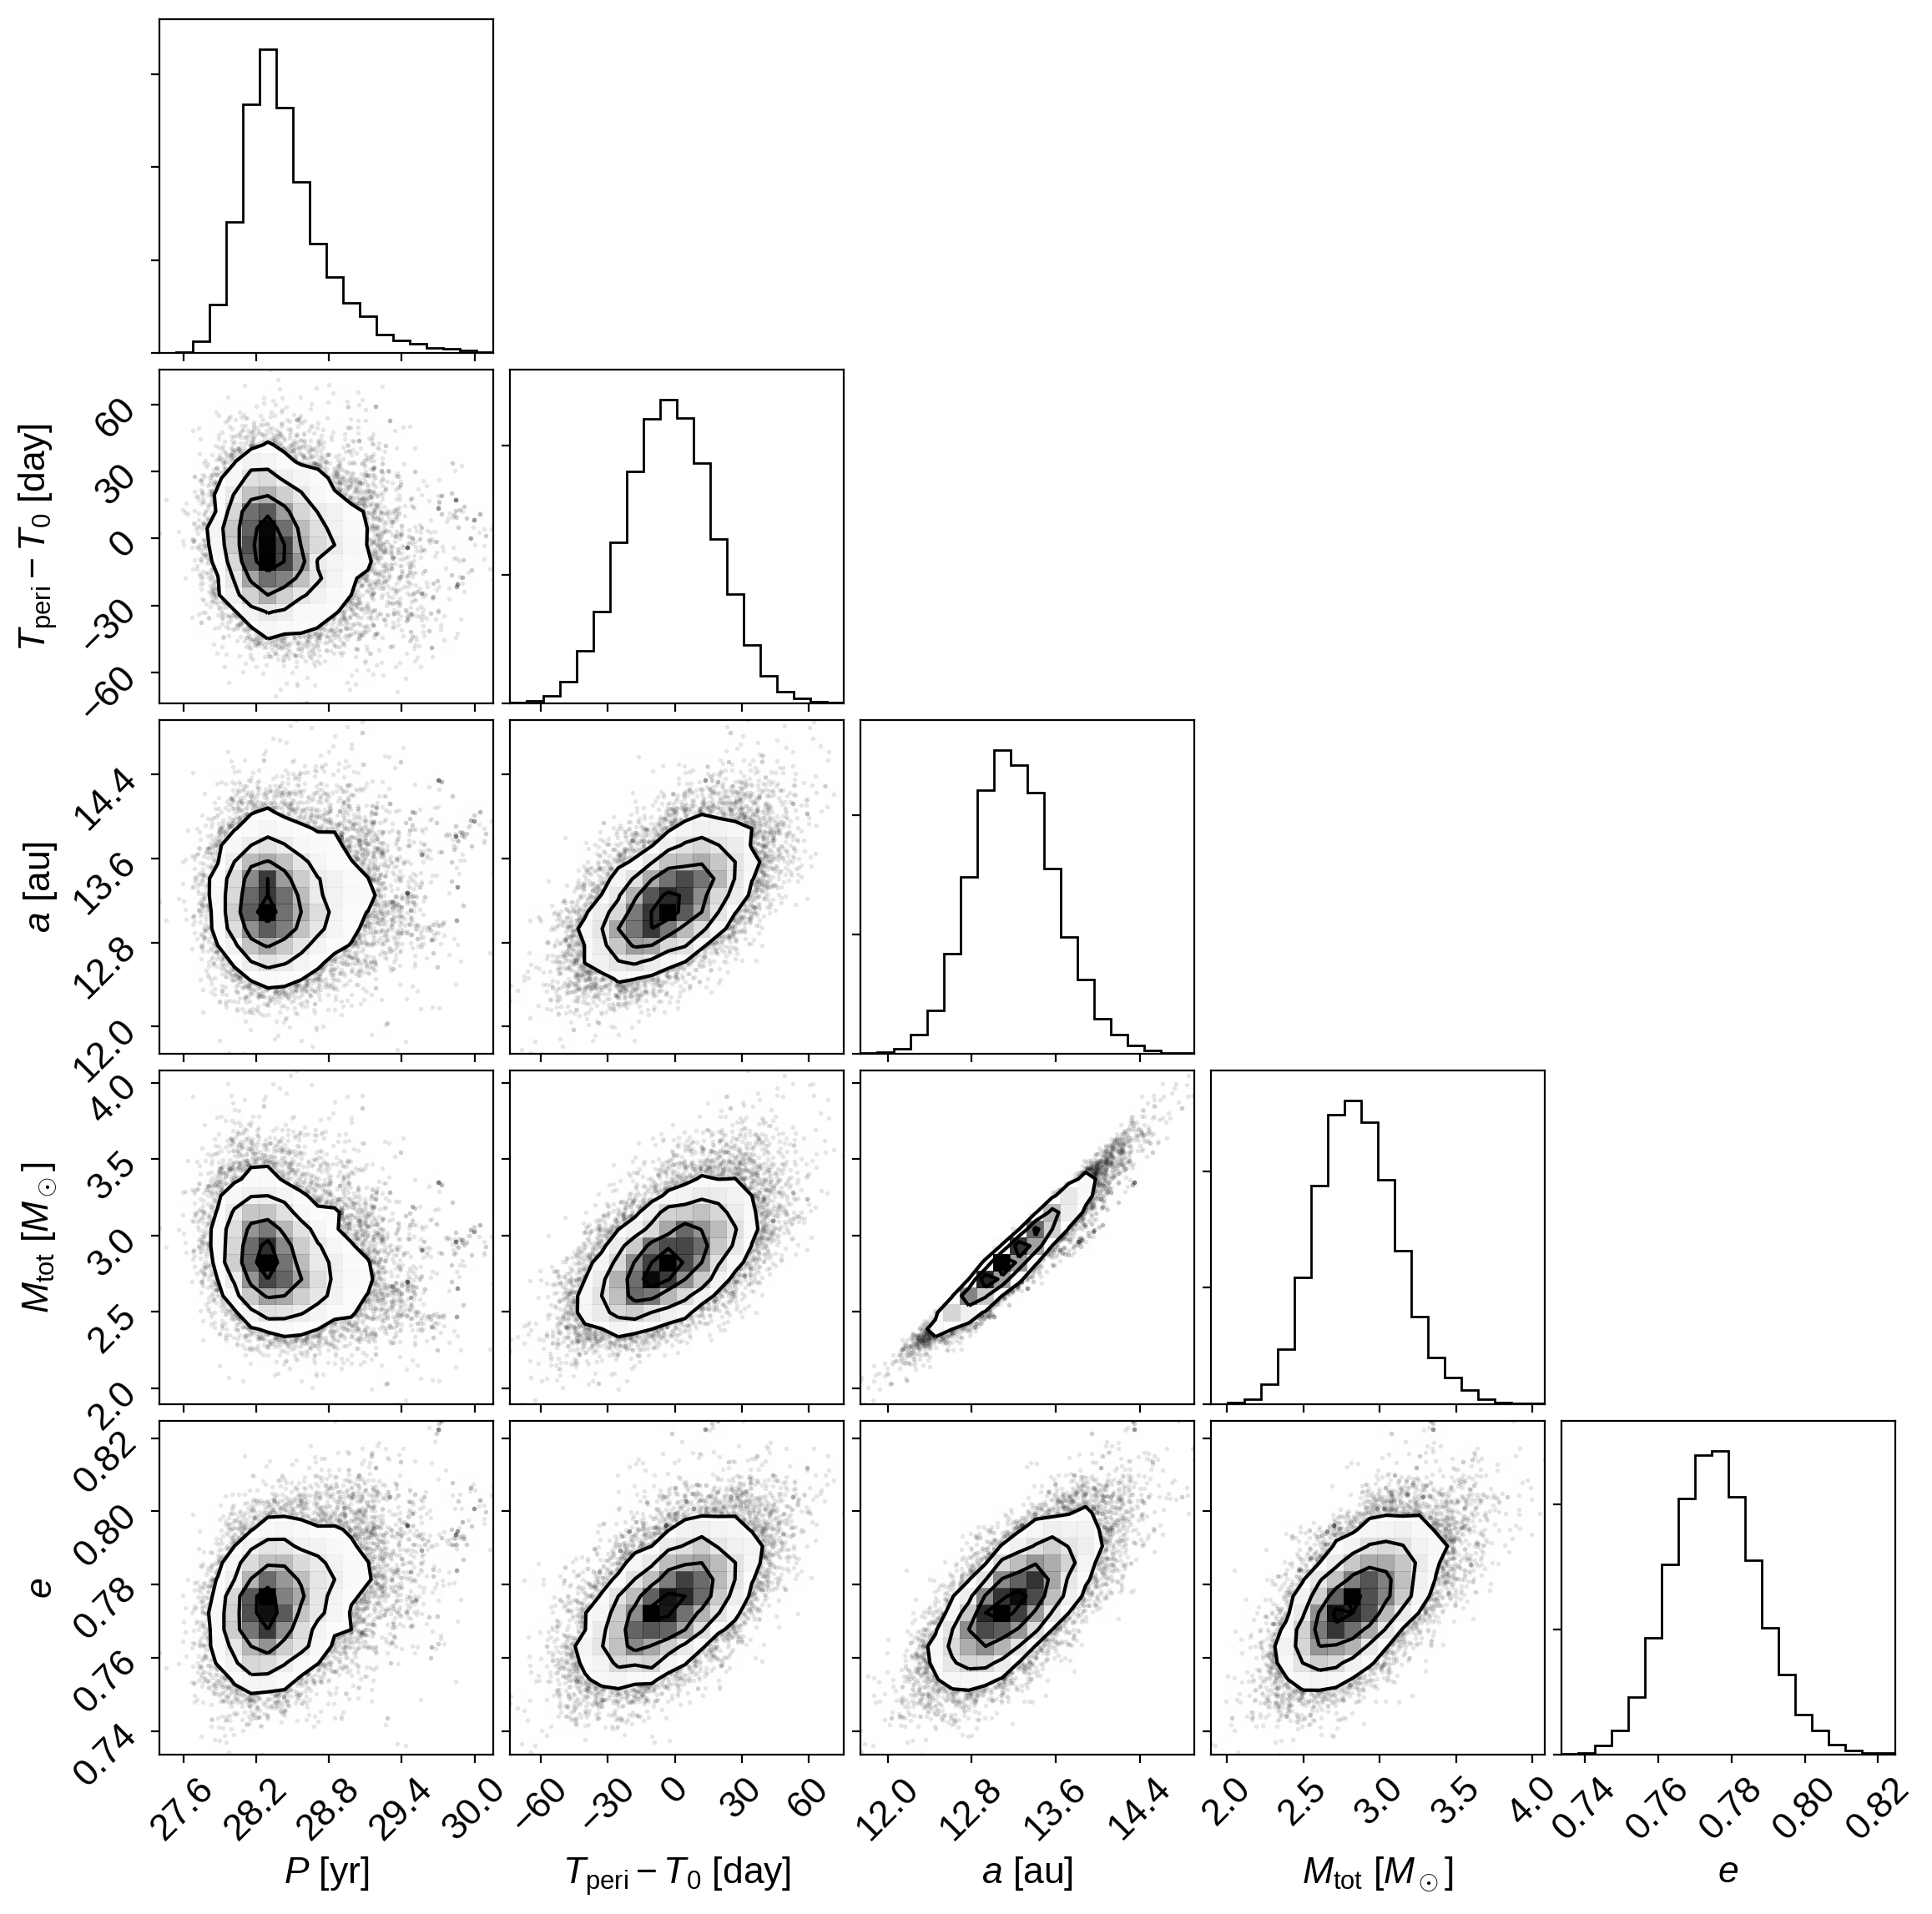

In [17]:
samples = pm.trace_to_dataframe(plx_trace, varnames=["ecc"])
samples["$P$ [yr]"] = plx_trace["P"] / yr
samples["$T_\mathrm{peri} - T_0$ [day]"] = plx_trace["tperi"] - T0
samples["$a$ [au]"] = plx_trace["a"]
samples["$M_\mathrm{tot}$ [$M_\odot$]"] = plx_trace["M_tot"]
samples["$e$"] = plx_trace["ecc"]
del samples["ecc"]
corner.corner(samples);

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [18]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:pymc3, exoplanet:theano}.


In [19]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Ian Czekala and Eric Agol and
            Rodrigo Luger and Geert Barentsen and Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.2.0},
   month = aug,
    year = 2019,
     doi = {10.5281/zenodo.3359880},
     url = {https://doi.org/10.5281/zenodo.3359880}
}
...
